In [1]:
###The purpose of this is to bring in rMATS input and associated binding with it to figure out how binding relates to different things.

In [2]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_venn as mplv
import os
from math import *
from subprocess import *
import pybedtools as pbt
from glob import glob
import seaborn as sns
import statsmodels.formula.api as sm
import csv
import re
import scipy.stats as ss
csv.register_dialect("textdialect",delimiter='\t')
%matplotlib inline
mpl.rc("lines", markeredgewidth=0.5)


/home/sam/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [760]:
#PARSE rMATS SE Code
#May want to check with Anna about my genomic intervals operations
def parse_rMATS_SE(filename,read_cutoff):
    '''This function will parse rMATS output in filename to output only events that meet an
    FDR cutoff and PSI cutoff. The output include both positive and negative delta PSI as well
    as each separated
    Input: filename, FDR_cutoff which is a float 0-1, and PSI cutoff which is a float > 1, and read_cutoff which is and int'''
    rMATS_file = open(filename).readlines()
    rMATS_list = []
    for line in rMATS_file:
        line = line.strip().split('\t')
        fixed_line = []
        for x in line:
            x = x.strip('"')
            fixed_line.append(x)
        rMATS_list.append(fixed_line)
    #add a new column to the list withe the splice ID
    #Note - I would like to figure out how to do this with an existing dataframe
    for item in rMATS_list[0:1]:
        item.insert(0,"splice_id")
    for item in rMATS_list[1:]:
        splice_id = str(item[3]+':'+item[7]+'-'+item[8]+':'+item[5]+'-'+item[6]+':'+item[9]+'-'+item[10]+':'+item[4]+":"+item[2])
        item.insert(0,splice_id)
    #add new columns for sample_1_read_number and sample_2_read_number
    for item in rMATS_list[0:1]:
        item.insert(15,"SAMPLE_1_AVERAGE_READ")
    for item in rMATS_list[1:]:
        sample_1_ic_list = item[13].strip().split(',')
        sample_1_ic_numbers = [int(x) for x in sample_1_ic_list]
        sample_1_sc_list = item[14].strip().split(',')
        sample_1_sc_numbers = [int(x) for x in sample_1_sc_list]
        sample_1_average_read = np.mean(sample_1_ic_numbers) + np.mean(sample_1_sc_numbers)
        item.insert(15,sample_1_average_read)
    for item in rMATS_list[0:1]:
        item.insert(18,"SAMPLE_2_AVERAGE_READ")
    for item in rMATS_list[1:]:
        sample_2_ic_list = item[16].strip().split(',')
        sample_2_ic_numbers = [int(x) for x in sample_2_ic_list]
        sample_2_sc_list = item[17].strip().split(',')
        sample_2_sc_numbers = [int(x) for x in sample_2_sc_list]
        sample_2_average_read = np.mean(sample_2_ic_numbers) + np.mean(sample_2_sc_numbers)
        item.insert(18,sample_2_average_read)    
    #add new column for enhance or silence effect
    for item in rMATS_list[0:1]:
        item.append("splicing_factor_effect")
    for item in rMATS_list[1:]:
        if float(item[-1]) < 0:
            item.append("silence")
        else:
            item.append("enhance")
    #add new columns to have the mean of the PSI values since it is a comma separate list
    for item in rMATS_list[0:1]:
        item.insert(24,"inc_level_1_mean")
    for item in rMATS_list[1:]:
        mean = item[23].strip().split(',')
        mean_no_na = filter(lambda x: x != "NA",mean)
        mean_numbers = [float(i) for i in mean_no_na]
        mean_value = np.mean(mean_numbers)
        item.insert(24,mean_value)
    for item in rMATS_list[0:1]:
        item.insert(26,"inc_level_2_mean")
    for item in rMATS_list[1:]:
        mean = item[25].strip().split(',')
        mean_no_na = filter(lambda x: x != "NA",mean)
        mean_numbers = [float(i) for i in mean_no_na]
        mean_value = np.mean(mean_numbers)
        item.insert(26,mean_value)
    #Remove scaffold chromosomes:
    c_list = ['chrX','chr13','chr12','chr11','chr10','chr17','chr16','chr15','chr14','chr19','chr18','chr22','chr20','chr21','chr7','chr6','chr5','chr4','chr3','chr2','chr1','chr9','chr8']
    for item in rMATS_list[1:]:
        if item[4] not in c_list:
            rMATS_list.remove(item)
    #write this file as a csv for easier import into pandas. Then import it
    with open('tempfile','wb') as temp:
        tempwriter = csv.writer(temp,delimiter='\t')
        for item in rMATS_list:
            tempwriter.writerow(item)
    with open('tempfile') as temp:
        rMATS_df = pd.read_csv(temp,sep='\t')
    os.remove('tempfile')
    #Fix Gene ID so it is just the ens_ID
    rMATS_df['ens_gene'] = rMATS_df.GeneID.str.split('.').str[0]
    #Append ens_gene to splice ID
    rMATS_df['splice_id'] = rMATS_df['splice_id'].astype('str') + ':' + rMATS_df['ens_gene'].astype('str')
    #remove samples less than read cutoff. This means that each sample must have inc + exc >= read cutoff
    rMATS_df = rMATS_df[rMATS_df.SAMPLE_1_AVERAGE_READ >= read_cutoff]
    rMATS_df = rMATS_df[rMATS_df.SAMPLE_2_AVERAGE_READ >= read_cutoff]
    
#     #remove FDR > FDR_cutoff
#     rMATS_df = rMATS_df[rMATS_df.FDR < FDR_cutoff]
#     #remove those beneath delta PSI cutoff
#     rMATS_df = rMATS_df[rMATS_df.IncLevelDifference.abs() >= PSI_cutoff]
    return rMATS_df

In [4]:
#Now load the binding data 
#datasets to use for RT stops = mega dataframe_gene_expression_normalized_1nt
#this one has all of the information and is also normalized with gene calls to the highest expression in a given sample
clip_df = pd.read_csv('hnM_DMSO_TAM_master_dataframe_gene_expression_normalized_1nt',sep='\t')

In [5]:
%%time
#collect a dataframe of the RT stops for each sample
#I have the clip DF, which has the gene expression normalized value. Remember this is normalized binding for library divided by FPKM + 1. I will use this value for assigning binding. No need for length normalization at this point.
clip_normalized_binding_names = ['chrom','start','end','ens_gene','blank','strand','hnM_DMSO_clip_gene_fpkm_norm','hnM_TAM_clip_gene_fpkm_norm','external_gene_name','biotype']
clip_normalized_binding_df = clip_df[clip_normalized_binding_names]
#for RT stops without gene expression correlate, there are NA values where there should be normalized binding information. 
#For now, just throw away those rows
clip_normalized_binding_df.dropna(inplace=True)

clip_normalized_binding_bt = pbt.BedTool.from_dataframe(clip_normalized_binding_df,na_rep='NaN')
# clip_normalized_binding_bt.saveas('clip_normalized_binding_bt')

CPU times: user 4.85 s, sys: 180 ms, total: 5.03 s
Wall time: 5.13 s


In [7]:
#locations on sam-mbp
twist = '../../bcm_alignment_mats/seh1_seh2/MATS_output/SE.MATS.ReadsOnTargetAndJunctionCounts.txt'
cc1_cc2 = '../../bcm_alignment_mats/cc1_cc2/MATS_output/SE.MATS.ReadsOnTargetAndJunctionCounts.txt'
cc3_cc4 = '../../bcm_alignment_mats/cc3_cc4/MATS_output/SE.MATS.ReadsOnTargetAndJunctionCounts.txt'
hh5_hh6 = '../../bcm_alignment_mats/hh5_hh6/MATS_output/SE.MATS.ReadsOnTargetAndJunctionCounts.txt'

In [299]:
%%time
#load in the skipped exon files as variable for the rMATS analysis: Just do the new rMATS first
twist = '/media/sam/Data2/bcm_star_alignments/SEH_bcm/rMATS_3_2_5_results/SEH-1_SEH-2_with_gencode_25lift37/MATS_output/SEH-1_SEH-2_rMATS_3_2_5_SE_ROT'
cc1_cc2 = '/media/sam/Data2/bcm_star_alignments/CC_bcm/rMATS_3_2_5_results/CC-1_CC-2/MATS_output/CC-1_CC-2_rMATS_3_2_5_SE_ROT'
cc3_cc4 = '/media/sam/Data2/bcm_star_alignments/CC_bcm/rMATS_3_2_5_results/CC-3_CC-4/MATS_output/CC-3_CC-4_rMATS_3_2_5_SE_ROT'
hh5_hh6 = '/media/sam/Data2/bcm_star_alignments/HH_bcm/rMATS_3_2_5_results/HH-5_HH-6/MATS_output/HH-5_HH-6_rMATS_3_2_5_SE_ROT'

#also bring in the other EMT sets... tgf-b, snail

#Run parse_rMATS_SE on each
# FDR = 0.05
# PSI = 0.1
reads = 20
twist_rMATS_df = parse_rMATS_SE(filename=twist,read_cutoff=reads)
cc1_cc2_rMATS_df = parse_rMATS_SE(filename=cc1_cc2,read_cutoff=reads)
cc3_cc4_rMATS_df = parse_rMATS_SE(filename=cc3_cc4,read_cutoff=reads)
hh5_hh6_rMATS_df = parse_rMATS_SE(filename=hh5_hh6,read_cutoff=reads)

CPU times: user 21.8 s, sys: 300 ms, total: 22.1 s
Wall time: 22.2 s


(57255, 'non_significant')
(3306, 'inclusion increases during EMT')
(2059, 'skipping increases during EMT')


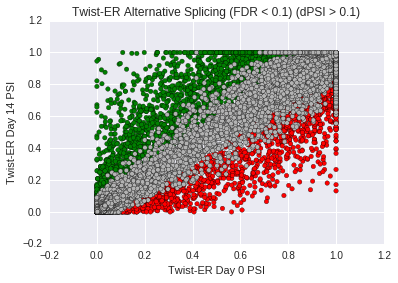

In [126]:
#plot the differential splicing events by inclusion level 1 and inclusion level 2. Plot those with FDR < 0.1 and delta PSI > 0.1
#create a function to label
FDR_cutoff = 0.1
PSI_cutoff = 0.1
read_cutoff = 20
#remove samples less than read cutoff. This means that each sample must have inc + exc >= read cutoff
#This doesn't work!
def read_cutoff_function(dataframe,cutoff):
    dataframe = dataframe[dataframe.SAMPLE_1_AVERAGE_READ >= read_cutoff]
    dataframe = dataframe[dataframe.SAMPLE_2_AVERAGE_READ >= read_cutoff]
    return dataframe
def label_splicing_event(row):
    if row['FDR'] <= FDR_cutoff:
        if row['IncLevelDifference'] >= PSI_cutoff:
            return ('r')
        elif row['IncLevelDifference'] <= (PSI_cutoff*-1):
            return 'g'
        else:
            return  '0.7'
    else:
        return '0.7'
twist_rMATS_df['color'] = twist_rMATS_df.apply(lambda row: label_splicing_event(row),axis=1)
fig = plt.scatter(twist_rMATS_df.inc_level_1_mean,twist_rMATS_df.inc_level_2_mean,c=twist_rMATS_df.color)
fig.axes.set_title('Twist-ER Alternative Splicing (FDR < 0.1) (dPSI > 0.1)')
fig.axes.set_ylabel('Twist-ER Day 14 PSI')
fig.axes.set_xlabel('Twist-ER Day 0 PSI')

print(len(twist_rMATS_df.loc[twist_rMATS_df.color == '0.7']),'non_significant')
print(len(twist_rMATS_df.loc[twist_rMATS_df.color == 'g']),'inclusion increases during EMT')
print(len(twist_rMATS_df.loc[twist_rMATS_df.color == 'r']),'skipping increases during EMT')


#Need to figure out how to add legend
#I also want the legend to show how many events there are
# fig.axes.legend([1,2,3],['a','b','c'],loc=9)


(41635, 'non_significant')
(937, 'inclusion increases during EMT')
(601, 'skipping increases during EMT')


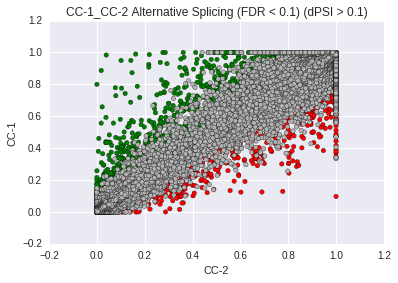

In [127]:
#Now do CC1-CC2
cc1_cc2_rMATS_df['color'] = cc1_cc2_rMATS_df.apply(lambda row: label_splicing_event(row),axis=1)
fig = plt.scatter(cc1_cc2_rMATS_df.inc_level_1_mean,cc1_cc2_rMATS_df.inc_level_2_mean,c=cc1_cc2_rMATS_df.color)
fig.axes.set_title('CC-1_CC-2 Alternative Splicing (FDR < 0.1) (dPSI > 0.1)')
fig.axes.set_ylabel('CC-1')
fig.axes.set_xlabel('CC-2')

print(len(cc1_cc2_rMATS_df.loc[cc1_cc2_rMATS_df.color == '0.7']),'non_significant')
print(len(cc1_cc2_rMATS_df.loc[cc1_cc2_rMATS_df.color == 'g']),'inclusion increases during EMT')
print(len(cc1_cc2_rMATS_df.loc[cc1_cc2_rMATS_df.color == 'r']),'skipping increases during EMT')

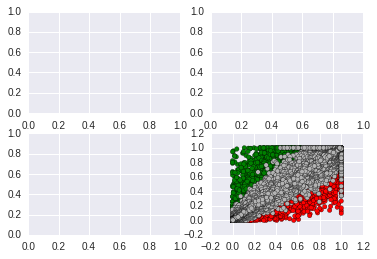

In [135]:
###Ask Meagan - how do I plot properly in matplotlib
fig, ax = plt.subplots(2,2)
plt.scatter(twist_rMATS_df.inc_level_1_mean,twist_rMATS_df.inc_level_2_mean,c=twist_rMATS_df.color)
plt.scatter(cc1_cc2_rMATS_df.inc_level_1_mean,cc1_cc2_rMATS_df.inc_level_2_mean,c=cc1_cc2_rMATS_df.color)

In [144]:
#Make a function for the below:
def intersect_rMATS_SE_with_binding(rMATS_df,slop,binding_bedtool):
    
    #split data by strand

    pos = rMATS_df[rMATS_df.strand == '+']
    neg = rMATS_df[rMATS_df.strand == '-']

    #organize coordinates by strand
    #make names standard for dataframe
    #region 1 = up_ex_downstream_intron
    #region 2 = v_ex_upstream
    #region 3 = v_ex_downstream
    #region 4 = down_ex_upstream_intron
    #upstream_intron_all
    #downstream_intron_all
    #upstream_distal
    #downstream_distal

    #deal with positive strand in four regions

    pos['v_up_ex_start'] = pos.upstreamEE
    pos['v_up_ex_end'] = pos.upstreamEE + slop

    pos['v_upstream_start'] = pos.exonStart_0base - slop
    pos['v_upstream_end'] = pos.exonStart_0base

    pos['v_downstream_start'] = pos.exonEnd
    pos['v_downstream_end'] = pos.exonEnd + slop

    pos['v_down_ex_start'] = pos.downstreamES - slop
    pos['v_down_ex_end'] = pos.downstreamES
    
    pos['upstream_intron_start'] = pos.upstreamEE
    pos['upstream_intron_end'] = pos.exonStart_0base
    
    pos['upstream_distal_intron_start'] = pos.upstreamEE + slop
    pos['upstream_distal_intron_end'] = pos.exonStart_0base - slop
    
    pos['downstream_intron_start'] = pos.exonEnd
    pos['downstream_intron_end'] = pos.downstreamES
    
    pos['downstream_distal_intron_start'] = pos.exonEnd + slop
    pos['downstream_distal_intron_end'] = pos.downstreamES - slop
    
    #deal with negative strand - should just be the inverse of positive strand

    neg['v_up_ex_start'] = neg.downstreamES - slop
    neg['v_up_ex_end'] = neg.downstreamES

    neg['v_upstream_start'] = neg.exonEnd
    neg['v_upstream_end'] = neg.exonEnd + slop

    neg['v_downstream_start'] = neg.exonStart_0base - slop
    neg['v_downstream_end'] = neg.exonStart_0base

    neg['v_down_ex_start'] = neg.upstreamEE
    neg['v_down_ex_end'] = neg.upstreamEE + slop
    
    neg['upstream_intron_start'] = neg.exonEnd
    neg['upstream_intron_end'] = neg.downstreamES
    
    neg['upstream_distal_intron_start'] = neg.exonEnd + slop
    neg['upstream_distal_intron_end'] = neg.downstreamES - slop
    
    neg['downstream_intron_start'] = neg.upstreamEE
    neg['downstream_intron_end'] = neg.exonStart_0base
    
    neg['downstream_distal_intron_start'] = neg.upstreamEE + slop
    neg['downstream_distal_intron_end'] = neg.exonStart_0base - slop

    #Now combine positive and negative strand information

    rMATS_df = pd.concat([pos,neg],ignore_index=True)
    
    #Add in headers to keep important information throughout the intersection process
    
    #region 1 (v_up_ex_start/end)
    region_1_header = ['chr','v_up_ex_start','v_up_ex_end','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID']
    region_1_df = rMATS_df[region_1_header]
    
    #region 2 (v_upstream_start/end)
    region_2_header = ['chr','v_upstream_start','v_upstream_end','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID']
    region_2_df = rMATS_df[region_2_header]
    
    #region 3 (v_downstream_start/end)
    region_3_header = ['chr','v_downstream_start','v_downstream_end','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID']
    region_3_df = rMATS_df[region_3_header]
    
    #region 4 (v_down_ex_start/end)
    region_4_header = ['chr','v_down_ex_start','v_down_ex_end','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID']
    region_4_df = rMATS_df[region_4_header]
    
    #v_header = exon and flanking introns to be altered by slop
    v_header = ['chr','exonStart_0base','exonEnd','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID']
    v_rMATS_df = rMATS_df[v_header]
    
    #whole_event_header = this is the slop number in from flanking exons corrected to zero based half open
    whole_event_header = ['chr','upstreamEE','downstreamES','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID']
    whole_rMATS_df = rMATS_df[whole_event_header]

    #upstream_intron_header
    upstream_intron_header = ['chr','upstream_intron_start','upstream_intron_end','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID']
    upstream_intron_rMATS_df = rMATS_df[upstream_intron_header]
    
    #upstream_distal_intron_header
    upstream_distal_intron_header = ['chr','upstream_distal_intron_start','upstream_distal_intron_end','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID']
    upstream_distal_intron_rMATS_df = rMATS_df[upstream_distal_intron_header]
    
    #downstream_intron_header
    downstream_intron_header = ['chr','downstream_intron_start','downstream_intron_end','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID']
    downstream_intron_rMATS_df = rMATS_df[downstream_intron_header]
    
    #downstream_distal_intron_header
    downstream_distal_intron_header = ['chr','downstream_distal_intron_start','downstream_distal_intron_end','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID']
    downstream_distal_intron_rMATS_df = rMATS_df[downstream_distal_intron_header]
    
    #PROBLEM - IF INTRONS ARE TOO SHORT, DISTAL INTRON CALCULATION WILL FAIL. WE NEED TO DROP COLUMNS IN WHICH START IS > END

    up_before = len(upstream_distal_intron_rMATS_df)
    upstream_distal_intron_rMATS_df = upstream_distal_intron_rMATS_df[upstream_distal_intron_rMATS_df.upstream_distal_intron_start < upstream_distal_intron_rMATS_df.upstream_distal_intron_end]
    up_end = len(upstream_distal_intron_rMATS_df)
    print(up_before - up_end,'upstream distal introns lost due to being too short based on slop*2')
    
    down_before = len(downstream_distal_intron_rMATS_df)
    downstream_distal_intron_rMATS_df = downstream_distal_intron_rMATS_df[downstream_distal_intron_rMATS_df.downstream_distal_intron_start < downstream_distal_intron_rMATS_df.downstream_distal_intron_end]
    down_end = len(downstream_distal_intron_rMATS_df)
    print(down_before - down_end,'downstream distal introns lost due to being too short based on slop*2')
    
    #Now turn into bedtools
    v_bt = pbt.BedTool.from_dataframe(v_rMATS_df)
    v_bt_sorted = v_bt.sort()

    whole_bt = pbt.BedTool.from_dataframe(whole_rMATS_df)
    whole_bt_sorted = whole_bt.sort()
    
    region_1_bt = pbt.BedTool.from_dataframe(region_1_df)
    region_1_bt_sorted = region_1_bt.sort()
    region_2_bt = pbt.BedTool.from_dataframe(region_2_df)
    region_2_bt_sorted = region_2_bt.sort()
    region_3_bt = pbt.BedTool.from_dataframe(region_3_df)
    region_3_bt_sorted = region_3_bt.sort()
    region_4_bt = pbt.BedTool.from_dataframe(region_4_df)
    region_4_bt_sorted = region_4_bt.sort()
    
    upstream_int_bt = pbt.BedTool.from_dataframe(upstream_intron_rMATS_df)
    upstream_int_bt_sorted = upstream_int_bt.sort()
    
    upstream_distal_int_bt = pbt.BedTool.from_dataframe(upstream_distal_intron_rMATS_df)
    upstream_distal_int_bt_sorted = upstream_distal_int_bt.sort()
    
    downstream_int_bt = pbt.BedTool.from_dataframe(downstream_intron_rMATS_df)
    downstream_int_bt_sorted = downstream_int_bt.sort()
    
    downstream_distal_int_bt = pbt.BedTool.from_dataframe(downstream_distal_intron_rMATS_df)
    downstream_distal_int_bt_sorted = downstream_distal_int_bt.sort()
    
    
    #Now slop to extend away from the exon with v_rMATS_bt and whole_rMATS_bt
    #Remember that slop can handle strandedness, but in this case it doesn't matter because I have selected the upstream
    v_bt_sorted_slop = v_bt_sorted.slop(genome='hg19',b=slop)
    whole_bt_sorted_slop = whole_bt.slop(genome='hg19',b=slop)
    
    #now intersect with the binding data
    #Intersect the slopped exons with the binding data
    
    v_bt_sorted_slop_intersect = v_bt_sorted_slop.intersect(b=binding_bedtool,s=True,wa=True,wb=True)

    whole_bt_sorted_slop_intersect = whole_bt_sorted_slop.intersect(b=binding_bedtool,s=True,wa=True,wb=True)
    
    region_1_bt_sorted_intersect = region_1_bt_sorted.intersect(b=binding_bedtool,s=True,wa=True,wb=True)
    region_2_bt_sorted_intersect = region_2_bt_sorted.intersect(b=binding_bedtool,s=True,wa=True,wb=True)
    region_3_bt_sorted_intersect = region_3_bt_sorted.intersect(b=binding_bedtool,s=True,wa=True,wb=True)
    region_4_bt_sorted_intersect = region_4_bt_sorted.intersect(b=binding_bedtool,s=True,wa=True,wb=True)
    
    upstream_int_bt_sorted_intersect = upstream_int_bt_sorted.intersect(b=binding_bedtool,s=True,wa=True,wb=True)
    upstream_distal_int_bt_sorted_intersect = upstream_distal_int_bt_sorted.intersect(b=binding_bedtool,s=True,wa=True,wb=True)
    downstream_int_bt_sorted_intersect = downstream_int_bt_sorted.intersect(b=binding_bedtool,s=True,wa=True,wb=True)
    downstream_distal_int_bt_sorted = downstream_distal_int_bt_sorted.intersect(b=binding_bedtool,s=True,wa=True,wb=True)
    
    #Groupby and sum the proper columns - this is much better than merge - i should have thought of this
    v_bt_sorted_slop_intersect_grouped = v_bt_sorted_slop_intersect.groupby(g=[1,2,3,4,5,6,7,8,9,10,11,12,13],c=[20,21,22,23],o=["sum","sum",'distinct','distinct'])

    whole_bt_sorted_slop_intersect_grouped = whole_bt_sorted_slop_intersect.groupby(g=[1,2,3,4,5,6,7,8,9,10,11,12,13],c=[20,21,22,23],o=["sum","sum",'distinct','distinct'])
    
    region_1_bt_sorted_intersect_grouped = region_1_bt_sorted_intersect.groupby(g=[1,2,3,4,5,6,7,8,9,10,11,12,13],c=[20,21,22,23],o=["sum","sum",'distinct','distinct'])
    region_2_bt_sorted_intersect_grouped = region_2_bt_sorted_intersect.groupby(g=[1,2,3,4,5,6,7,8,9,10,11,12,13],c=[20,21,22,23],o=["sum","sum",'distinct','distinct'])
    region_3_bt_sorted_intersect_grouped = region_3_bt_sorted_intersect.groupby(g=[1,2,3,4,5,6,7,8,9,10,11,12,13],c=[20,21,22,23],o=["sum","sum",'distinct','distinct'])
    region_4_bt_sorted_intersect_grouped = region_4_bt_sorted_intersect.groupby(g=[1,2,3,4,5,6,7,8,9,10,11,12,13],c=[20,21,22,23],o=["sum","sum",'distinct','distinct'])
    
    upstream_int_bt_sorted_intersect_grouped = upstream_int_bt_sorted_intersect.groupby(g=[1,2,3,4,5,6,7,8,9,10,11,12,13],c=[20,21,22,23],o=["sum","sum",'distinct','distinct'])
    
    upstream_distal_int_bt_sorted_intersect_grouped = upstream_distal_int_bt_sorted_intersect.groupby(g=[1,2,3,4,5,6,7,8,9,10,11,12,13],c=[20,21,22,23],o=["sum","sum",'distinct','distinct'])
    
    downstream_int_bt_sorted_intersect_grouped = downstream_int_bt_sorted_intersect.groupby(g=[1,2,3,4,5,6,7,8,9,10,11,12,13],c=[20,21,22,23],o=["sum","sum",'distinct','distinct'])
    
    downstream_distal_int_bt_sorted_grouped = downstream_distal_int_bt_sorted.groupby(g=[1,2,3,4,5,6,7,8,9,10,11,12,13],c=[20,21,22,23],o=["sum","sum",'distinct','distinct'])

    #Print how many splicing events are intersected
    print(len(v_bt_sorted_slop_intersect_grouped),'this many rMATS variable exons intersect with binding')
    print(len(whole_bt_sorted_slop_intersect_grouped),'this many rMATS whole splicing events intersect with binding')
    print(len(region_1_bt_sorted_intersect_grouped),'this many rMATS region 1 intersect with binding')
    print(len(region_2_bt_sorted_intersect_grouped),'this many rMATS region 2 intersect with binding')
    print(len(region_3_bt_sorted_intersect_grouped),'this many rMATS region 3 intersect with binding')
    print(len(region_4_bt_sorted_intersect_grouped),'this many rMATS region 4 intersect with binding')
    print(len(upstream_int_bt_sorted_intersect_grouped),'this many rMATS upstream_intron intersect with binding')
    print(len(upstream_distal_int_bt_sorted_intersect_grouped),'this many rMATS upstream_distal_intron intersect with binding')
    print(len(downstream_int_bt_sorted_intersect_grouped),'this many rMATS downstream_intron intersect with binding')
    print(len(downstream_distal_int_bt_sorted_grouped),'this many rMATS downstream_distal_intron intersect with binding')

    #Now I need to import into pandas for more work and boxplots
    header = ['chr','start','end','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID','hnM_DMSO_clip_fpkm_norm','hnM_TAM_clip_fpkm_norm','external_gene_name','biotype']
    v_intersect_df = v_bt_sorted_slop_intersect_grouped.to_dataframe(names=header)
    whole_intersect_df = whole_bt_sorted_slop_intersect_grouped.to_dataframe(names=header)
    
    region_1_intersect_df = region_1_bt_sorted_intersect_grouped.to_dataframe(names=header)
    region_2_intersect_df = region_2_bt_sorted_intersect_grouped.to_dataframe(names=header)
    region_3_intersect_df = region_3_bt_sorted_intersect_grouped.to_dataframe(names=header)
    region_4_intersect_df = region_4_bt_sorted_intersect_grouped.to_dataframe(names=header)
    
    upstream_int_intersect_df = upstream_int_bt_sorted_intersect_grouped.to_dataframe(names=header)
    upstream_distal_int_intersect_df = upstream_distal_int_bt_sorted_intersect_grouped.to_dataframe(names=header)
    downstream_int_intersect_df = downstream_int_bt_sorted_intersect_grouped.to_dataframe(names=header)
    downstream_distal_int_intersect_df = downstream_distal_int_bt_sorted_grouped.to_dataframe(names=header)

    #add a column for length - this only matters for v_intersect and whole_intersect because regions1-4 are identical length. Do it anyway to keep things consistent
    v_intersect_df['interval_length'] = v_intersect_df.end.astype('float')-v_intersect_df.start.astype('float')
    whole_intersect_df['interval_length'] = whole_intersect_df.end.astype('float')-whole_intersect_df.start.astype('float')
    
    region_1_intersect_df['interval_length'] = region_1_intersect_df.end.astype('float')-region_1_intersect_df.start.astype('float')
    region_2_intersect_df['interval_length'] = region_2_intersect_df.end.astype('float')-region_2_intersect_df.start.astype('float')
    region_3_intersect_df['interval_length'] = region_3_intersect_df.end.astype('float')-region_3_intersect_df.start.astype('float')
    region_4_intersect_df['interval_length'] = region_4_intersect_df.end.astype('float')-region_4_intersect_df.start.astype('float')
    
    upstream_int_intersect_df['interval_length'] = upstream_int_intersect_df.end.astype('float')-upstream_int_intersect_df.start.astype('float')
    upstream_distal_int_intersect_df['interval_length'] = upstream_distal_int_intersect_df.end.astype('float')-upstream_distal_int_intersect_df.start.astype('float')
    downstream_int_intersect_df['interval_length'] = downstream_int_intersect_df.end.astype('float')-downstream_int_intersect_df.start.astype('float')
    downstream_distal_int_intersect_df['interval_length'] = downstream_distal_int_intersect_df.end.astype('float')-downstream_distal_int_intersect_df.start.astype('float')

    #calculate length normalized binding
    #PROBLEMS WITH THIS - LONG EXONS WILL DILUTE BINDING IF THE BINDING SITES HAPPEN TO BE ON THE EXON
    #This is why region length is an advantage
    v_intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = v_intersect_df.hnM_DMSO_clip_fpkm_norm / v_intersect_df.interval_length
    v_intersect_df['hnM_TAM_clip_fpkm_length_norm'] = v_intersect_df.hnM_TAM_clip_fpkm_norm / v_intersect_df.interval_length

    whole_intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = whole_intersect_df.hnM_DMSO_clip_fpkm_norm / whole_intersect_df.interval_length
    whole_intersect_df['hnM_TAM_clip_fpkm_length_norm'] = whole_intersect_df.hnM_TAM_clip_fpkm_norm / whole_intersect_df.interval_length
    
    region_1_intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = region_1_intersect_df.hnM_DMSO_clip_fpkm_norm / region_1_intersect_df.interval_length
    region_1_intersect_df['hnM_TAM_clip_fpkm_length_norm'] = region_1_intersect_df.hnM_TAM_clip_fpkm_norm / region_1_intersect_df.interval_length
    
    region_2_intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = region_2_intersect_df.hnM_DMSO_clip_fpkm_norm / region_2_intersect_df.interval_length
    region_2_intersect_df['hnM_TAM_clip_fpkm_length_norm'] = region_2_intersect_df.hnM_TAM_clip_fpkm_norm / region_2_intersect_df.interval_length
    
    region_3_intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = region_3_intersect_df.hnM_DMSO_clip_fpkm_norm / region_3_intersect_df.interval_length
    region_3_intersect_df['hnM_TAM_clip_fpkm_length_norm'] = region_3_intersect_df.hnM_TAM_clip_fpkm_norm / region_3_intersect_df.interval_length
    
    region_4_intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = region_4_intersect_df.hnM_DMSO_clip_fpkm_norm / region_4_intersect_df.interval_length
    region_4_intersect_df['hnM_TAM_clip_fpkm_length_norm'] = region_4_intersect_df.hnM_TAM_clip_fpkm_norm / region_4_intersect_df.interval_length
    
    upstream_int_intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = upstream_int_intersect_df.hnM_DMSO_clip_fpkm_norm / upstream_int_intersect_df.interval_length
    upstream_int_intersect_df['hnM_TAM_clip_fpkm_length_norm'] = upstream_int_intersect_df.hnM_TAM_clip_fpkm_norm / upstream_int_intersect_df.interval_length
    
    upstream_distal_int_intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = upstream_distal_int_intersect_df.hnM_DMSO_clip_fpkm_norm / upstream_distal_int_intersect_df.interval_length
    upstream_distal_int_intersect_df['hnM_TAM_clip_fpkm_length_norm'] = upstream_distal_int_intersect_df.hnM_TAM_clip_fpkm_norm / upstream_distal_int_intersect_df.interval_length
    
    downstream_int_intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = downstream_int_intersect_df.hnM_DMSO_clip_fpkm_norm / downstream_int_intersect_df.interval_length
    downstream_int_intersect_df['hnM_TAM_clip_fpkm_length_norm'] = downstream_int_intersect_df.hnM_TAM_clip_fpkm_norm / downstream_int_intersect_df.interval_length
    
    downstream_distal_int_intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = downstream_distal_int_intersect_df.hnM_DMSO_clip_fpkm_norm / downstream_distal_int_intersect_df.interval_length
    downstream_distal_int_intersect_df['hnM_TAM_clip_fpkm_length_norm'] = downstream_distal_int_intersect_df.hnM_TAM_clip_fpkm_norm / downstream_distal_int_intersect_df.interval_length
    
    #add pseudocounts and calculate log2ratio of binding based on minimum binding score
    #Looking at several minimums, it seems that 1e-8 is safely 10 fold beneath the minimum
    pseudocount = 1e-8
    v_intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = v_intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)
    whole_intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = whole_intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)
    region_1_intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = region_1_intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)
    region_2_intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = region_2_intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)
    region_3_intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = region_3_intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)
    region_4_intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = region_4_intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)
    upstream_int_intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = upstream_int_intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)
    upstream_distal_int_intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = upstream_distal_int_intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)
    downstream_int_intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = downstream_int_intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)
    downstream_distal_int_intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = downstream_distal_int_intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)
    #return the outputs of the function
    return (v_intersect_df,whole_intersect_df,region_1_intersect_df,region_2_intersect_df,region_3_intersect_df,region_4_intersect_df,upstream_int_intersect_df,upstream_distal_int_intersect_df,downstream_int_intersect_df,downstream_distal_int_intersect_df)

In [300]:
print(len(twist_rMATS_df))
print(len(cc1_cc2_rMATS_df))

62620
43173


In [147]:
%%time
#Process through the intersection script
slop = 500

(twist_v_intersect_df,twist_whole_intersect_df,twist_region_1_intersect_df,twist_region_2_intersect_df,twist_region_3_intersect_df,twist_region_4_intersect_df,twist_upstream_int_intersect_df,twist_upstream_distal_int_intersect_df,twist_downstream_int_intersect_df,twist_downstream_distal_int_intersect_df) = intersect_rMATS_SE_with_binding(twist_rMATS_df,slop,clip_normalized_binding_bt)

(cc1_cc2_v_intersect_df,cc1_cc2_whole_intersect_df,cc1_cc2_region_1_intersect_df,cc1_cc2_region_2_intersect_df,cc1_cc2_region_3_intersect_df,cc1_cc2_region_4_intersect_df,cc1_cc2_upstream_int_intersect_df,cc1_cc2_upstream_distal_int_intersect_df,cc1_cc2_downstream_int_intersect_df,cc1_cc2_downstream_distal_int_intersect_df) = intersect_rMATS_SE_with_binding(cc1_cc2_rMATS_df,slop,clip_normalized_binding_bt)

(cc3_cc4_v_intersect_df,cc3_cc4_whole_intersect_df,cc3_cc4_region_1_intersect_df,cc3_cc4_region_2_intersect_df,cc3_cc4_region_3_intersect_df,cc3_cc4_region_4_intersect_df,cc3_cc4_upstream_int_intersect_df,cc3_cc4_upstream_distal_int_intersect_df,cc3_cc4_downstream_int_intersect_df,cc3_cc4_downstream_distal_int_intersect_df) = intersect_rMATS_SE_with_binding(cc3_cc4_rMATS_df,slop,clip_normalized_binding_bt)

(hh5_hh6_v_intersect_df,hh5_hh6_whole_intersect_df,hh5_hh6_region_1_intersect_df,hh5_hh6_region_2_intersect_df,hh5_hh6_region_3_intersect_df,hh5_hh6_region_4_intersect_df,hh5_hh6_upstream_int_intersect_df,hh5_hh6_upstream_distal_int_intersect_df,hh5_hh6_downstream_int_intersect_df,hh5_hh6_downstream_distal_int_intersect_df) = intersect_rMATS_SE_with_binding(hh5_hh6_rMATS_df,slop,clip_normalized_binding_bt)

(19217, 'upstream distal introns lost due to being too short based on slop*2')
(19890, 'downstream distal introns lost due to being too short based on slop*2')
(10983, 'this many rMATS variable exons intersect with binding')
(31772, 'this many rMATS whole splicing events intersect with binding')
(6875, 'this many rMATS region 1 intersect with binding')
(6519, 'this many rMATS region 2 intersect with binding')
(6247, 'this many rMATS region 3 intersect with binding')
(4983, 'this many rMATS region 4 intersect with binding')
(22121, 'this many rMATS upstream_intron intersect with binding')
(19551, 'this many rMATS upstream_distal_intron intersect with binding')
(18953, 'this many rMATS downstream_intron intersect with binding')
(16530, 'this many rMATS downstream_distal_intron intersect with binding')
(13377, 'upstream distal introns lost due to being too short based on slop*2')
(13327, 'downstream distal introns lost due to being too short based on slop*2')
(7622, 'this many rMATS varia

In [12]:
%%time
#Problem - we also want an output of all possible spliced exons, not just those that show up in rMATS output. One option is to use just the splicing events detected by rMATS with no filtering. There could be false positives here including some exons that are somewhat constitutive, but we could cast the widest net

#Note gencode.v25lift37.annotation.gtf is not complete, need to rerun rMATS sometime

#location of files
#load in the skipped exon files as variable for the rMATS analysis: Just do the new rMATS first
twist = '/media/sam/Data2/bcm_star_alignments/SEH_bcm/rMATS_3_2_5_results/SEH-1_SEH-2_with_gencode_25lift37/ASEvents/fromGTF.SE.txt'
cc1_cc2 = '/media/sam/Data2/bcm_star_alignments/CC_bcm/rMATS_3_2_5_results/CC-1_CC-2/ASEvents/fromGTF.SE.txt'
cc3_cc4 = '/media/sam/Data2/bcm_star_alignments/CC_bcm/rMATS_3_2_5_results/CC-3_CC-4/ASEvents/fromGTF.SE.txt'
hh5_hh6 = '/media/sam/Data2/bcm_star_alignments/HH_bcm/rMATS_3_2_5_results/HH-5_HH-6/ASEvents/fromGTF.SE.txt'

def parse_rMATS_ALL_SE(filename):
    rMATS_file = open(filename).readlines()
    rMATS_list = []
    for line in rMATS_file:
        line = line.strip().split('\t')
        fixed_line = []
        for x in line:
            x = x.strip('"')
            fixed_line.append(x)
        rMATS_list.append(fixed_line)
    #add a new column to the list withe the splice ID
    #Note - I would like to figure out how to do this with an existing dataframe
    for item in rMATS_list[0:1]:
        item.insert(0,"splice_id")
    for item in rMATS_list[1:]:
        splice_id = str(item[3]+':'+item[7]+'-'+item[8]+':'+item[5]+'-'+item[6]+':'+item[9]+'-'+item[10]+':'+item[4]+":"+item[2])
        item.insert(0,splice_id)
    #Remove scaffold chromosomes:
    c_list = ['chrX','chr13','chr12','chr11','chr10','chr17','chr16','chr15','chr14','chr19','chr18','chr22','chr20','chr21','chr7','chr6','chr5','chr4','chr3','chr2','chr1','chr9','chr8']
    for item in rMATS_list[1:]:
        if item[4] not in c_list:
            rMATS_list.remove(item)
    #write this file as a csv for easier import into pandas. Then import it
    with open('tempfile','wb') as temp:
        tempwriter = csv.writer(temp,delimiter='\t')
        for item in rMATS_list:
            tempwriter.writerow(item)
    with open('tempfile') as temp:
        rMATS_df = pd.read_csv(temp,sep='\t')
    os.remove('tempfile')
    #Fix Gene ID so it is just the ens_ID
    rMATS_df['ens_gene'] = rMATS_df.GeneID.str.split('.').str[0]
    #Append ens_gene to splice ID
    rMATS_df['splice_id'] = rMATS_df['splice_id'].astype('str') + ':' + rMATS_df['ens_gene'].astype('str')
    return rMATS_df

#Run this on the raw ALL_SE outputs from 3.2.5 run of rMATS

twist_rMATS_ALL_SE_df = parse_rMATS_ALL_SE(twist)
cc1_cc2_rMATS_ALL_SE_df = parse_rMATS_ALL_SE(cc1_cc2)
cc3_cc4_rMATS_ALL_SE_df = parse_rMATS_ALL_SE(cc3_cc4)
hh5_hh6_rMATS_ALL_SE_df = parse_rMATS_ALL_SE(hh5_hh6)

CPU times: user 6.48 s, sys: 128 ms, total: 6.6 s
Wall time: 6.63 s


In [148]:
#Make a function for the below:
def intersect_rMATS_ALL_SE_with_binding(rMATS_df,slop,binding_bedtool):
    
    #split data by strand

    pos = rMATS_df[rMATS_df.strand == '+']
    neg = rMATS_df[rMATS_df.strand == '-']

    #organize coordinates by strand
    #make names standard for dataframe
    #region 1 = up_ex_downstream_intron
    #region 2 = v_ex_upstream
    #region 3 = v_ex_downstream
    #region 4 = down_ex_upstream_intron
    #upstream_intron_all
    #downstream_intron_all
    #upstream_distal
    #downstream_distal

    #deal with positive strand in four regions

    pos['v_up_ex_start'] = pos.upstreamEE
    pos['v_up_ex_end'] = pos.upstreamEE + slop

    pos['v_upstream_start'] = pos.exonStart_0base - slop
    pos['v_upstream_end'] = pos.exonStart_0base

    pos['v_downstream_start'] = pos.exonEnd
    pos['v_downstream_end'] = pos.exonEnd + slop

    pos['v_down_ex_start'] = pos.downstreamES - slop
    pos['v_down_ex_end'] = pos.downstreamES
    
    pos['upstream_intron_start'] = pos.upstreamEE
    pos['upstream_intron_end'] = pos.exonStart_0base
    
    pos['upstream_distal_intron_start'] = pos.upstreamEE + slop
    pos['upstream_distal_intron_end'] = pos.exonStart_0base - slop
    
    pos['downstream_intron_start'] = pos.exonEnd
    pos['downstream_intron_end'] = pos.downstreamES
    
    pos['downstream_distal_intron_start'] = pos.exonEnd + slop
    pos['downstream_distal_intron_end'] = pos.downstreamES - slop
    
    #deal with negative strand - should just be the inverse of positive strand

    neg['v_up_ex_start'] = neg.downstreamES - slop
    neg['v_up_ex_end'] = neg.downstreamES

    neg['v_upstream_start'] = neg.exonEnd
    neg['v_upstream_end'] = neg.exonEnd + slop

    neg['v_downstream_start'] = neg.exonStart_0base - slop
    neg['v_downstream_end'] = neg.exonStart_0base

    neg['v_down_ex_start'] = neg.upstreamEE
    neg['v_down_ex_end'] = neg.upstreamEE + slop
    
    neg['upstream_intron_start'] = neg.exonEnd
    neg['upstream_intron_end'] = neg.downstreamES
    
    neg['upstream_distal_intron_start'] = neg.exonEnd + slop
    neg['upstream_distal_intron_end'] = neg.downstreamES - slop
    
    neg['downstream_intron_start'] = neg.upstreamEE
    neg['downstream_intron_end'] = neg.exonStart_0base
    
    neg['downstream_distal_intron_start'] = neg.upstreamEE + slop
    neg['downstream_distal_intron_end'] = neg.exonStart_0base - slop

    #Now combine positive and negative strand information

    rMATS_df = pd.concat([pos,neg],ignore_index=True)
    
    #Add in headers to keep important information throughout the intersection process
    
    #region 1 (v_up_ex_start/end)
    region_1_header = ['chr','v_up_ex_start','v_up_ex_end','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID']
    region_1_df = rMATS_df[region_1_header]
    
    #region 2 (v_upstream_start/end)
    region_2_header = ['chr','v_upstream_start','v_upstream_end','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID']
    region_2_df = rMATS_df[region_2_header]
    
    #region 3 (v_downstream_start/end)
    region_3_header = ['chr','v_downstream_start','v_downstream_end','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID']
    region_3_df = rMATS_df[region_3_header]
    
    #region 4 (v_down_ex_start/end)
    region_4_header = ['chr','v_down_ex_start','v_down_ex_end','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID']
    region_4_df = rMATS_df[region_4_header]
    
    #v_header = exon and flanking introns to be altered by slop
    v_header = ['chr','exonStart_0base','exonEnd','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID']
    v_rMATS_df = rMATS_df[v_header]
    
    #whole_event_header = this is the slop number in from flanking exons corrected to zero based half open
    whole_event_header = ['chr','upstreamEE','downstreamES','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID']
    whole_rMATS_df = rMATS_df[whole_event_header]

    #upstream_intron_header
    upstream_intron_header = ['chr','upstream_intron_start','upstream_intron_end','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID']
    upstream_intron_rMATS_df = rMATS_df[upstream_intron_header]
    
    #upstream_distal_intron_header
    upstream_distal_intron_header = ['chr','upstream_distal_intron_start','upstream_distal_intron_end','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID']
    upstream_distal_intron_rMATS_df = rMATS_df[upstream_distal_intron_header]
    
    #downstream_intron_header
    downstream_intron_header = ['chr','downstream_intron_start','downstream_intron_end','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID']
    downstream_intron_rMATS_df = rMATS_df[downstream_intron_header]
    
    #downstream_distal_intron_header
    downstream_distal_intron_header = ['chr','downstream_distal_intron_start','downstream_distal_intron_end','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID']
    downstream_distal_intron_rMATS_df = rMATS_df[downstream_distal_intron_header]
    
    #PROBLEM - IF INTRONS ARE TOO SHORT, DISTAL INTRON CALCULATION WILL FAIL. WE NEED TO DROP COLUMNS IN WHICH START IS > END

    up_before = len(upstream_distal_intron_rMATS_df)
    upstream_distal_intron_rMATS_df = upstream_distal_intron_rMATS_df[upstream_distal_intron_rMATS_df.upstream_distal_intron_start < upstream_distal_intron_rMATS_df.upstream_distal_intron_end]
    up_end = len(upstream_distal_intron_rMATS_df)
    print(up_before - up_end,'upstream distal introns lost due to being too short based on slop*2')
    
    down_before = len(downstream_distal_intron_rMATS_df)
    downstream_distal_intron_rMATS_df = downstream_distal_intron_rMATS_df[downstream_distal_intron_rMATS_df.downstream_distal_intron_start < downstream_distal_intron_rMATS_df.downstream_distal_intron_end]
    down_end = len(downstream_distal_intron_rMATS_df)
    print(down_before - down_end,'downstream distal introns lost due to being too short based on slop*2')
    
    #Now turn into bedtools
    v_bt = pbt.BedTool.from_dataframe(v_rMATS_df)
    v_bt_sorted = v_bt.sort()

    whole_bt = pbt.BedTool.from_dataframe(whole_rMATS_df)
    whole_bt_sorted = whole_bt.sort()
    
    region_1_bt = pbt.BedTool.from_dataframe(region_1_df)
    region_1_bt_sorted = region_1_bt.sort()
    region_2_bt = pbt.BedTool.from_dataframe(region_2_df)
    region_2_bt_sorted = region_2_bt.sort()
    region_3_bt = pbt.BedTool.from_dataframe(region_3_df)
    region_3_bt_sorted = region_3_bt.sort()
    region_4_bt = pbt.BedTool.from_dataframe(region_4_df)
    region_4_bt_sorted = region_4_bt.sort()
    
    upstream_int_bt = pbt.BedTool.from_dataframe(upstream_intron_rMATS_df)
    upstream_int_bt_sorted = upstream_int_bt.sort()
    
    upstream_distal_int_bt = pbt.BedTool.from_dataframe(upstream_distal_intron_rMATS_df)
    upstream_distal_int_bt_sorted = upstream_distal_int_bt.sort()
    
    downstream_int_bt = pbt.BedTool.from_dataframe(downstream_intron_rMATS_df)
    downstream_int_bt_sorted = downstream_int_bt.sort()
    
    downstream_distal_int_bt = pbt.BedTool.from_dataframe(downstream_distal_intron_rMATS_df)
    downstream_distal_int_bt_sorted = downstream_distal_int_bt.sort()
    
    
    #Now slop to extend away from the exon with v_rMATS_bt and whole_rMATS_bt
    #Remember that slop can handle strandedness, but in this case it doesn't matter because I have selected the upstream
    v_bt_sorted_slop = v_bt_sorted.slop(genome='hg19',b=slop)
    whole_bt_sorted_slop = whole_bt.slop(genome='hg19',b=slop)
    
    #now intersect with the binding data
    #Intersect the slopped exons with the binding data
    
    v_bt_sorted_slop_intersect = v_bt_sorted_slop.intersect(b=binding_bedtool,s=True,wa=True,wb=True)

    whole_bt_sorted_slop_intersect = whole_bt_sorted_slop.intersect(b=binding_bedtool,s=True,wa=True,wb=True)
    
    region_1_bt_sorted_intersect = region_1_bt_sorted.intersect(b=binding_bedtool,s=True,wa=True,wb=True)
    region_2_bt_sorted_intersect = region_2_bt_sorted.intersect(b=binding_bedtool,s=True,wa=True,wb=True)
    region_3_bt_sorted_intersect = region_3_bt_sorted.intersect(b=binding_bedtool,s=True,wa=True,wb=True)
    region_4_bt_sorted_intersect = region_4_bt_sorted.intersect(b=binding_bedtool,s=True,wa=True,wb=True)
    
    upstream_int_bt_sorted_intersect = upstream_int_bt_sorted.intersect(b=binding_bedtool,s=True,wa=True,wb=True)
    upstream_distal_int_bt_sorted_intersect = upstream_distal_int_bt_sorted.intersect(b=binding_bedtool,s=True,wa=True,wb=True)
    downstream_int_bt_sorted_intersect = downstream_int_bt_sorted.intersect(b=binding_bedtool,s=True,wa=True,wb=True)
    downstream_distal_int_bt_sorted = downstream_distal_int_bt_sorted.intersect(b=binding_bedtool,s=True,wa=True,wb=True)
    
    #Groupby and sum the proper columns - this is much better than merge - i should have thought of this
    v_bt_sorted_slop_intersect_grouped = v_bt_sorted_slop_intersect.groupby(g=[1,2,3,4,5,6],c=[13,14,15,16],o=["sum","sum",'distinct','distinct'])

    whole_bt_sorted_slop_intersect_grouped = whole_bt_sorted_slop_intersect.groupby(g=[1,2,3,4,5,6],c=[13,14,15,16],o=["sum","sum",'distinct','distinct'])
    
    region_1_bt_sorted_intersect_grouped = region_1_bt_sorted_intersect.groupby(g=[1,2,3,4,5,6],c=[13,14,15,16],o=["sum","sum",'distinct','distinct'])
    region_2_bt_sorted_intersect_grouped = region_2_bt_sorted_intersect.groupby(g=[1,2,3,4,5,6],c=[13,14,15,16],o=["sum","sum",'distinct','distinct'])
    region_3_bt_sorted_intersect_grouped = region_3_bt_sorted_intersect.groupby(g=[1,2,3,4,5,6],c=[13,14,15,16],o=["sum","sum",'distinct','distinct'])
    region_4_bt_sorted_intersect_grouped = region_4_bt_sorted_intersect.groupby(g=[1,2,3,4,5,6],c=[13,14,15,16],o=["sum","sum",'distinct','distinct'])
    
    upstream_int_bt_sorted_intersect_grouped = upstream_int_bt_sorted_intersect.groupby(g=[1,2,3,4,5,6],c=[13,14,15,16],o=["sum","sum",'distinct','distinct'])
    
    upstream_distal_int_bt_sorted_intersect_grouped = upstream_distal_int_bt_sorted_intersect.groupby(g=[1,2,3,4,5,6],c=[13,14,15,16],o=["sum","sum",'distinct','distinct'])
    
    downstream_int_bt_sorted_intersect_grouped = downstream_int_bt_sorted_intersect.groupby(g=[1,2,3,4,5,6],c=[13,14,15,16],o=["sum","sum",'distinct','distinct'])
    
    downstream_distal_int_bt_sorted_grouped = downstream_distal_int_bt_sorted.groupby(g=[1,2,3,4,5,6],c=[13,14,15,16],o=["sum","sum",'distinct','distinct'])

    #Print how many splicing events are intersected
    print(len(v_bt_sorted_slop_intersect_grouped),'this many rMATS variable exons intersect with binding')
    print(len(whole_bt_sorted_slop_intersect_grouped),'this many rMATS whole splicing events intersect with binding')
    print(len(region_1_bt_sorted_intersect_grouped),'this many rMATS region 1 intersect with binding')
    print(len(region_2_bt_sorted_intersect_grouped),'this many rMATS region 2 intersect with binding')
    print(len(region_3_bt_sorted_intersect_grouped),'this many rMATS region 3 intersect with binding')
    print(len(region_4_bt_sorted_intersect_grouped),'this many rMATS region 4 intersect with binding')
    print(len(upstream_int_bt_sorted_intersect_grouped),'this many rMATS upstream_intron intersect with binding')
    print(len(upstream_distal_int_bt_sorted_intersect_grouped),'this many rMATS upstream_distal_intron intersect with binding')
    print(len(downstream_int_bt_sorted_intersect_grouped),'this many rMATS downstream_intron intersect with binding')
    print(len(downstream_distal_int_bt_sorted_grouped),'this many rMATS downstream_distal_intron intersect with binding')

    #Now I need to import into pandas for more work and boxplots
    header = ['chr','start','end','ens_gene','splice_id','strand','inc_level_1_mean','inc_level_2_mean','IncLevelDifference','FDR','SAMPLE_1_AVERAGE_READ','SAMPLE_2_AVERAGE_READ','ID','hnM_DMSO_clip_fpkm_norm','hnM_TAM_clip_fpkm_norm','external_gene_name','biotype']
    v_intersect_df = v_bt_sorted_slop_intersect_grouped.to_dataframe(names=header)
    whole_intersect_df = whole_bt_sorted_slop_intersect_grouped.to_dataframe(names=header)
    
    region_1_intersect_df = region_1_bt_sorted_intersect_grouped.to_dataframe(names=header)
    region_2_intersect_df = region_2_bt_sorted_intersect_grouped.to_dataframe(names=header)
    region_3_intersect_df = region_3_bt_sorted_intersect_grouped.to_dataframe(names=header)
    region_4_intersect_df = region_4_bt_sorted_intersect_grouped.to_dataframe(names=header)
    
    upstream_int_intersect_df = upstream_int_bt_sorted_intersect_grouped.to_dataframe(names=header)
    upstream_distal_int_intersect_df = upstream_distal_int_bt_sorted_intersect_grouped.to_dataframe(names=header)
    downstream_int_intersect_df = downstream_int_bt_sorted_intersect_grouped.to_dataframe(names=header)
    downstream_distal_int_intersect_df = downstream_distal_int_bt_sorted_grouped.to_dataframe(names=header)

    #add a column for length - this only matters for v_intersect and whole_intersect because regions1-4 are identical length. Do it anyway to keep things consistent
    v_intersect_df['interval_length'] = v_intersect_df.end.astype('float')-v_intersect_df.start.astype('float')
    whole_intersect_df['interval_length'] = whole_intersect_df.end.astype('float')-whole_intersect_df.start.astype('float')
    
    region_1_intersect_df['interval_length'] = region_1_intersect_df.end.astype('float')-region_1_intersect_df.start.astype('float')
    region_2_intersect_df['interval_length'] = region_2_intersect_df.end.astype('float')-region_2_intersect_df.start.astype('float')
    region_3_intersect_df['interval_length'] = region_3_intersect_df.end.astype('float')-region_3_intersect_df.start.astype('float')
    region_4_intersect_df['interval_length'] = region_4_intersect_df.end.astype('float')-region_4_intersect_df.start.astype('float')
    
    upstream_int_intersect_df['interval_length'] = upstream_int_intersect_df.end.astype('float')-upstream_int_intersect_df.start.astype('float')
    upstream_distal_int_intersect_df['interval_length'] = upstream_distal_int_intersect_df.end.astype('float')-upstream_distal_int_intersect_df.start.astype('float')
    downstream_int_intersect_df['interval_length'] = downstream_int_intersect_df.end.astype('float')-downstream_int_intersect_df.start.astype('float')
    downstream_distal_int_intersect_df['interval_length'] = downstream_distal_int_intersect_df.end.astype('float')-downstream_distal_int_intersect_df.start.astype('float')

    #calculate length normalized binding
    #PROBLEMS WITH THIS - LONG EXONS WILL DILUTE BINDING IF THE BINDING SITES HAPPEN TO BE ON THE EXON
    #This is why region length is an advantage
    v_intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = v_intersect_df.hnM_DMSO_clip_fpkm_norm / v_intersect_df.interval_length
    v_intersect_df['hnM_TAM_clip_fpkm_length_norm'] = v_intersect_df.hnM_TAM_clip_fpkm_norm / v_intersect_df.interval_length

    whole_intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = whole_intersect_df.hnM_DMSO_clip_fpkm_norm / whole_intersect_df.interval_length
    whole_intersect_df['hnM_TAM_clip_fpkm_length_norm'] = whole_intersect_df.hnM_TAM_clip_fpkm_norm / whole_intersect_df.interval_length
    
    region_1_intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = region_1_intersect_df.hnM_DMSO_clip_fpkm_norm / region_1_intersect_df.interval_length
    region_1_intersect_df['hnM_TAM_clip_fpkm_length_norm'] = region_1_intersect_df.hnM_TAM_clip_fpkm_norm / region_1_intersect_df.interval_length
    
    region_2_intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = region_2_intersect_df.hnM_DMSO_clip_fpkm_norm / region_2_intersect_df.interval_length
    region_2_intersect_df['hnM_TAM_clip_fpkm_length_norm'] = region_2_intersect_df.hnM_TAM_clip_fpkm_norm / region_2_intersect_df.interval_length
    
    region_3_intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = region_3_intersect_df.hnM_DMSO_clip_fpkm_norm / region_3_intersect_df.interval_length
    region_3_intersect_df['hnM_TAM_clip_fpkm_length_norm'] = region_3_intersect_df.hnM_TAM_clip_fpkm_norm / region_3_intersect_df.interval_length
    
    region_4_intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = region_4_intersect_df.hnM_DMSO_clip_fpkm_norm / region_4_intersect_df.interval_length
    region_4_intersect_df['hnM_TAM_clip_fpkm_length_norm'] = region_4_intersect_df.hnM_TAM_clip_fpkm_norm / region_4_intersect_df.interval_length
    
    upstream_int_intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = upstream_int_intersect_df.hnM_DMSO_clip_fpkm_norm / upstream_int_intersect_df.interval_length
    upstream_int_intersect_df['hnM_TAM_clip_fpkm_length_norm'] = upstream_int_intersect_df.hnM_TAM_clip_fpkm_norm / upstream_int_intersect_df.interval_length
    
    upstream_distal_int_intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = upstream_distal_int_intersect_df.hnM_DMSO_clip_fpkm_norm / upstream_distal_int_intersect_df.interval_length
    upstream_distal_int_intersect_df['hnM_TAM_clip_fpkm_length_norm'] = upstream_distal_int_intersect_df.hnM_TAM_clip_fpkm_norm / upstream_distal_int_intersect_df.interval_length
    
    downstream_int_intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = downstream_int_intersect_df.hnM_DMSO_clip_fpkm_norm / downstream_int_intersect_df.interval_length
    downstream_int_intersect_df['hnM_TAM_clip_fpkm_length_norm'] = downstream_int_intersect_df.hnM_TAM_clip_fpkm_norm / downstream_int_intersect_df.interval_length
    
    downstream_distal_int_intersect_df['hnM_DMSO_clip_fpkm_length_norm'] = downstream_distal_int_intersect_df.hnM_DMSO_clip_fpkm_norm / downstream_distal_int_intersect_df.interval_length
    downstream_distal_int_intersect_df['hnM_TAM_clip_fpkm_length_norm'] = downstream_distal_int_intersect_df.hnM_TAM_clip_fpkm_norm / downstream_distal_int_intersect_df.interval_length
    
    #add pseudocounts and calculate log2ratio of binding based on minimum binding score
    #Looking at several minimums, it seems that 1e-8 is safely 10 fold beneath the minimum
    pseudocount = 1e-8
    v_intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = v_intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)
    whole_intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = whole_intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)
    region_1_intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = region_1_intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)
    region_2_intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = region_2_intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)
    region_3_intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = region_3_intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)
    region_4_intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = region_4_intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)
    upstream_int_intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = upstream_int_intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)
    upstream_distal_int_intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = upstream_distal_int_intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)
    downstream_int_intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = downstream_int_intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)
    downstream_distal_int_intersect_df['hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio'] = downstream_distal_int_intersect_df.apply(lambda row: log((row['hnM_TAM_clip_fpkm_length_norm']+pseudocount)/(row['hnM_DMSO_clip_fpkm_length_norm']+pseudocount),2),axis=1)
    
    #return the outputs of the function
    return (v_intersect_df,whole_intersect_df,region_1_intersect_df,region_2_intersect_df,region_3_intersect_df,region_4_intersect_df,upstream_int_intersect_df,upstream_distal_int_intersect_df,downstream_int_intersect_df,downstream_distal_int_intersect_df)

In [64]:
%%time
#Run the intersect_ALL_SE with the rMATS_ALL_SE

#Purpose of this is to intersect hnRNPM against all possible spliced exons in the sample regardless of expression. This way we can catch binding to non-expressed mRNAs for possible interesting function

#Process through the intersect_rMATS_SE_ALL_with_binding function
slop = 500

(twist_v_intersect_ALL_SE_df,twist_whole_intersect_ALL_SE_df,twist_region_1_intersect_ALL_SE_df,twist_region_2_intersect_ALL_SE_df,twist_region_3_intersect_ALL_SE_df,twist_region_4_intersect_ALL_SE_df) = intersect_rMATS_SE_ALL_with_binding(twist_rMATS_ALL_SE_df,slop,clip_normalized_binding_bt)

(cc1_cc2_v_intersect_ALL_SE_df,cc1_cc2_whole_intersect_ALL_SE_df,cc1_cc2_region_1_intersect_ALL_SE_df,cc1_cc2_region_2_intersect_ALL_SE_df,cc1_cc2_region_3_intersect_ALL_SE_df,cc1_cc2_region_4_intersect_ALL_SE_df) = intersect_rMATS_SE_ALL_with_binding(cc1_cc2_rMATS_ALL_SE_df,slop,clip_normalized_binding_bt)

(cc3_cc4_v_intersect_ALL_SE_df,cc3_cc4_whole_intersect_ALL_SE_df,cc3_cc4_region_1_intersect_ALL_SE_df,cc3_cc4_region_2_intersect_ALL_SE_df,cc3_cc4_region_3_intersect_ALL_SE_df,cc3_cc4_region_4_intersect_ALL_SE_df) = intersect_rMATS_SE_ALL_with_binding(cc3_cc4_rMATS_ALL_SE_df,slop,clip_normalized_binding_bt)

(hh5_hh6_v_intersect_ALL_SE_df,hh5_hh6_whole_intersect_ALL_SE_df,hh5_hh6_region_1_intersect_ALL_SE_df,hh5_hh6_region_2_intersect_ALL_SE_df,hh5_hh6_region_3_intersect_ALL_SE_df,hh5_hh6_region_4_intersect_ALL_SE_df) = intersect_rMATS_SE_ALL_with_binding(hh5_hh6_rMATS_ALL_SE_df,slop,clip_normalized_binding_bt)

(12955, 'this many rMATS variable exons intersect with binding')
(38761, 'this many rMATS whole splicing events intersect with binding')
(10080, 'this many rMATS variable exons intersect with binding')
(30277, 'this many rMATS whole splicing events intersect with binding')
(10560, 'this many rMATS variable exons intersect with binding')
(31739, 'this many rMATS whole splicing events intersect with binding')
(12973, 'this many rMATS variable exons intersect with binding')
(40704, 'this many rMATS whole splicing events intersect with binding')
CPU times: user 6.97 s, sys: 2.72 s, total: 9.68 s
Wall time: 2min 24s


In [362]:
%%time
#Associate each intersect DF with gene data from cuffdiff

#Write a function to bring in the gene expression data from cuffdiff and use to assign fpkm to each sample in rMATS
twist_cuff = '/media/sam/Data1/Cheng_Lab_RNA_Seq/HMLE_twist_snail_tgf-B_emt_seq/SEH-1_SEH-2_star_outputs/SEH-1_SEH-2_star_cuffdiff_output/gene_exp.diff'
cc1_cc2_cuff = '/media/sam/Data1/Cheng_Lab_RNA_Seq/new_cc_hh_rna_reseq/star_outputs/CC-1_CC-2_cuffdiff_output/gene_exp.diff'  
cc3_cc4_cuff = '/media/sam/Data1/Cheng_Lab_RNA_Seq/new_cc_hh_rna_reseq/star_outputs/CC-3_CC-4_cuffdiff_output/gene_exp.diff'
hh5_hh6_cuff = '/media/sam/Data1/Cheng_Lab_RNA_Seq/new_cc_hh_rna_reseq/star_outputs/HH-5_HH-6_cuffdiff_output/gene_exp.diff'
def merge_with_cuffdiff(rMATS_df,cuff_file):
    gene_exp_df = pd.read_csv(cuff_file,sep='\t',usecols=[1,2,3,7,8],header=0, names=['ens_gene','gene','gene_coords','sample_1_fpkm','sample_2_fpkm'])
    rMATS_df_gene_merge = pd.merge(rMATS_df,gene_exp_df,on='ens_gene',how='left')
    return rMATS_df_gene_merge

twist_v_intersect_df_gene_merge = merge_with_cuffdiff(twist_v_intersect_df,twist_cuff)
twist_whole_intersect_df_gene_merge = merge_with_cuffdiff(twist_whole_intersect_df,twist_cuff)
twist_region_1_intersect_df_gene_merge = merge_with_cuffdiff(twist_region_1_intersect_df,twist_cuff)
twist_region_2_intersect_df_gene_merge = merge_with_cuffdiff(twist_region_2_intersect_df,twist_cuff)
twist_region_3_intersect_df_gene_merge = merge_with_cuffdiff(twist_region_3_intersect_df,twist_cuff)
twist_region_4_intersect_df_gene_merge = merge_with_cuffdiff(twist_region_4_intersect_df,twist_cuff)
twist_upstream_int_intersect_df_gene_merge = merge_with_cuffdiff(twist_upstream_int_intersect_df,twist_cuff)
twist_upstream_distal_int_intersect_df_gene_merge = merge_with_cuffdiff(twist_upstream_distal_int_intersect_df,twist_cuff)
twist_downstream_int_intersect_df_gene_merge = merge_with_cuffdiff(twist_downstream_int_intersect_df,twist_cuff)
twist_downstream_distal_int_intersect_df_gene_merge = merge_with_cuffdiff(twist_downstream_distal_int_intersect_df,twist_cuff)


cc1_cc2_v_intersect_df_gene_merge = merge_with_cuffdiff(cc1_cc2_v_intersect_df,cc1_cc2_cuff)
cc1_cc2_whole_intersect_df_gene_merge = merge_with_cuffdiff(cc1_cc2_whole_intersect_df,cc1_cc2_cuff)
cc1_cc2_region_1_intersect_df_gene_merge = merge_with_cuffdiff(cc1_cc2_region_1_intersect_df,cc1_cc2_cuff)
cc1_cc2_region_2_intersect_df_gene_merge = merge_with_cuffdiff(cc1_cc2_region_2_intersect_df,cc1_cc2_cuff)
cc1_cc2_region_3_intersect_df_gene_merge = merge_with_cuffdiff(cc1_cc2_region_3_intersect_df,cc1_cc2_cuff)
cc1_cc2_region_4_intersect_df_gene_merge = merge_with_cuffdiff(cc1_cc2_region_4_intersect_df,cc1_cc2_cuff)
cc1_cc2_upstream_int_intersect_df_gene_merge = merge_with_cuffdiff(cc1_cc2_upstream_int_intersect_df,cc1_cc2_cuff)
cc1_cc2_upstream_distal_int_intersect_df_gene_merge = merge_with_cuffdiff(cc1_cc2_upstream_distal_int_intersect_df,cc1_cc2_cuff)
cc1_cc2_downstream_int_intersect_df_gene_merge = merge_with_cuffdiff(cc1_cc2_downstream_int_intersect_df,cc1_cc2_cuff)
cc1_cc2_downstream_distal_int_intersect_df_gene_merge = merge_with_cuffdiff(cc1_cc2_downstream_distal_int_intersect_df,cc1_cc2_cuff)

cc3_cc4_v_intersect_df_gene_merge = merge_with_cuffdiff(cc3_cc4_v_intersect_df,cc3_cc4_cuff)
cc3_cc4_whole_intersect_df_gene_merge = merge_with_cuffdiff(cc3_cc4_whole_intersect_df,cc3_cc4_cuff)
cc3_cc4_region_1_intersect_df_gene_merge = merge_with_cuffdiff(cc3_cc4_region_1_intersect_df,cc3_cc4_cuff)
cc3_cc4_region_2_intersect_df_gene_merge = merge_with_cuffdiff(cc3_cc4_region_2_intersect_df,cc3_cc4_cuff)
cc3_cc4_region_3_intersect_df_gene_merge = merge_with_cuffdiff(cc3_cc4_region_3_intersect_df,cc3_cc4_cuff)
cc3_cc4_region_4_intersect_df_gene_merge = merge_with_cuffdiff(cc3_cc4_region_4_intersect_df,cc3_cc4_cuff)
cc3_cc4_upstream_int_intersect_df_gene_merge = merge_with_cuffdiff(cc3_cc4_upstream_int_intersect_df,cc3_cc4_cuff)
cc3_cc4_upstream_distal_int_intersect_df_gene_merge = merge_with_cuffdiff(cc3_cc4_upstream_distal_int_intersect_df,cc3_cc4_cuff)
cc3_cc4_downstream_int_intersect_df_gene_merge = merge_with_cuffdiff(cc3_cc4_downstream_int_intersect_df,cc3_cc4_cuff)
cc3_cc4_downstream_distal_int_intersect_df_gene_merge = merge_with_cuffdiff(cc3_cc4_downstream_distal_int_intersect_df,cc3_cc4_cuff)

hh5_hh6_v_intersect_df_gene_merge = merge_with_cuffdiff(hh5_hh6_v_intersect_df,hh5_hh6_cuff)
hh5_hh6_whole_intersect_df_gene_merge = merge_with_cuffdiff(hh5_hh6_whole_intersect_df,hh5_hh6_cuff)
hh5_hh6_region_1_intersect_df_gene_merge = merge_with_cuffdiff(hh5_hh6_region_1_intersect_df,hh5_hh6_cuff)
hh5_hh6_region_2_intersect_df_gene_merge = merge_with_cuffdiff(hh5_hh6_region_2_intersect_df,hh5_hh6_cuff)
hh5_hh6_region_3_intersect_df_gene_merge = merge_with_cuffdiff(hh5_hh6_region_3_intersect_df,hh5_hh6_cuff)
hh5_hh6_region_4_intersect_df_gene_merge = merge_with_cuffdiff(hh5_hh6_region_4_intersect_df,hh5_hh6_cuff)
hh5_hh6_upstream_int_intersect_df_gene_merge = merge_with_cuffdiff(hh5_hh6_upstream_int_intersect_df,hh5_hh6_cuff)
hh5_hh6_upstream_distal_int_intersect_df_gene_merge = merge_with_cuffdiff(hh5_hh6_upstream_distal_int_intersect_df,hh5_hh6_cuff)
hh5_hh6_downstream_int_intersect_df_gene_merge = merge_with_cuffdiff(hh5_hh6_downstream_int_intersect_df,hh5_hh6_cuff)
hh5_hh6_downstream_distal_int_intersect_df_gene_merge = merge_with_cuffdiff(hh5_hh6_downstream_distal_int_intersect_df,hh5_hh6_cuff)

#also associate the rMATS_DF with gene data as well
twist_rMATS_df_gene_merge = merge_with_cuffdiff(twist_rMATS_df,twist_cuff)
cc1_cc2_rMATS_df_gene_merge = merge_with_cuffdiff(cc1_cc2_rMATS_df,cc1_cc2_cuff)
cc3_cc4_rMATS_df_gene_merge = merge_with_cuffdiff(cc3_cc4_rMATS_df,cc3_cc4_cuff)
hh5_hh6_rMATS_df_gene_merge = merge_with_cuffdiff(hh5_hh6_rMATS_df,hh5_hh6_cuff)

CPU times: user 5.52 s, sys: 44 ms, total: 5.57 s
Wall time: 5.7 s


In [363]:
%%time
#Write a function dealing with the intersection dataframes to filter by FDR and delta PSI
def filter_fdr_and_psi(intersect_df,FDR,dPSI):
    intersect_df_filtered = intersect_df[intersect_df.FDR <= FDR]
    intersect_df_filtered = intersect_df_filtered[intersect_df_filtered.IncLevelDifference.abs() >= dPSI]
    return intersect_df_filtered

#Process each dataframe with full rMATS dataframe and exon_intersect_df with this function
FDR = 0.05
dPSI = 0.1

twist_v_intersect_df_filtered = filter_fdr_and_psi(twist_v_intersect_df_gene_merge,FDR,dPSI)
twist_whole_intersect_df_filtered = filter_fdr_and_psi(twist_whole_intersect_df,FDR,dPSI)
twist_region_1_intersect_df_filtered = filter_fdr_and_psi(twist_region_1_intersect_df_gene_merge,FDR,dPSI)
twist_region_2_intersect_df_filtered = filter_fdr_and_psi(twist_region_2_intersect_df_gene_merge,FDR,dPSI)
twist_region_3_intersect_df_filtered = filter_fdr_and_psi(twist_region_3_intersect_df_gene_merge,FDR,dPSI)
twist_region_4_intersect_df_filtered = filter_fdr_and_psi(twist_region_4_intersect_df_gene_merge,FDR,dPSI)
twist_upstream_int_intersect_df_filtered = filter_fdr_and_psi(twist_upstream_int_intersect_df_gene_merge,FDR,dPSI)
twist_upstream_distal_int_intersect_df_filtered = filter_fdr_and_psi(twist_upstream_distal_int_intersect_df_gene_merge,FDR,dPSI)
twist_downstream_int_intersect_df_filtered = filter_fdr_and_psi(twist_downstream_int_intersect_df_gene_merge,FDR,dPSI)
twist_downstream_distal_int_intersect_df_filtered = filter_fdr_and_psi(twist_downstream_distal_int_intersect_df_gene_merge,FDR,dPSI)
twist_rMATS_df_filtered = filter_fdr_and_psi(twist_rMATS_df_gene_merge,FDR,dPSI)

cc1_cc2_v_intersect_df_filtered = filter_fdr_and_psi(cc1_cc2_v_intersect_df_gene_merge,FDR,dPSI)
cc1_cc2_whole_intersect_df_filtered = filter_fdr_and_psi(cc1_cc2_whole_intersect_df,FDR,dPSI)
cc1_cc2_region_1_intersect_df_filtered = filter_fdr_and_psi(cc1_cc2_region_1_intersect_df_gene_merge,FDR,dPSI)
cc1_cc2_region_2_intersect_df_filtered = filter_fdr_and_psi(cc1_cc2_region_2_intersect_df_gene_merge,FDR,dPSI)
cc1_cc2_region_3_intersect_df_filtered = filter_fdr_and_psi(cc1_cc2_region_3_intersect_df_gene_merge,FDR,dPSI)
cc1_cc2_region_4_intersect_df_filtered = filter_fdr_and_psi(cc1_cc2_region_4_intersect_df_gene_merge,FDR,dPSI)
cc1_cc2_upstream_int_intersect_df_filtered = filter_fdr_and_psi(cc1_cc2_upstream_int_intersect_df_gene_merge,FDR,dPSI)
cc1_cc2_upstream_distal_int_intersect_df_filtered = filter_fdr_and_psi(cc1_cc2_upstream_distal_int_intersect_df_gene_merge,FDR,dPSI)
cc1_cc2_downstream_int_intersect_df_filtered = filter_fdr_and_psi(cc1_cc2_downstream_int_intersect_df_gene_merge,FDR,dPSI)
cc1_cc2_downstream_distal_int_intersect_df_filtered = filter_fdr_and_psi(cc1_cc2_downstream_distal_int_intersect_df_gene_merge,FDR,dPSI)
cc1_cc2_rMATS_df_filtered = filter_fdr_and_psi(cc1_cc2_rMATS_df_gene_merge,FDR,dPSI)

cc3_cc4_v_intersect_df_filtered = filter_fdr_and_psi(cc3_cc4_v_intersect_df_gene_merge,FDR,dPSI)
cc3_cc4_whole_intersect_df_filtered = filter_fdr_and_psi(cc3_cc4_whole_intersect_df,FDR,dPSI)
cc3_cc4_region_1_intersect_df_filtered = filter_fdr_and_psi(cc3_cc4_region_1_intersect_df_gene_merge,FDR,dPSI)
cc3_cc4_region_2_intersect_df_filtered = filter_fdr_and_psi(cc3_cc4_region_2_intersect_df_gene_merge,FDR,dPSI)
cc3_cc4_region_3_intersect_df_filtered = filter_fdr_and_psi(cc3_cc4_region_3_intersect_df_gene_merge,FDR,dPSI)
cc3_cc4_region_4_intersect_df_filtered = filter_fdr_and_psi(cc3_cc4_region_4_intersect_df_gene_merge,FDR,dPSI)
cc3_cc4_upstream_int_intersect_df_filtered = filter_fdr_and_psi(cc3_cc4_upstream_int_intersect_df_gene_merge,FDR,dPSI)
cc3_cc4_upstream_distal_int_intersect_df_filtered = filter_fdr_and_psi(cc3_cc4_upstream_distal_int_intersect_df_gene_merge,FDR,dPSI)
cc3_cc4_downstream_int_intersect_df_filtered = filter_fdr_and_psi(cc3_cc4_downstream_int_intersect_df_gene_merge,FDR,dPSI)
cc3_cc4_downstream_distal_int_intersect_df_filtered = filter_fdr_and_psi(cc3_cc4_downstream_distal_int_intersect_df_gene_merge,FDR,dPSI)
cc3_cc4_rMATS_df_filtered = filter_fdr_and_psi(cc3_cc4_rMATS_df_gene_merge,FDR,dPSI)

hh5_hh6_v_intersect_df_filtered = filter_fdr_and_psi(hh5_hh6_v_intersect_df_gene_merge,FDR,dPSI)
hh5_hh6_whole_intersect_df_filtered = filter_fdr_and_psi(hh5_hh6_whole_intersect_df,FDR,dPSI)
hh5_hh6_region_1_intersect_df_filtered = filter_fdr_and_psi(hh5_hh6_region_1_intersect_df_gene_merge,FDR,dPSI)
hh5_hh6_region_2_intersect_df_filtered = filter_fdr_and_psi(hh5_hh6_region_2_intersect_df_gene_merge,FDR,dPSI)
hh5_hh6_region_3_intersect_df_filtered = filter_fdr_and_psi(hh5_hh6_region_3_intersect_df_gene_merge,FDR,dPSI)
hh5_hh6_region_4_intersect_df_filtered = filter_fdr_and_psi(hh5_hh6_region_4_intersect_df_gene_merge,FDR,dPSI)
hh5_hh6_upstream_int_intersect_df_filtered = filter_fdr_and_psi(hh5_hh6_upstream_int_intersect_df_gene_merge,FDR,dPSI)
hh5_hh6_upstream_distal_int_intersect_df_filtered = filter_fdr_and_psi(hh5_hh6_upstream_distal_int_intersect_df_gene_merge,FDR,dPSI)
hh5_hh6_downstream_int_intersect_df_filtered = filter_fdr_and_psi(hh5_hh6_downstream_int_intersect_df_gene_merge,FDR,dPSI)
hh5_hh6_downstream_distal_int_intersect_df_filtered = filter_fdr_and_psi(hh5_hh6_downstream_distal_int_intersect_df_gene_merge,FDR,dPSI)
hh5_hh6_rMATS_df_filtered = filter_fdr_and_psi(hh5_hh6_rMATS_df_gene_merge,FDR,dPSI)

CPU times: user 224 ms, sys: 12 ms, total: 236 ms
Wall time: 232 ms


In [383]:
%%time
#Write a function to pull out all of the unchanged exons based on PSI, just leave FDR the same

def unchanged_psi(intersect_df,dPSI):
    intersect_df_unchanged = intersect_df[intersect_df.IncLevelDifference.abs() < dPSI]
    return intersect_df_unchanged

#Process each dataframe with full rMATS dataframe and exon_intersect_df with this function
dPSI = 0.05

twist_v_intersect_df_unchanged = unchanged_psi(twist_v_intersect_df_gene_merge,dPSI)
twist_whole_intersect_df_unchanged = unchanged_psi(twist_whole_intersect_df,dPSI)
twist_region_1_intersect_df_unchanged = unchanged_psi(twist_region_1_intersect_df_gene_merge,dPSI)
twist_region_2_intersect_df_unchanged = unchanged_psi(twist_region_2_intersect_df_gene_merge,dPSI)
twist_region_3_intersect_df_unchanged = unchanged_psi(twist_region_3_intersect_df_gene_merge,dPSI)
twist_region_4_intersect_df_unchanged = unchanged_psi(twist_region_4_intersect_df_gene_merge,dPSI)
twist_upstream_int_intersect_df_unchanged = unchanged_psi(twist_upstream_int_intersect_df_gene_merge,dPSI)
twist_upstream_distal_int_intersect_df_unchanged = unchanged_psi(twist_upstream_distal_int_intersect_df_gene_merge,dPSI)
twist_downstream_int_intersect_df_unchanged = unchanged_psi(twist_downstream_int_intersect_df_gene_merge,dPSI)
twist_downstream_distal_int_intersect_df_unchanged = unchanged_psi(twist_downstream_distal_int_intersect_df_gene_merge,dPSI)
twist_rMATS_df_unchanged = unchanged_psi(twist_rMATS_df_gene_merge,dPSI)

cc1_cc2_v_intersect_df_unchanged = unchanged_psi(cc1_cc2_v_intersect_df_gene_merge,dPSI)
cc1_cc2_whole_intersect_df_unchanged = unchanged_psi(cc1_cc2_whole_intersect_df,dPSI)
cc1_cc2_region_1_intersect_df_unchanged = unchanged_psi(cc1_cc2_region_1_intersect_df_gene_merge,dPSI)
cc1_cc2_region_2_intersect_df_unchanged = unchanged_psi(cc1_cc2_region_2_intersect_df_gene_merge,dPSI)
cc1_cc2_region_3_intersect_df_unchanged = unchanged_psi(cc1_cc2_region_3_intersect_df_gene_merge,dPSI)
cc1_cc2_region_4_intersect_df_unchanged = unchanged_psi(cc1_cc2_region_4_intersect_df_gene_merge,dPSI)
cc1_cc2_upstream_int_intersect_df_unchanged = unchanged_psi(cc1_cc2_upstream_int_intersect_df_gene_merge,dPSI)
cc1_cc2_upstream_distal_int_intersect_df_unchanged = unchanged_psi(cc1_cc2_upstream_distal_int_intersect_df_gene_merge,dPSI)
cc1_cc2_downstream_int_intersect_df_unchanged = unchanged_psi(cc1_cc2_downstream_int_intersect_df_gene_merge,dPSI)
cc1_cc2_downstream_distal_int_intersect_df_unchanged = unchanged_psi(cc1_cc2_downstream_distal_int_intersect_df_gene_merge,dPSI)
cc1_cc2_rMATS_df_unchanged = unchanged_psi(cc1_cc2_rMATS_df_gene_merge,dPSI)

cc3_cc4_v_intersect_df_unchanged = unchanged_psi(cc3_cc4_v_intersect_df_gene_merge,dPSI)
cc3_cc4_whole_intersect_df_unchanged = unchanged_psi(cc3_cc4_whole_intersect_df,dPSI)
cc3_cc4_region_1_intersect_df_unchanged = unchanged_psi(cc3_cc4_region_1_intersect_df_gene_merge,dPSI)
cc3_cc4_region_2_intersect_df_unchanged = unchanged_psi(cc3_cc4_region_2_intersect_df_gene_merge,dPSI)
cc3_cc4_region_3_intersect_df_unchanged = unchanged_psi(cc3_cc4_region_3_intersect_df_gene_merge,dPSI)
cc3_cc4_region_4_intersect_df_unchanged = unchanged_psi(cc3_cc4_region_4_intersect_df_gene_merge,dPSI)
cc3_cc4_upstream_int_intersect_df_unchanged = unchanged_psi(cc3_cc4_upstream_int_intersect_df_gene_merge,dPSI)
cc3_cc4_upstream_distal_int_intersect_df_unchanged = unchanged_psi(cc3_cc4_upstream_distal_int_intersect_df_gene_merge,dPSI)
cc3_cc4_downstream_int_intersect_df_unchanged = unchanged_psi(cc3_cc4_downstream_int_intersect_df_gene_merge,dPSI)
cc3_cc4_downstream_distal_int_intersect_df_unchanged = unchanged_psi(cc3_cc4_downstream_distal_int_intersect_df_gene_merge,dPSI)
cc3_cc4_rMATS_df_unchanged = unchanged_psi(cc3_cc4_rMATS_df_gene_merge,dPSI)

hh5_hh6_v_intersect_df_unchanged = unchanged_psi(hh5_hh6_v_intersect_df_gene_merge,dPSI)
hh5_hh6_whole_intersect_df_unchanged = unchanged_psi(hh5_hh6_whole_intersect_df,dPSI)
hh5_hh6_region_1_intersect_df_unchanged = unchanged_psi(hh5_hh6_region_1_intersect_df_gene_merge,dPSI)
hh5_hh6_region_2_intersect_df_unchanged = unchanged_psi(hh5_hh6_region_2_intersect_df_gene_merge,dPSI)
hh5_hh6_region_3_intersect_df_unchanged = unchanged_psi(hh5_hh6_region_3_intersect_df_gene_merge,dPSI)
hh5_hh6_region_4_intersect_df_unchanged = unchanged_psi(hh5_hh6_region_4_intersect_df_gene_merge,dPSI)
hh5_hh6_upstream_int_intersect_df_unchanged = unchanged_psi(hh5_hh6_upstream_int_intersect_df_gene_merge,dPSI)
hh5_hh6_upstream_distal_int_intersect_df_unchanged = unchanged_psi(hh5_hh6_upstream_distal_int_intersect_df_gene_merge,dPSI)
hh5_hh6_downstream_int_intersect_df_unchanged = unchanged_psi(hh5_hh6_downstream_int_intersect_df_gene_merge,dPSI)
hh5_hh6_downstream_distal_int_intersect_df_unchanged = unchanged_psi(hh5_hh6_downstream_distal_int_intersect_df_gene_merge,dPSI)
hh5_hh6_rMATS_df_unchanged = unchanged_psi(hh5_hh6_rMATS_df_gene_merge,dPSI)

CPU times: user 152 ms, sys: 44 ms, total: 196 ms
Wall time: 195 ms


In [ ]:
#combine the CC-1-4 into one set for GO

<matplotlib_venn._common.VennDiagram instance at 0x7f4a32db7758>

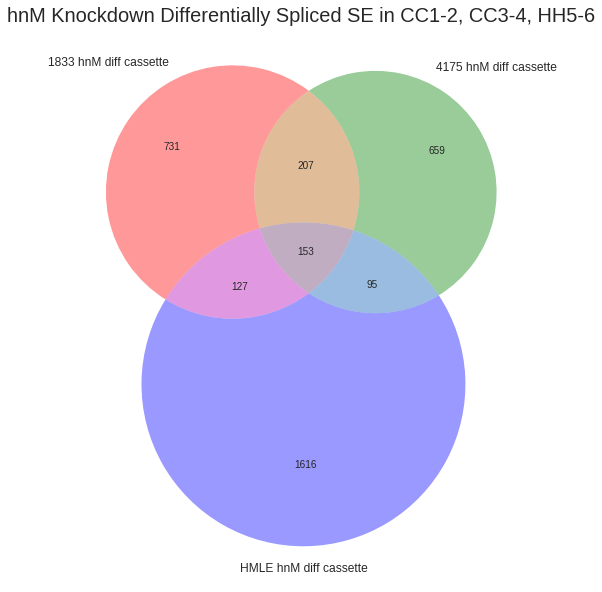

In [759]:
#compare the CC1-2 and CC3-CC4 and HH5-HH6 differentially spliced overlap of cassette exons
#So big because we don't have any replicates

plt.figure(figsize=(10,10))
plt.title('hnM Knockdown Differentially Spliced SE in CC1-2, CC3-4, HH5-6',fontsize=20)
mplv.venn3([set(cc1_cc2_rMATS_df_filtered.splice_id.tolist()),set(cc3_cc4_rMATS_df_filtered.splice_id.tolist()),set(hh5_hh6_rMATS_df_filtered.splice_id.tolist())],set_labels=('1833 hnM diff cassette','4175 hnM diff cassette','HMLE hnM diff cassette'))

In [19]:
#Note - I do not require that the actual genes be identical sets

def collect_and_process_intersection_ids(binding_set,spliced_set,output_prefix):
    #compute intersections
    intersection = binding_set.intersection(spliced_set)
    binding_only = binding_set.difference(spliced_set)
    spliced_only = spliced_set.difference(binding_set)
    #process splice ID to list of ens_genes
    intersection_list = list(intersection)
    intersection_ens_gene_set = set()
    for item in intersection_list:
        item = item.strip().split(':')
        ens_gene = item[6]
        intersection_ens_gene_set.add(ens_gene)
    
    binding_only_list = list(binding_only)
    binding_only_ens_gene_set = set()
    for item in binding_only_list:
        item = item.strip().split(':')
        ens_gene = item[6]
        binding_only_ens_gene_set.add(ens_gene)
    
    spliced_only_list = list(spliced_only)
    spliced_only_ens_gene_set = set()
    for item in spliced_only_list:
        item = item.strip().split(':')
        ens_gene = item[6]
        spliced_only_ens_gene_set.add(ens_gene)
    
    intersection_out = list(intersection_ens_gene_set)
    with open(output_prefix+'/intersection_ens_gene','w') as f:
        for line in intersection_out:
            f.write(line+'\n')            
    binding_only_out = list(binding_only_ens_gene_set)
    with open(output_prefix+'/left_set_only_ens_gene','w') as f:
        for line in binding_only_out:
            f.write(line+'\n')            
    spliced_only_out = list(spliced_only_ens_gene_set)
    with open(output_prefix+'/right_set_only_ens_gene','w') as f:
        for line in spliced_only_out:
            f.write(line+'\n')
            
    #also do a venn3 on these ens_gene_sets
    plt.figure(figsize=(8,8))
    plt.title('Venn between intersection genes, left_set genes, and right_set genes',fontsize=20)
    mplv.venn3([intersection_ens_gene_set,binding_only_ens_gene_set,spliced_only_ens_gene_set],set_labels=('intersection_ens_gene','left_set_only_ens_gene','right_set_only_ens_gene'))

    return 'Done'

'Done'

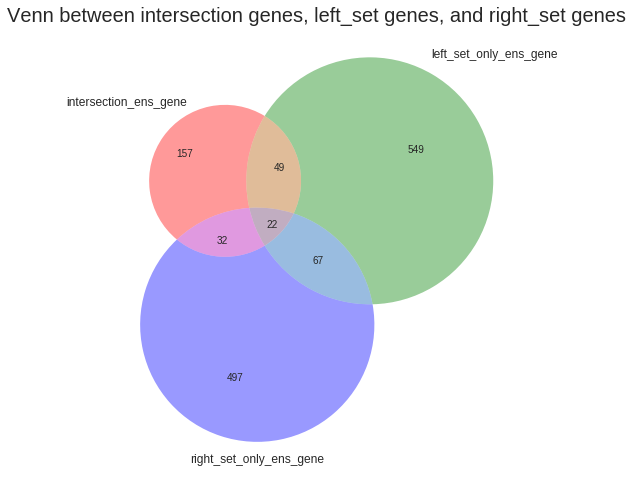

In [20]:
#How many of the cc1_cc2 and cc3_cc4 differences are due to different genes?
#They are actually pretty distinct gene wise...
collect_and_process_intersection_ids(set(cc1_cc2_rMATS_df_filtered.splice_id.tolist()),set(cc3_cc4_rMATS_df_filtered.splice_id.tolist()),'spliced_exon_analysis/cc1_cc2_vs_cc3_cc4_filtered_splice_id_comparison/')

<matplotlib_venn._common.VennDiagram instance at 0x7f66368647a0>

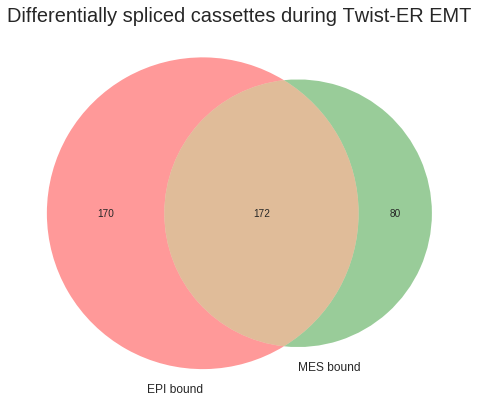

In [150]:
#Compare difference in EPI bound vs. MES bound significantly spliced genes during EMT...
#Consider bringing in the narrowed list when you have rMATS for Snail, TGF-B, etc...
dmso = twist_v_intersect_df_filtered[twist_v_intersect_df_filtered.hnM_DMSO_clip_fpkm_length_norm > 0]
tam = twist_v_intersect_df_filtered[twist_v_intersect_df_filtered.hnM_TAM_clip_fpkm_length_norm > 0]
plt.figure(figsize=(8,8))
plt.title('Differentially spliced cassettes during Twist-ER EMT',fontsize=20)
mplv.venn2([set(dmso.splice_id.tolist()),set(tam.splice_id.tolist())],set_labels=('EPI bound','MES bound'))

'Done'

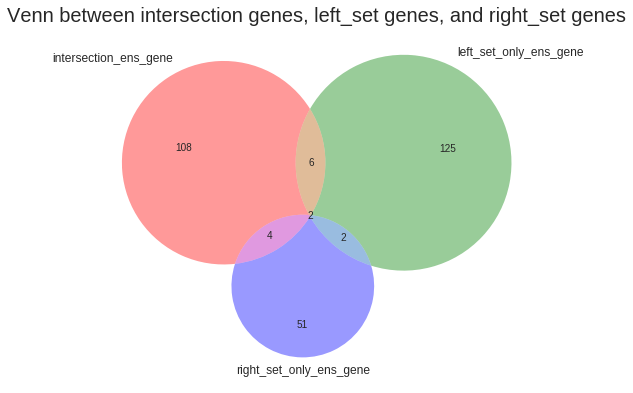

In [151]:
dmso = twist_v_intersect_df_filtered[twist_v_intersect_df_filtered.hnM_DMSO_clip_fpkm_length_norm > 0]
tam = twist_v_intersect_df_filtered[twist_v_intersect_df_filtered.hnM_TAM_clip_fpkm_length_norm > 0]
collect_and_process_intersection_ids(set(dmso.splice_id.tolist()),set(tam.splice_id.tolist()),'spliced_exon_analysis/twist_v_intersect_df_filtered/')

In [156]:
%%time
#write a function to filter the background alternative exons that don't depend on the condition with the following:
#Another set of splicing events that could be used would be the set from the rMATS analysis to intersect with binding would be the set of events with enough read counts with FDR > 0.5 and maxPSI > 0.15 and minPSI < 0.85 and FPKM > 5. (These were the conditions from the Yang et al., 2016 paper)
#Don't implement FPKM yet

#We want the list of alternatively spliced exons, not differentially alternatively spliced. Just don't include the FDR cutoff.

#For this to work, we assume rMATS detects all variable exons within the sample and displays them in the output, and we take the ones that are for sure variable, but do not change between our samples

#Is this even necessary? What if we just include everything

def rMATS_SE_background_exons(intersect_df,FDR,maxPSI,minPSI):
    intersect_df_background = intersect_df[intersect_df.FDR > FDR]
    intersect_df_background = intersect_df_background[(intersect_df_background.inc_level_1_mean > maxPSI) | (intersect_df_background.inc_level_2_mean > maxPSI)]
    intersect_df_background = intersect_df_background[(intersect_df_background.inc_level_1_mean < minPSI) | (intersect_df_background.inc_level_2_mean < minPSI)]
    return intersect_df_background

FDR = 0
maxPSI = 0
minPSI = 1

#Intersect backgrounds
twist_v_intersect_df_background = rMATS_SE_background_exons(twist_v_intersect_df_gene_merge,FDR,maxPSI,minPSI)
cc1_cc2_v_intersect_df_background = rMATS_SE_background_exons(cc1_cc2_v_intersect_df_gene_merge,FDR,maxPSI,minPSI)
cc3_cc4_v_intersect_df_background = rMATS_SE_background_exons(cc3_cc4_v_intersect_df_gene_merge,FDR,maxPSI,minPSI)
hh5_hh6_v_intersect_df_background = rMATS_SE_background_exons(hh5_hh6_v_intersect_df_gene_merge,FDR,maxPSI,minPSI)

#Regular backgrounds from output
twist_rMATS_df_background = rMATS_SE_background_exons(twist_rMATS_df,FDR,maxPSI,minPSI)
cc1_cc2_rMATS_df_background = rMATS_SE_background_exons(cc1_cc2_rMATS_df,FDR,maxPSI,minPSI)
cc3_cc4_rMATS_df_background = rMATS_SE_background_exons(cc3_cc4_rMATS_df,FDR,maxPSI,minPSI)
hh5_hh6_rMATS_df_background = rMATS_SE_background_exons(hh5_hh6_rMATS_df,FDR,maxPSI,minPSI)

#how much do the backgrounds overlap? Try a 4 way venn diagram
#Intersect backgrounds
twist_v_intersect_df_background.splice_id.to_csv('spliced_exon_analysis/twist_v_intersect_df_background',index=False,header=True)
cc1_cc2_v_intersect_df_background.splice_id.to_csv('spliced_exon_analysis/cc1_cc2_v_intersect_df_background',index=False,header=True)
cc3_cc4_v_intersect_df_background.splice_id.to_csv('spliced_exon_analysis/cc3_cc4_v_intersect_df_background',index=False,header=True)
hh5_hh6_v_intersect_df_background.splice_id.to_csv('spliced_exon_analysis/hh5_hh6_v_intersect_df_background',index=False,header=True)

#Regular backgrounds
twist_rMATS_df_background.splice_id.to_csv('spliced_exon_analysis/twist_rMATS_df_background',index=False,header=True)
cc1_cc2_rMATS_df_background.splice_id.to_csv('spliced_exon_analysis/cc1_cc2_rMATS_df_background',index=False,header=True)
cc3_cc4_rMATS_df_background.splice_id.to_csv('spliced_exon_analysis/cc3_cc4_rMATS_df_background',index=False,header=True)
hh5_hh6_rMATS_df_background.splice_id.to_csv('spliced_exon_analysis/hh5_hh6_rMATS_df_background',index=False,header=True)

CPU times: user 684 ms, sys: 32 ms, total: 716 ms
Wall time: 740 ms


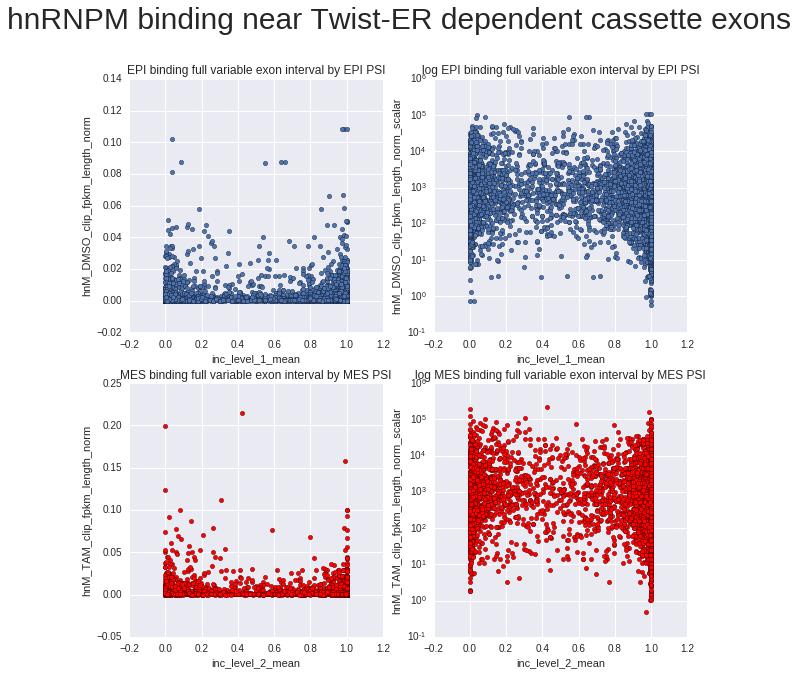

In [505]:
#Now do DMSO with binding
#Here I am using all possible exons identified by rMATS with PSI values. Only filter based on read count, nothing else. This means that as long as rMATS considered it as a variable exon and was able to find enough reads to support it, it is counted

#I am also plotting the gene expression normalized value, not the log ratio

#Make this into a function

def plot_binding_by_delta_psi(x):
    return

#set a log ratio cutoff
log_ratio_cutoff = 0

twist_v_intersect_df_background_ratio_cutoff = twist_v_intersect_df_background[twist_v_intersect_df_background.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio.abs() > log_ratio_cutoff]


fpkm_cutoff = 1
twist_v_intersect_df_background_dmso_gene_cutoff = twist_v_intersect_df_background_ratio_cutoff[twist_v_intersect_df_background_ratio_cutoff.sample_1_fpkm > fpkm_cutoff]

#Select only those bound by in this condition
twist_v_intersect_df_background_dmso_gene_cutoff = twist_v_intersect_df_background_dmso_gene_cutoff[twist_v_intersect_df_background_dmso_gene_cutoff.hnM_DMSO_clip_fpkm_length_norm > 0]

#multiply by a scalar off the minimum and log it.
scalar = 1e6
twist_v_intersect_df_background_dmso_gene_cutoff['hnM_DMSO_clip_fpkm_length_norm_scalar'] = twist_v_intersect_df_background_dmso_gene_cutoff.apply(lambda row: row['hnM_DMSO_clip_fpkm_length_norm']*scalar,axis=1)

#Now do TAM with binding
twist_v_intersect_df_background_tam_gene_cutoff = twist_v_intersect_df_background_ratio_cutoff[twist_v_intersect_df_background_ratio_cutoff.sample_2_fpkm > fpkm_cutoff]

twist_v_intersect_df_background_tam_gene_cutoff = twist_v_intersect_df_background_tam_gene_cutoff[twist_v_intersect_df_background_tam_gene_cutoff.hnM_TAM_clip_fpkm_length_norm > 0]

#multiply by a scalar off the minimum and log it.
scalar = 1e6
twist_v_intersect_df_background_tam_gene_cutoff['hnM_TAM_clip_fpkm_length_norm_scalar'] = twist_v_intersect_df_background_tam_gene_cutoff.apply(lambda row: row['hnM_TAM_clip_fpkm_length_norm']*scalar,axis=1)

#Plotting
fig, ax = plt.subplots(2,2,figsize=(10,10))
plt.suptitle('hnRNPM binding near Twist-ER dependent cassette exons',y=1,fontsize=30)
twist_v_intersect_df_background_dmso_gene_cutoff.plot(kind='scatter',x='inc_level_1_mean',y='hnM_DMSO_clip_fpkm_length_norm',ax=ax[0][0],title='EPI binding full variable exon interval by EPI PSI',fontsize=10)

twist_v_intersect_df_background_dmso_gene_cutoff.plot(kind='scatter',x='inc_level_1_mean',y='hnM_DMSO_clip_fpkm_length_norm_scalar',logy=True,ax=ax[0][1],title='log EPI binding full variable exon interval by EPI PSI',fontsize=10)

twist_v_intersect_df_background_tam_gene_cutoff.plot(kind='scatter',x='inc_level_2_mean',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[1][0],title='MES binding full variable exon interval by MES PSI',fontsize=10,color='r')

twist_v_intersect_df_background_tam_gene_cutoff.plot(kind='scatter',x='inc_level_2_mean',y='hnM_TAM_clip_fpkm_length_norm_scalar',logy=True,ax=ax[1][1],title='log MES binding full variable exon interval by MES PSI',fontsize=10,color='r')

In [508]:
#Plot the twist ER splicng dPSI against the log TAM / DMSO dPSI
twist_v_intersect_df_filtered.describe()

,start,end,inc_level_1_mean,inc_level_2_mean,IncLevelDifference,FDR,SAMPLE_1_AVERAGE_READ,SAMPLE_2_AVERAGE_READ,ID,hnM_DMSO_clip_fpkm_norm,hnM_TAM_clip_fpkm_norm,interval_length,hnM_DMSO_clip_fpkm_length_norm,hnM_TAM_clip_fpkm_length_norm,hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio,sample_1_fpkm,sample_2_fpkm
count,1.102000e+03,1.102000e+03,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1097.000000,1097.000000
mean,7.631240e+07,7.631356e+07,0.526372,0.618314,-0.091942,0.004636,1597.380218,2077.148820,43226.436479,2.913751,3.481236,1162.407441,0.002566,0.003089,-2.035652,71.722038,75.908391
std,5.726402e+07,5.726401e+07,0.302111,0.318018,0.265852,0.010261,8446.484166,27886.353452,25593.017970,8.682485,12.716238,316.210912,0.007689,0.011572,10.707068,208.876399,371.947485
min,1.730050e+05,1.740440e+05,0.000000,0.000000,-0.950000,0.000000,21.000000,20.000000,143.000000,0.000000,0.000000,1012.000000,0.000000,0.000000,-19.082557,0.000000,0.000000
25%,3.336252e+07,3.336365e+07,0.239250,0.330250,-0.252000,0.000000,132.250000,98.250000,19896.250000,0.069785,0.000000,1072.000000,0.000061,0.000000,-13.819162,7.749330,5.880350
50%,6.250667e+07,6.250773e+07,0.550500,0.682000,-0.143000,0.000002,341.500000,270.500000,44059.000000,0.418684,0.254689,1102.000000,0.000378,0.000222,-0.601084,15.461000,17.304900
75%,1.120481e+08,1.120491e+08,0.800750,0.926000,0.132000,0.002246,879.750000,853.000000,66568.750000,1.652256,1.593242,1147.750000,0.001447,0.001439,1.693489,42.970200,48.715900
max,2.473648e+08,2.473659e+08,1.000000,1.000000,0.782000,0.049475,197415.000000,898391.000000,86796.000000,99.821083,227.712536,5414.000000,0.087333,0.215229,19.167910,3169.880000,10456.300000


<matplotlib_venn._common.VennDiagram instance at 0x7f4a3b090758>

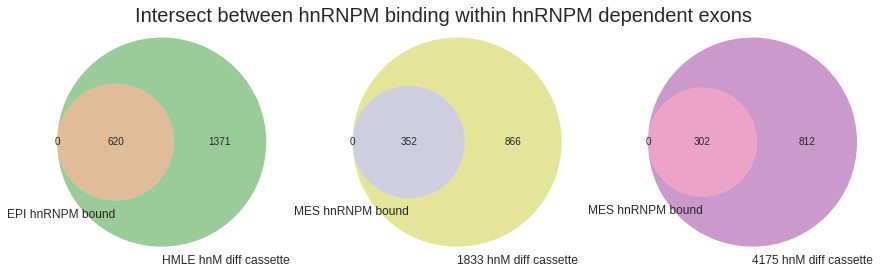

In [189]:
#HERE PLOT THE SUBSETS FOR EACH HNRNPM DEPENDENT SET THAT ARE BOUND BY HNRNPM

fig, ax = plt.subplots(1,3,figsize=(15,10))
fig.suptitle('Intersect between hnRNPM binding within hnRNPM dependent exons',fontsize=20,y=0.7)

cc1_cc2_dmso = cc1_cc2_v_intersect_df_filtered[cc1_cc2_v_intersect_df_filtered.hnM_DMSO_clip_fpkm_length_norm > 0]
cc3_cc4_dmso = cc3_cc4_v_intersect_df_filtered[cc3_cc4_v_intersect_df_filtered.hnM_DMSO_clip_fpkm_length_norm > 0]
hh5_hh6_dmso = hh5_hh6_v_intersect_df_filtered[hh5_hh6_v_intersect_df_filtered.hnM_DMSO_clip_fpkm_length_norm > 0]

cc1_cc2_tam = cc1_cc2_v_intersect_df_filtered[cc1_cc2_v_intersect_df_filtered.hnM_TAM_clip_fpkm_length_norm > 0]
cc3_cc4_tam = cc3_cc4_v_intersect_df_filtered[cc3_cc4_v_intersect_df_filtered.hnM_TAM_clip_fpkm_length_norm > 0]
hh5_hh6_tam = hh5_hh6_v_intersect_df_filtered[hh5_hh6_v_intersect_df_filtered.hnM_TAM_clip_fpkm_length_norm > 0]

mplv.venn2([set(hh5_hh6_dmso.splice_id.tolist()),set(hh5_hh6_rMATS_df_filtered.splice_id.tolist())],set_labels=('EPI hnRNPM bound','HMLE hnM diff cassette'),ax=ax[0])

mplv.venn2([set(cc1_cc2_tam.splice_id.tolist()),set(cc1_cc2_rMATS_df_filtered.splice_id.tolist())],set_labels=('MES hnRNPM bound','1833 hnM diff cassette'),ax=ax[1],set_colors=('b','y'))

mplv.venn2([set(cc3_cc4_tam.splice_id.tolist()),set(cc3_cc4_rMATS_df_filtered.splice_id.tolist())],set_labels=('MES hnRNPM bound','4175 hnM diff cassette'),ax=ax[2],set_colors=('brown','purple'))

0.288998357964
0.171662289837


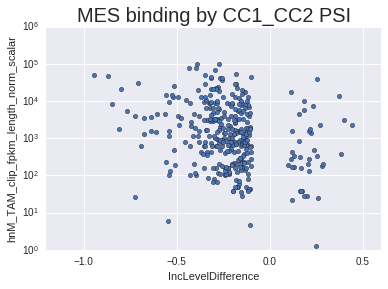

In [387]:
#Per Chonghui's suggestion - plot hnRNPM binding in against hnRNPM dependent delta psi
#Do this first for whole exon, then for other categories as well, including distal introns
fpkm_cutoff = 0
cc1_cc2_v_intersect_df_filtered_gene_cutoff = cc1_cc2_v_intersect_df_filtered
# [cc1_cc2_v_intersect_df_filtered.sample_2_fpkm > fpkm_cutoff]

#Now isolate TAM bound
cc1_cc2_v_intersect_df_filtered_gene_cutoff = cc1_cc2_v_intersect_df_filtered_gene_cutoff[cc1_cc2_v_intersect_df_filtered_gene_cutoff.hnM_TAM_clip_fpkm_length_norm > 0]

#multiply by a scalar off the minimum and log it.
scalar = 1e6
cc1_cc2_v_intersect_df_filtered_gene_cutoff['hnM_TAM_clip_fpkm_length_norm_scalar'] = cc1_cc2_v_intersect_df_filtered_gene_cutoff.apply(lambda row: row['hnM_TAM_clip_fpkm_length_norm']*scalar,axis=1)

#Now plot
cc1_cc2_v_intersect_df_filtered_gene_cutoff.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm_scalar',logy=True)
plt.title('MES binding by CC1_CC2 PSI',fontsize=20)

#separate up and down dPSI
cc1_cc2_v_intersect_df_filtered_gene_cutoff

#calculate the fraction of exons bound and plot as well
sig_frac_bound = float(len(cc1_cc2_v_intersect_df_filtered_gene_cutoff)) / float(len(cc1_cc2_rMATS_df_filtered))
non_sig_frac_bound = float(len(cc1_cc2_v_intersect_df_unchanged)) / float(len(cc1_cc2_rMATS_df_unchanged))

#also calculate the fraction of exons bound that are dPSI positive and negative

print(sig_frac_bound)
print(non_sig_frac_bound)



In [445]:
#also split into quartiles and plot bars for upstream and downstream with dPSI on x axis
#You want the average dPSI for each group
cc1_cc2_v_intersect_df_filtered_gene_cutoff['binding_level'] = pd.qcut(cc1_cc2_v_intersect_df_filtered_gene_cutoff.hnM_TAM_clip_fpkm_length_norm,4,labels=['lowest','low','high','highest'])

quartile_group = cc1_cc2_v_intersect_df_filtered_gene_cutoff.groupby(by='binding_level')

In [ ]:
#Now try to plot fraction of exons relative to unchanged fraction bound. You need to separate upstream from downstream and proximal from distal in general

#Note - proximal and distal are called based on each of the splicing events. It's not like the distal is completely away from all annotated exons, just the exons annotated by the splicing event



cc1_cc2_region_1_intersect_df_filtered
cc1_cc2_region_1_intersect_df_unchanged


In [ ]:
region_1_df_unchanged_pos = region_1_df_unchanged[region_1_df_unchanged.IncLevelDifference > 0]
        region_1_df_unchanged_pos = region_1_df_unchanged[region_1_df_unchanged.IncLevelDifference > 0]
        region_1_df_unchanged_pos = region_1_df_unchanged[region_1_df_unchanged.IncLevelDifference > 0]
        region_1_df_unchanged_pos = region_1_df_unchanged[region_1_df_unchanged.IncLevelDifference > 0]
        
        upstream_int_df_unchanged_pos = upstream_int_df_unchanged[upstream_int_df_unchanged.hnM_DMSO_clip_fpkm_length_norm > 0]
        upstream_distal_int_df_unchanged_pos = upstream_distal_int_df_unchanged[upstream_distal_int_df_unchanged.hnM_DMSO_clip_fpkm_length_norm > 0]
        downstream_int_df_unchanged_pos = downstream_int_df_unchanged[downstream_int_df_unchanged.hnM_DMSO_clip_fpkm_length_norm > 0]
        downstream_distal_int_df_unchanged_pos = downstream_distal_int_df_unchanged[downstream_distal_int_df_unchanged.hnM_DMSO_clip_fpkm_length_norm > 0]
        
        region_1_df_unchanged_neg = region_1_df_unchanged[region_1_df_unchanged.IncLevelDifference < 0]
        region_1_df_unchanged_neg = region_1_df_unchanged[region_1_df_unchanged.IncLevelDifference < 0]
        region_1_df_unchanged_neg = region_1_df_unchanged[region_1_df_unchanged.IncLevelDifference < 0]
        region_1_df_unchanged_neg = region_1_df_unchanged[region_1_df_unchanged.IncLevelDifference < 0]
        
        upstream_int_df_unchanged_neg = upstream_int_df_unchanged[upstream_int_df_unchanged.hnM_DMSO_clip_fpkm_length_norm < 0]
        upstream_distal_int_df_unchanged_neg = upstream_distal_int_df_unchanged[upstream_distal_int_df_unchanged.hnM_DMSO_clip_fpkm_length_norm < 0]
        downstream_int_df_unchanged_neg = downstream_int_df_unchanged[downstream_int_df_unchanged.hnM_DMSO_clip_fpkm_length_norm < 0]
        downstream_distal_int_df_unchanged_neg = downstream_distal_int_df_unchanged[downstream_distal_int_df_unchanged.hnM_DMSO_clip_fpkm_length_norm < 0]

In [ ]:
#Not finished yet
#Purpose of binding fractions would be to show the fraction bound in 

def binding_fractions(region_1_df,region_1_df_unchanged,region_2_df,region_2_df_unchanged,region_3_df,region_3_df_unchanged,region_4_df,region_4_df_unchanged,upstream_int_df,upstream_int_df_unchanged,upstream_distal_int_df,upstream_distal_int_df_unchanged,downstream_int_df,_downstream_int_df_unchanged,downstream_distal_int_df,downstream_distal_int_df_unchanged,rMATS_df,sample_type,sample_name,log_ratio_cutoff,logy):
    #This function will plot the region_1-4 based on filtered intersect dataframes
    #also add introns (4 categories)
    
    #record total number of rMATS_df_events considered
    n = rMATS_df.chr.count()
    
    if sample_type == 'EPI':
        
        #get entries that are enriched by log ratio (remember it is TAM/DMSO), so + = mes and - = epi
        region_1_df = region_1_df[region_1_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        region_2_df = region_2_df[region_2_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        region_3_df = region_3_df[region_3_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        region_4_df = region_4_df[region_4_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        
        upstream_int_df = upstream_int_df[upstream_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        upstream_distal_int_df = upstream_distal_int_df[upstream_distal_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        downstream_int_df = downstream_int_df[downstream_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        downstream_distal_int_df = downstream_distal_int_df[downstream_distal_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        
        #now unchanged
        region_1_df_unchanged = region_1_df_unchanged[region_1_df_unchanged.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        region_2_df_unchanged = region_2_df_unchanged[region_2_df_unchanged.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        region_3_df_unchanged = region_3_df_unchanged[region_3_df_unchanged.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        region_4_df_unchanged = region_4_df_unchanged[region_4_df_unchanged.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        
        upstream_int_df_unchanged = upstream_int_df_unchanged[upstream_int_df_unchanged.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        upstream_distal_int_df_unchanged = upstream_distal_int_df_unchanged[upstream_distal_int_df_unchanged.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        downstream_int_df_unchanged = downstream_int_df_unchanged[downstream_int_df_unchanged.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        downstream_distal_int_df_unchanged = downstream_distal_int_df_unchanged[downstream_distal_int_df_unchanged.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        
        #get entries that are non_zero for the sample type
        region_1_df = region_1_df[region_1_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        region_2_df = region_2_df[region_2_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        region_3_df = region_3_df[region_3_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        region_4_df = region_4_df[region_4_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        
        upstream_int_df = upstream_int_df[upstream_int_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        upstream_distal_int_df = upstream_distal_int_df[upstream_distal_int_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        downstream_int_df = downstream_int_df[downstream_int_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        downstream_distal_int_df = downstream_distal_int_df[downstream_distal_int_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        #now unchanged
        region_1_df_unchanged = region_1_df_unchanged[region_1_df_unchanged.hnM_DMSO_clip_fpkm_length_norm > 0]
        region_2_df_unchanged = region_2_df_unchanged[region_2_df_unchanged.hnM_DMSO_clip_fpkm_length_norm > 0]
        region_3_df_unchanged = region_3_df_unchanged[region_3_df_unchanged.hnM_DMSO_clip_fpkm_length_norm > 0]
        region_4_df_unchanged = region_4_df_unchanged[region_4_df_unchanged.hnM_DMSO_clip_fpkm_length_norm > 0]
        
        upstream_int_df_unchanged = upstream_int_df_unchanged[upstream_int_df_unchanged.hnM_DMSO_clip_fpkm_length_norm > 0]
        upstream_distal_int_df_unchanged = upstream_distal_int_df_unchanged[upstream_distal_int_df_unchanged.hnM_DMSO_clip_fpkm_length_norm > 0]
        downstream_int_df_unchanged = downstream_int_df_unchanged[downstream_int_df_unchanged.hnM_DMSO_clip_fpkm_length_norm > 0]
        downstream_distal_int_df_unchanged = downstream_distal_int_df_unchanged[downstream_distal_int_df_unchanged.hnM_DMSO_clip_fpkm_length_norm > 0]
        
        #split entries into pos and neg
        #pos = splicing factor (or process) promotes inclusion
        #neg = splicing factor (or process) promotes skipping
        region_1_df_pos = region_1_df[region_1_df.IncLevelDifference > 0]
        region_1_df_pos = region_1_df[region_1_df.IncLevelDifference > 0]
        region_1_df_pos = region_1_df[region_1_df.IncLevelDifference > 0]
        region_1_df_pos = region_1_df[region_1_df.IncLevelDifference > 0]
        
        upstream_int_df_pos = upstream_int_df[upstream_int_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        upstream_distal_int_df_pos = upstream_distal_int_df[upstream_distal_int_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        downstream_int_df_pos = downstream_int_df[downstream_int_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        downstream_distal_int_df_pos = downstream_distal_int_df[downstream_distal_int_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        
        region_1_df_neg = region_1_df[region_1_df.IncLevelDifference < 0]
        region_1_df_neg = region_1_df[region_1_df.IncLevelDifference < 0]
        region_1_df_neg = region_1_df[region_1_df.IncLevelDifference < 0]
        region_1_df_neg = region_1_df[region_1_df.IncLevelDifference < 0]
        
        upstream_int_df_neg = upstream_int_df[upstream_int_df.hnM_DMSO_clip_fpkm_length_norm < 0]
        upstream_distal_int_df_neg = upstream_distal_int_df[upstream_distal_int_df.hnM_DMSO_clip_fpkm_length_norm < 0]
        downstream_int_df_neg = downstream_int_df[downstream_int_df.hnM_DMSO_clip_fpkm_length_norm < 0]
        downstream_distal_int_df_neg = downstream_distal_int_df[downstream_distal_int_df.hnM_DMSO_clip_fpkm_length_norm < 0]
        
        #now unchanged
        region_1_df_unchanged_pos = region_1_df_unchanged[region_1_df_unchanged.IncLevelDifference > 0]
        region_1_df_unchanged_pos = region_1_df_unchanged[region_1_df_unchanged.IncLevelDifference > 0]
        region_1_df_unchanged_pos = region_1_df_unchanged[region_1_df_unchanged.IncLevelDifference > 0]
        region_1_df_unchanged_pos = region_1_df_unchanged[region_1_df_unchanged.IncLevelDifference > 0]
        
        upstream_int_df_unchanged_pos = upstream_int_df_unchanged[upstream_int_df_unchanged.hnM_DMSO_clip_fpkm_length_norm > 0]
        upstream_distal_int_df_unchanged_pos = upstream_distal_int_df_unchanged[upstream_distal_int_df_unchanged.hnM_DMSO_clip_fpkm_length_norm > 0]
        downstream_int_df_unchanged_pos = downstream_int_df_unchanged[downstream_int_df_unchanged.hnM_DMSO_clip_fpkm_length_norm > 0]
        downstream_distal_int_df_unchanged_pos = downstream_distal_int_df_unchanged[downstream_distal_int_df_unchanged.hnM_DMSO_clip_fpkm_length_norm > 0]
        
        region_1_df_unchanged_neg = region_1_df_unchanged[region_1_df_unchanged.IncLevelDifference < 0]
        region_1_df_unchanged_neg = region_1_df_unchanged[region_1_df_unchanged.IncLevelDifference < 0]
        region_1_df_unchanged_neg = region_1_df_unchanged[region_1_df_unchanged.IncLevelDifference < 0]
        region_1_df_unchanged_neg = region_1_df_unchanged[region_1_df_unchanged.IncLevelDifference < 0]
        
        upstream_int_df_unchanged_neg = upstream_int_df_unchanged[upstream_int_df_unchanged.hnM_DMSO_clip_fpkm_length_norm < 0]
        upstream_distal_int_df_unchanged_neg = upstream_distal_int_df_unchanged[upstream_distal_int_df_unchanged.hnM_DMSO_clip_fpkm_length_norm < 0]
        downstream_int_df_unchanged_neg = downstream_int_df_unchanged[downstream_int_df_unchanged.hnM_DMSO_clip_fpkm_length_norm < 0]
        downstream_distal_int_df_unchanged_neg = downstream_distal_int_df_unchanged[downstream_distal_int_df_unchanged.hnM_DMSO_clip_fpkm_length_norm < 0]
        
        #plot bar graphs for each filtered vs. unchanged
        fig, ax = plt.subplots(2,4,figsize=(20,10),sharey=True,sharex=True)
        plt.suptitle('Epithelial hnRNPM binding across skipped exon intronic regions: '+sample_name,fontsize=20,y=1)
        region_1_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_DMSO_clip_fpkm_length_norm',ax=ax[0][0],logy=logy,title='region_1 '+str(region_1_df.chr.count())+' out of '+str(n)+' cassettes')
        region_2_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_DMSO_clip_fpkm_length_norm',ax=ax[0][1],logy=logy,title='region_2 '+str(region_2_df.chr.count())+' out of '+str(n)+' cassettes')
        region_3_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_DMSO_clip_fpkm_length_norm',ax=ax[0][2],logy=logy,title='region_3 '+str(region_3_df.chr.count())+' out of '+str(n)+' cassetes')
        region_4_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_DMSO_clip_fpkm_length_norm',ax=ax[0][3],logy=logy,title='region_4 '+str(region_4_df.chr.count())+' out of '+str(n)+' cassettes')
        
        upstream_int_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_DMSO_clip_fpkm_length_norm',ax=ax[1][0],logy=logy,title='upstream_intron '+str(upstream_int_df.chr.count())+' out of '+str(n)+' cassettes')
        upstream_distal_int_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_DMSO_clip_fpkm_length_norm',ax=ax[1][1],logy=logy,title='upstream_distal_intron '+str(upstream_distal_int_df.chr.count())+' out of '+str(n)+' cassettes')
        downstream_int_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_DMSO_clip_fpkm_length_norm',ax=ax[1][2],logy=logy,title='downstream_intron '+str(downstream_int_df.chr.count())+' out of '+str(n)+' cassettes')
        downstream_distal_int_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_DMSO_clip_fpkm_length_norm',ax=ax[1][3],logy=logy,title='downstream_distal_intron '+str(downstream_distal_int_df.chr.count())+' out of '+str(n)+' cassettes')
        
        return plt.show()

    elif sample_type == 'MES':
        
        #get entries that are enriched by log ratio (remember it is TAM/DMSO), so + = mes and - = epi
        region_1_df = region_1_df[region_1_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        region_2_df = region_2_df[region_2_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        region_3_df = region_3_df[region_3_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        region_4_df = region_4_df[region_4_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        
        upstream_int_df = upstream_int_df[upstream_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        upstream_distal_int_df = upstream_distal_int_df[upstream_distal_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        downstream_int_df = downstream_int_df[downstream_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        downstream_distal_int_df = downstream_distal_int_df[downstream_distal_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        
        #get entries that are non_zero for the sample type
        region_1_df = region_1_df[region_1_df.hnM_TAM_clip_fpkm_length_norm > 0]
        region_2_df = region_2_df[region_2_df.hnM_TAM_clip_fpkm_length_norm > 0]
        region_3_df = region_3_df[region_3_df.hnM_TAM_clip_fpkm_length_norm > 0]
        region_4_df = region_4_df[region_4_df.hnM_TAM_clip_fpkm_length_norm > 0]
        
        upstream_int_df = upstream_int_df[upstream_int_df.hnM_TAM_clip_fpkm_length_norm > 0]
        upstream_distal_int_df = upstream_distal_int_df[upstream_distal_int_df.hnM_TAM_clip_fpkm_length_norm > 0]
        downstream_int_df = downstream_int_df[downstream_int_df.hnM_TAM_clip_fpkm_length_norm > 0]
        downstream_distal_int_df = downstream_distal_int_df[downstream_distal_int_df.hnM_TAM_clip_fpkm_length_norm > 0]
        
        #plot
        fig, ax = plt.subplots(2,4,figsize=(20,10),sharey=True,sharex=True)
        plt.suptitle('Mesenchymal hnRNPM binding across skipped exon intronic regions: '+sample_name,fontsize=20,y=1)
        region_1_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[0][0],logy=logy,title='region_1 '+str(region_1_df.chr.count())+' out of '+str(n)+' cassettes')
        region_2_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[0][1],logy=logy,title='region_2 '+str(region_2_df.chr.count())+' out of '+str(n)+' cassettes')
        region_3_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[0][2],logy=logy,title='region_3 '+str(region_3_df.chr.count())+' out of '+str(n)+' cassetes')
        region_4_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[0][3],logy=logy,title='region_4 '+str(region_4_df.chr.count())+' out of '+str(n)+' cassettes')
        
        upstream_int_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[1][0],logy=logy,title='upstream_intron '+str(upstream_int_df.chr.count())+' out of '+str(n)+' cassettes')
        upstream_distal_int_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[1][1],logy=logy,title='upstream_distal_intron '+str(upstream_distal_int_df.chr.count())+' out of '+str(n)+' cassettes')
        downstream_int_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[1][2],logy=logy,title='downstream_intron '+str(downstream_int_df.chr.count())+' out of '+str(n)+' cassettes')
        downstream_distal_int_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[1][3],logy=logy,title='downstream_distal_intron '+str(downstream_distal_int_df.chr.count())+' out of '+str(n)+' cassettes')
                
        return plt.show()   
        
    

In [755]:
#need to separate by inclusion and exclusion to get this to work
#just double the number of columns and have the plots right next to each other

#which is significant? Just do a wilcoxon rank sum test of low vs. high and plot as a table
def wilcoxon_lowest_vs_highest(dataframe):
    values_per_group = [col for col_name, col in dataframe.groupby(by='binding_level')['IncLevelDifference']]
    (stat,p) = stats.ranksums(values_per_group[0],values_per_group[3])
    return p    

def sep_inc_exc(dataframe):
    inc = dataframe[dataframe.IncLevelDifference > 0]
    exc = dataframe[dataframe.IncLevelDifference < 0]
    return(inc,exc)

def quartile_binding_boxplots(region_1_df,region_2_df,region_3_df,region_4_df,upstream_int_df,upstream_distal_int_df,downstream_int_df,downstream_distal_int_df,rMATS_df,sample_type,sample_name,log_ratio_cutoff):
    #This function will plot quartiles based on regions
    
    #record total number of rMATS_df_events considered
    n = rMATS_df.chr.count()
    
    if sample_type == 'EPI':
        
        #get entries that are enriched by log ratio (remember it is TAM/DMSO), so + = mes and - = epi
        region_1_df = region_1_df[region_1_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        region_2_df = region_2_df[region_2_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        region_3_df = region_3_df[region_3_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        region_4_df = region_4_df[region_4_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        
        upstream_int_df = upstream_int_df[upstream_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        upstream_distal_int_df = upstream_distal_int_df[upstream_distal_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        downstream_int_df = downstream_int_df[downstream_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        downstream_distal_int_df = downstream_distal_int_df[downstream_distal_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        
        #get entries that are non_zero for the sample type
        region_1_df = region_1_df[region_1_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        region_2_df = region_2_df[region_2_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        region_3_df = region_3_df[region_3_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        region_4_df = region_4_df[region_4_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        
        upstream_int_df = upstream_int_df[upstream_int_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        upstream_distal_int_df = upstream_distal_int_df[upstream_distal_int_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        downstream_int_df = downstream_int_df[downstream_int_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        downstream_distal_int_df = downstream_distal_int_df[downstream_distal_int_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        #groupby_quartile
        region_1_df['binding_level'] = pd.qcut(region_1_df.hnM_DMSO_clip_fpkm_length_norm,4,labels=['lowest','low','high','highest'])
        region_2_df['binding_level'] = pd.qcut(region_2_df.hnM_DMSO_clip_fpkm_length_norm,4,labels=['lowest','low','high','highest'])
        region_3_df['binding_level'] = pd.qcut(region_3_df.hnM_DMSO_clip_fpkm_length_norm,4,labels=['lowest','low','high','highest'])
        region_4_df['binding_level'] = pd.qcut(region_4_df.hnM_DMSO_clip_fpkm_length_norm,4,labels=['lowest','low','high','highest'])
        
        upstream_int_df['binding_level'] = pd.qcut(upstream_int_df.hnM_DMSO_clip_fpkm_length_norm,4,labels=['lowest','low','high','highest'])
        upstream_distal_int_df['binding_level'] = pd.qcut(upstream_distal_int_df.hnM_DMSO_clip_fpkm_length_norm,4,labels=['lowest','low','high','highest'])
        downstream_int_df['binding_level'] = pd.qcut(downstream_int_df.hnM_DMSO_clip_fpkm_length_norm,4,labels=['lowest','low','high','highest'])
        downstream_distal_int_df['binding_level'] = pd.qcut(downstream_distal_int_df.hnM_DMSO_clip_fpkm_length_norm,4,labels=['lowest','low','high','highest'])
        
        #separate by inc or exc, then plot
        (region_1_df_inc,region_1_df_exc) = sep_inc_exc(region_1_df)
        (region_2_df_inc,region_2_df_exc) = sep_inc_exc(region_2_df)
        (region_3_df_inc,region_3_df_exc) = sep_inc_exc(region_3_df)
        (region_4_df_inc,region_4_df_exc) = sep_inc_exc(region_4_df)
        (upstream_int_df_inc,upstream_int_df_exc) = sep_inc_exc(upstream_int_df)
        (upstream_distal_int_df_inc,upstream_distal_int_df_exc) = sep_inc_exc(upstream_distal_int_df)
        (downstream_int_df_inc,downstream_int_df_exc) = sep_inc_exc(downstream_int_df)
        (downstream_distal_int_df_inc,downstream_distal_int_df_exc) = sep_inc_exc(downstream_distal_int_df)
        
        #plot
        fig, ax = plt.subplots(4,4,figsize=(20,20),sharey=True,sharex=True)
        plt.ylim((-1,1))
        
        region_1_df_inc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[0][0])
        region_1_df_exc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[0][1])
        
        region_2_df_inc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[0][2])
        region_2_df_exc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[0][3])
        
        region_3_df_inc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[1][0])
        region_3_df_exc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[1][1])
        
        region_4_df_inc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[1][2])
        region_4_df_exc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[1][3])
        
        
        upstream_int_df_inc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[2][0])
        upstream_int_df_exc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[2][1])
        
        upstream_distal_int_df_inc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[2][2])
        upstream_distal_int_df_exc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[2][3])
        
        downstream_int_df_inc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[3][0])
        downstream_int_df_exc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[3][1])
        
        downstream_distal_int_df_inc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[3][2])
        downstream_distal_int_df_exc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[3][3])
       
        
        #set_titles
        plt.suptitle('Epithelial hnRNPM binding across skipped exon intronic regions (quartiles of binding intensity): '+sample_name,fontsize=20,y=.95)
        
        ax[0][0].set_title('region_1_INC '+str(region_1_df_inc.chr.count())+' out of '+str(n)+' cassettes')
        ax[0][1].set_title('region_1_EXC '+str(region_1_df_exc.chr.count())+' out of '+str(n)+' cassettes')
        ax[0][2].set_title('region_2_INC '+str(region_2_df_inc.chr.count())+' out of '+str(n)+' cassettes')
        ax[0][3].set_title('region_2_EXC '+str(region_2_df_exc.chr.count())+' out of '+str(n)+' cassettes')
        ax[1][0].set_title('region_3_INC '+str(region_3_df_inc.chr.count())+' out of '+str(n)+' cassettes')
        ax[1][1].set_title('region_3_EXC '+str(region_3_df_exc.chr.count())+' out of '+str(n)+' cassettes')
        ax[1][2].set_title('region_4_INC '+str(region_4_df_inc.chr.count())+' out of '+str(n)+' cassettes')
        ax[1][3].set_title('region_4_EXC '+str(region_4_df_exc.chr.count())+' out of '+str(n)+' cassettes')
        ax[2][0].set_title('upstream intron INC '+str(upstream_int_df_inc.chr.count())+' out of '+str(n)+' cassettes')
        ax[2][1].set_title('upstream intron EXC '+str(upstream_int_df_exc.chr.count())+' out of '+str(n)+' cassettes')
        ax[2][2].set_title('upstream distal intron INC '+str(upstream_distal_int_df_inc.chr.count())+' out of '+str(n)+' cassettes')
        ax[2][3].set_title('upstream distal intron EXC '+str(upstream_distal_int_df_exc.chr.count())+' out of '+str(n)+' cassettes')
        ax[3][0].set_title('downstream intron INC '+str(downstream_int_df_inc.chr.count())+' out of '+str(n)+' cassettes')
        ax[3][1].set_title('downstream intron EXC '+str(downstream_int_df_exc.chr.count())+' out of '+str(n)+' cassettes')
        ax[3][2].set_title('downstream distal intron INC '+str(downstream_distal_int_df_inc.chr.count())+' out of '+str(n)+' cassettes')
        ax[3][3].set_title('downstream distal intron EXC '+str(downstream_distal_int_df_exc.chr.count())+' out of '+str(n)+' cassettes')
        
        #calculate wilcoxon for lowest and highest
        a = wilcoxon_lowest_vs_highest(region_1_df_inc)
        b = wilcoxon_lowest_vs_highest(region_1_df_exc)
        c = wilcoxon_lowest_vs_highest(region_2_df_inc)
        d = wilcoxon_lowest_vs_highest(region_2_df_exc)
        e = wilcoxon_lowest_vs_highest(region_3_df_inc)
        f = wilcoxon_lowest_vs_highest(region_3_df_exc)
        g = wilcoxon_lowest_vs_highest(region_4_df_inc)
        h = wilcoxon_lowest_vs_highest(region_4_df_exc)
        i = wilcoxon_lowest_vs_highest(upstream_int_df_inc)
        j = wilcoxon_lowest_vs_highest(upstream_int_df_exc)
        k = wilcoxon_lowest_vs_highest(upstream_distal_int_df_inc)
        l = wilcoxon_lowest_vs_highest(upstream_distal_int_df_exc)
        m = wilcoxon_lowest_vs_highest(downstream_int_df_inc)
        n = wilcoxon_lowest_vs_highest(downstream_int_df_exc)
        o = wilcoxon_lowest_vs_highest(downstream_distal_int_df_inc)
        p = wilcoxon_lowest_vs_highest(downstream_distal_int_df_exc)
        array = np.array([[a,b,c,d],[e,f,g,h],[i,j,k,l],[m,n,o,p]])
        
        print(array)
        

        return plt.show()

    elif sample_type == 'MES':
        
        #get entries that are enriched by log ratio (remember it is TAM/DMSO), so + = mes and - = epi
        region_1_df = region_1_df[region_1_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        region_2_df = region_2_df[region_2_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        region_3_df = region_3_df[region_3_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        region_4_df = region_4_df[region_4_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        
        upstream_int_df = upstream_int_df[upstream_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        upstream_distal_int_df = upstream_distal_int_df[upstream_distal_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        downstream_int_df = downstream_int_df[downstream_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        downstream_distal_int_df = downstream_distal_int_df[downstream_distal_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        
        #get entries that are non_zero for the sample type
        region_1_df = region_1_df[region_1_df.hnM_TAM_clip_fpkm_length_norm > 0]
        region_2_df = region_2_df[region_2_df.hnM_TAM_clip_fpkm_length_norm > 0]
        region_3_df = region_3_df[region_3_df.hnM_TAM_clip_fpkm_length_norm > 0]
        region_4_df = region_4_df[region_4_df.hnM_TAM_clip_fpkm_length_norm > 0]
        
        upstream_int_df = upstream_int_df[upstream_int_df.hnM_TAM_clip_fpkm_length_norm > 0]
        upstream_distal_int_df = upstream_distal_int_df[upstream_distal_int_df.hnM_TAM_clip_fpkm_length_norm > 0]
        downstream_int_df = downstream_int_df[downstream_int_df.hnM_TAM_clip_fpkm_length_norm > 0]
        downstream_distal_int_df = downstream_distal_int_df[downstream_distal_int_df.hnM_TAM_clip_fpkm_length_norm > 0]
        #groupby_quartile
        region_1_df['binding_level'] = pd.qcut(region_1_df.hnM_TAM_clip_fpkm_length_norm,4,labels=['lowest','low','high','highest'])
        region_2_df['binding_level'] = pd.qcut(region_2_df.hnM_TAM_clip_fpkm_length_norm,4,labels=['lowest','low','high','highest'])
        region_3_df['binding_level'] = pd.qcut(region_3_df.hnM_TAM_clip_fpkm_length_norm,4,labels=['lowest','low','high','highest'])
        region_4_df['binding_level'] = pd.qcut(region_4_df.hnM_TAM_clip_fpkm_length_norm,4,labels=['lowest','low','high','highest'])
        
        upstream_int_df['binding_level'] = pd.qcut(upstream_int_df.hnM_TAM_clip_fpkm_length_norm,4,labels=['lowest','low','high','highest'])
        upstream_distal_int_df['binding_level'] = pd.qcut(upstream_distal_int_df.hnM_TAM_clip_fpkm_length_norm,4,labels=['lowest','low','high','highest'])
        downstream_int_df['binding_level'] = pd.qcut(downstream_int_df.hnM_TAM_clip_fpkm_length_norm,4,labels=['lowest','low','high','highest'])
        downstream_distal_int_df['binding_level'] = pd.qcut(downstream_distal_int_df.hnM_TAM_clip_fpkm_length_norm,4,labels=['lowest','low','high','highest'])
        
        #separate by inc or exc, then plot
        (region_1_df_inc,region_1_df_exc) = sep_inc_exc(region_1_df)
        (region_2_df_inc,region_2_df_exc) = sep_inc_exc(region_2_df)
        (region_3_df_inc,region_3_df_exc) = sep_inc_exc(region_3_df)
        (region_4_df_inc,region_4_df_exc) = sep_inc_exc(region_4_df)
        (upstream_int_df_inc,upstream_int_df_exc) = sep_inc_exc(upstream_int_df)
        (upstream_distal_int_df_inc,upstream_distal_int_df_exc) = sep_inc_exc(upstream_distal_int_df)
        (downstream_int_df_inc,downstream_int_df_exc) = sep_inc_exc(downstream_int_df)
        (downstream_distal_int_df_inc,downstream_distal_int_df_exc) = sep_inc_exc(downstream_distal_int_df)
        
        #plot
        fig, ax = plt.subplots(4,4,figsize=(20,20),sharey=True,sharex=True)
        plt.ylim((-1,1))
        
        region_1_df_inc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[0][0])
        region_1_df_exc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[0][1])
        
        region_2_df_inc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[0][2])
        region_2_df_exc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[0][3])
        
        region_3_df_inc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[1][0])
        region_3_df_exc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[1][1])
        
        region_4_df_inc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[1][2])
        region_4_df_exc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[1][3])
        
        
        upstream_int_df_inc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[2][0])
        upstream_int_df_exc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[2][1])
        
        upstream_distal_int_df_inc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[2][2])
        upstream_distal_int_df_exc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[2][3])
        
        downstream_int_df_inc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[3][0])
        downstream_int_df_exc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[3][1])
        
        downstream_distal_int_df_inc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[3][2])
        downstream_distal_int_df_exc.boxplot(by='binding_level',column='IncLevelDifference',ax=ax[3][3])
       
        
        #set_titles
        plt.suptitle('Mesenchymal hnRNPM binding across skipped exon intronic regions (quartiles of binding intensity): '+sample_name,fontsize=20,y=.95)
        
        ax[0][0].set_title('region_1_INC '+str(region_1_df_inc.chr.count())+' out of '+str(n)+' cassettes')
        ax[0][1].set_title('region_1_EXC '+str(region_1_df_exc.chr.count())+' out of '+str(n)+' cassettes')
        ax[0][2].set_title('region_2_INC '+str(region_2_df_inc.chr.count())+' out of '+str(n)+' cassettes')
        ax[0][3].set_title('region_2_EXC '+str(region_2_df_exc.chr.count())+' out of '+str(n)+' cassettes')
        ax[1][0].set_title('region_3_INC '+str(region_3_df_inc.chr.count())+' out of '+str(n)+' cassettes')
        ax[1][1].set_title('region_3_EXC '+str(region_3_df_exc.chr.count())+' out of '+str(n)+' cassettes')
        ax[1][2].set_title('region_4_INC '+str(region_4_df_inc.chr.count())+' out of '+str(n)+' cassettes')
        ax[1][3].set_title('region_4_EXC '+str(region_4_df_exc.chr.count())+' out of '+str(n)+' cassettes')
        ax[2][0].set_title('upstream intron INC '+str(upstream_int_df_inc.chr.count())+' out of '+str(n)+' cassettes')
        ax[2][1].set_title('upstream intron EXC '+str(upstream_int_df_exc.chr.count())+' out of '+str(n)+' cassettes')
        ax[2][2].set_title('upstream distal intron INC '+str(upstream_distal_int_df_inc.chr.count())+' out of '+str(n)+' cassettes')
        ax[2][3].set_title('upstream distal intron EXC '+str(upstream_distal_int_df_exc.chr.count())+' out of '+str(n)+' cassettes')
        ax[3][0].set_title('downstream intron INC '+str(downstream_int_df_inc.chr.count())+' out of '+str(n)+' cassettes')
        ax[3][1].set_title('downstream intron EXC '+str(downstream_int_df_exc.chr.count())+' out of '+str(n)+' cassettes')
        ax[3][2].set_title('downstream distal intron INC '+str(downstream_distal_int_df_inc.chr.count())+' out of '+str(n)+' cassettes')
        ax[3][3].set_title('downstream distal intron EXC '+str(downstream_distal_int_df_exc.chr.count())+' out of '+str(n)+' cassettes')
        
        #calculate wilcoxon for lowest and highest
        a = wilcoxon_lowest_vs_highest(region_1_df_inc)
        b = wilcoxon_lowest_vs_highest(region_1_df_exc)
        c = wilcoxon_lowest_vs_highest(region_2_df_inc)
        d = wilcoxon_lowest_vs_highest(region_2_df_exc)
        e = wilcoxon_lowest_vs_highest(region_3_df_inc)
        f = wilcoxon_lowest_vs_highest(region_3_df_exc)
        g = wilcoxon_lowest_vs_highest(region_4_df_inc)
        h = wilcoxon_lowest_vs_highest(region_4_df_exc)
        i = wilcoxon_lowest_vs_highest(upstream_int_df_inc)
        j = wilcoxon_lowest_vs_highest(upstream_int_df_exc)
        k = wilcoxon_lowest_vs_highest(upstream_distal_int_df_inc)
        l = wilcoxon_lowest_vs_highest(upstream_distal_int_df_exc)
        m = wilcoxon_lowest_vs_highest(downstream_int_df_inc)
        n = wilcoxon_lowest_vs_highest(downstream_int_df_exc)
        o = wilcoxon_lowest_vs_highest(downstream_distal_int_df_inc)
        p = wilcoxon_lowest_vs_highest(downstream_distal_int_df_exc)
        array = np.array([[a,b,c,d],[e,f,g,h],[i,j,k,l],[m,n,o,p]])
        
        print(array)
        

        return plt.show()

[[ 0.00570612  0.1240264   0.049061    0.20471295]
 [ 0.01042361  0.53344483  0.22421255  0.0289076 ]
 [ 0.6961372   0.57653895  0.86147208  0.38336359]
 [ 0.52915173  0.02935456  0.02356528  0.00325196]]


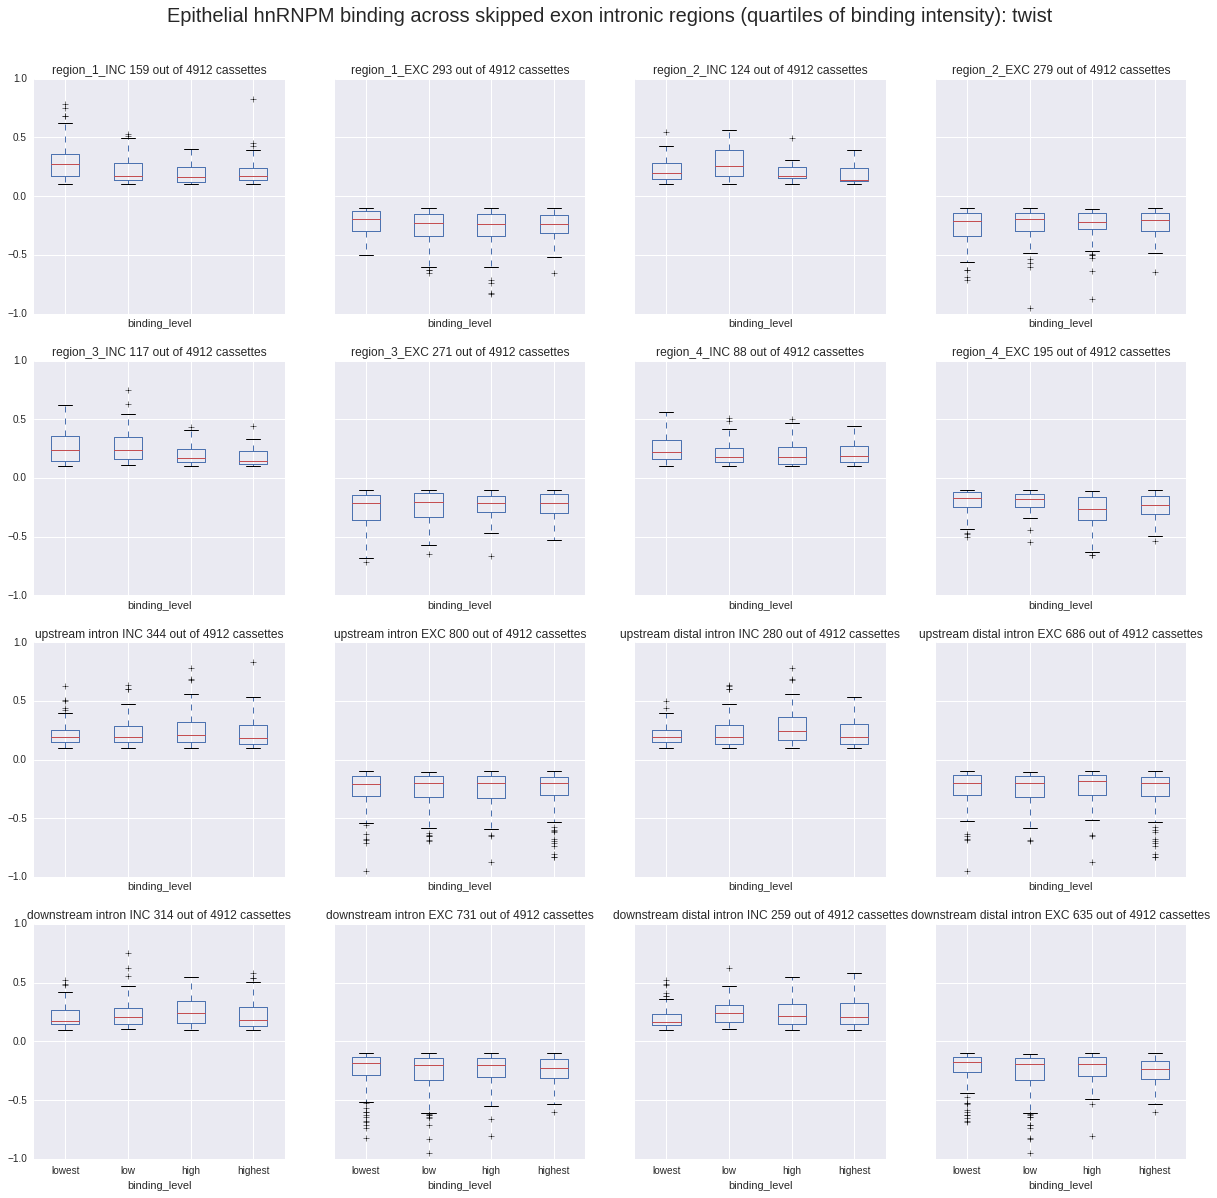

[[ 0.32793149  0.04972537  0.07548071  0.07597649]
 [ 0.00252984  0.00477711  0.90148075  0.41677148]
 [ 0.04042374  0.07482181  0.05010078  0.16783148]
 [ 0.97155849  0.47865126  0.41549248  0.18431887]]


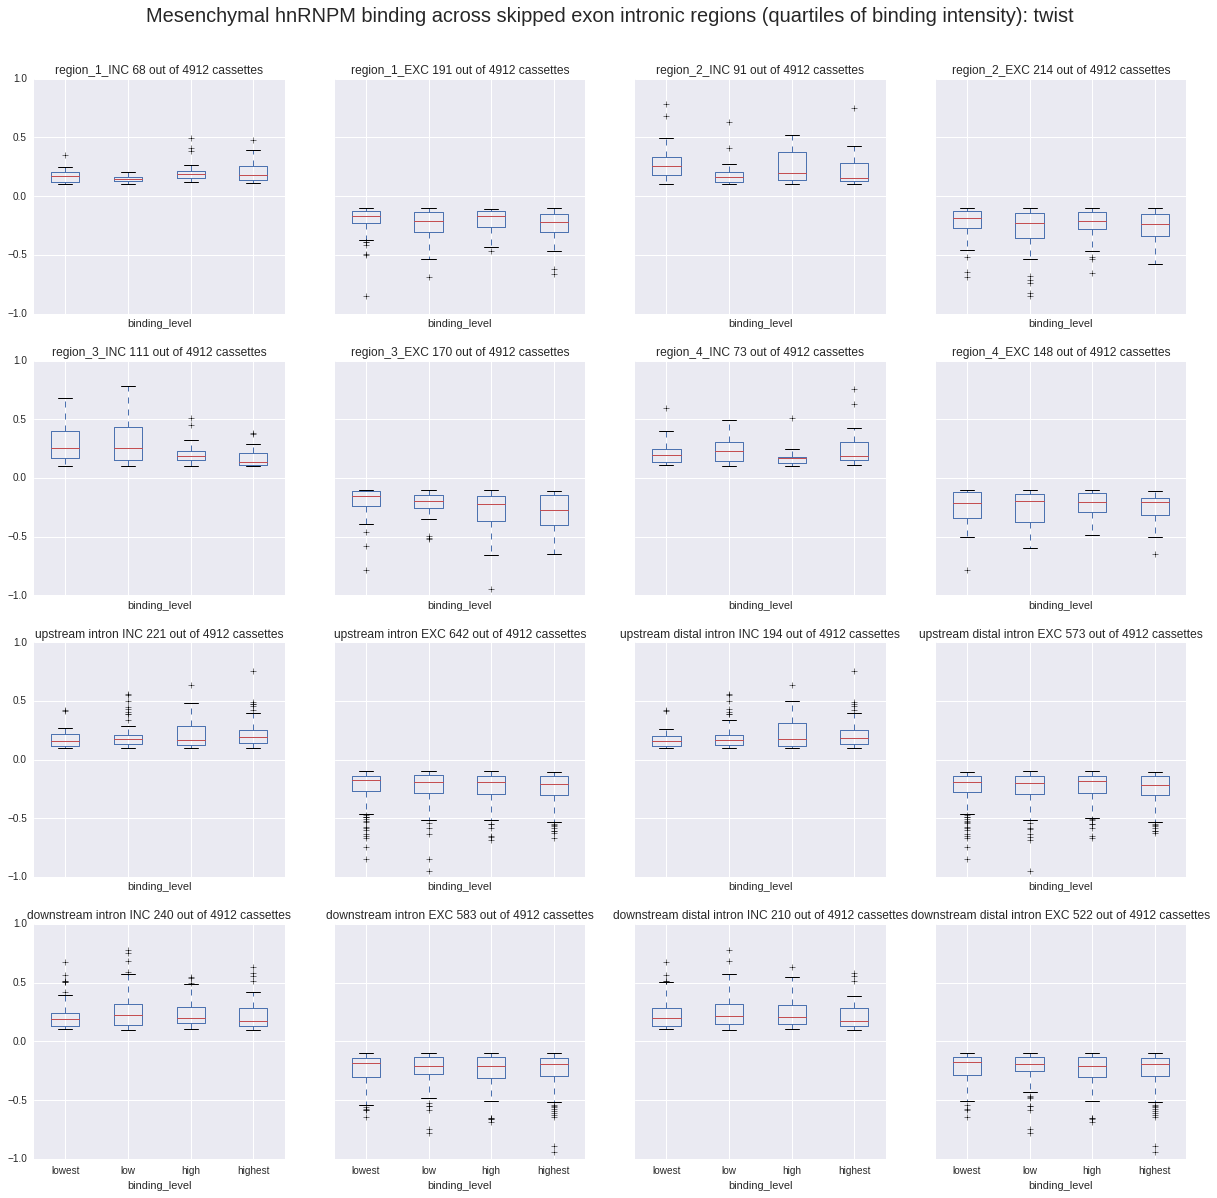

[[        nan  0.0010825          nan  0.07464236]
 [ 0.47950012  0.16366981  0.36131043  0.34607851]
 [ 0.01293282  0.02744201  0.01138136  0.02375182]
 [ 0.03583456  0.08076052  0.09476026  0.10211561]]


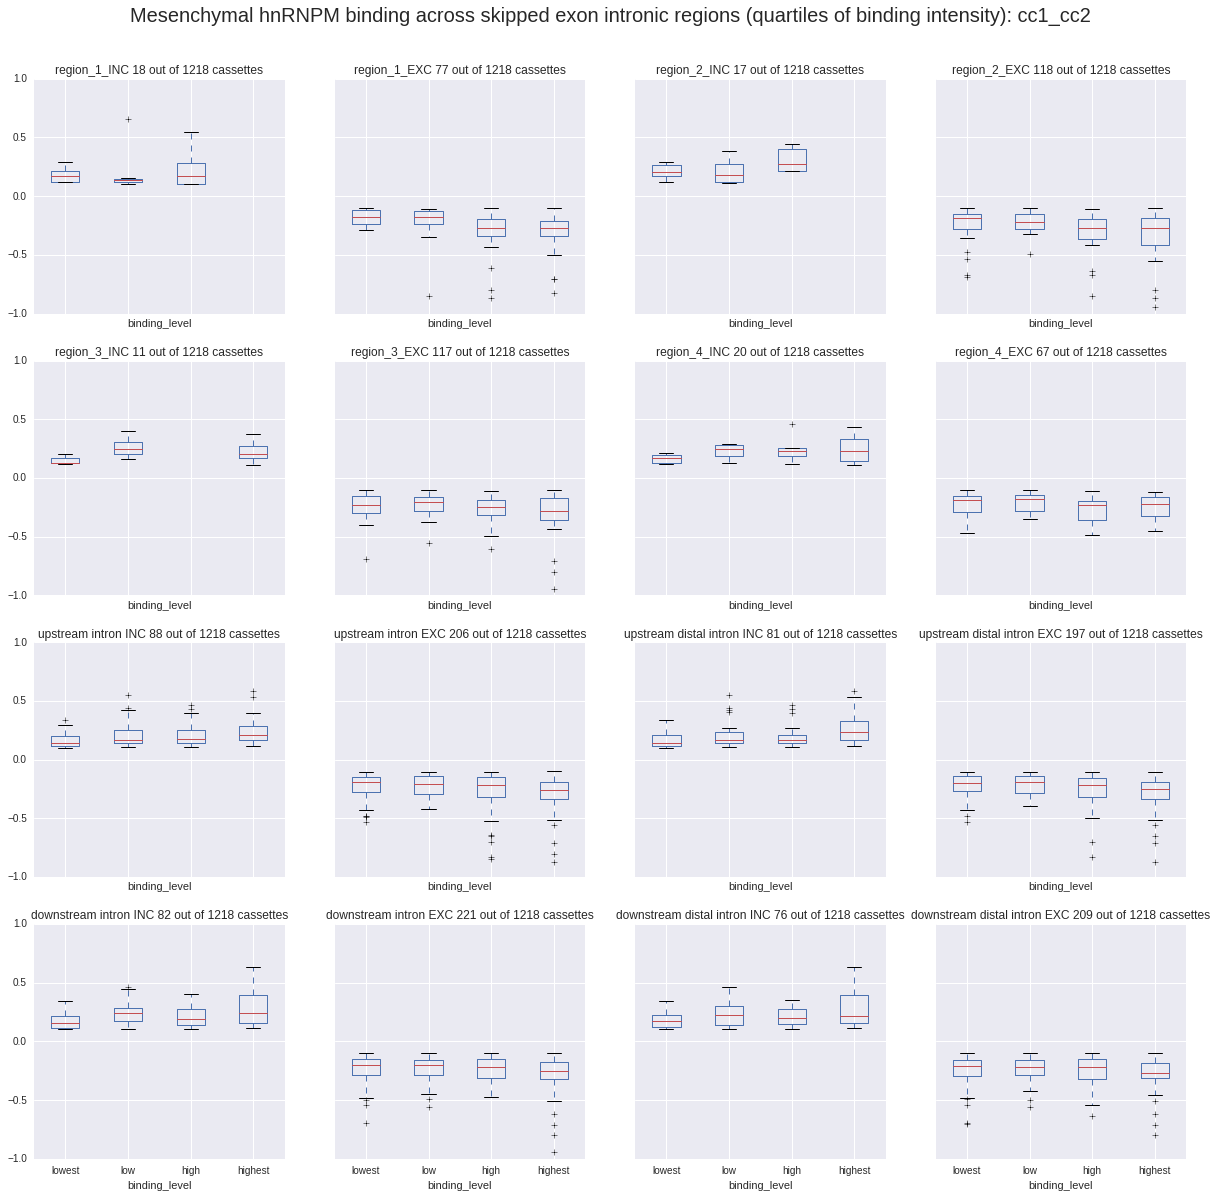

[[ 0.07898258  0.00130259  0.1336144   0.02017114]
 [ 0.24527812  0.00291896  0.47505052  0.03389485]
 [ 0.24580629  0.01906534  0.24290826  0.02156194]
 [ 0.00288416  0.12075915  0.08641073  0.26233846]]


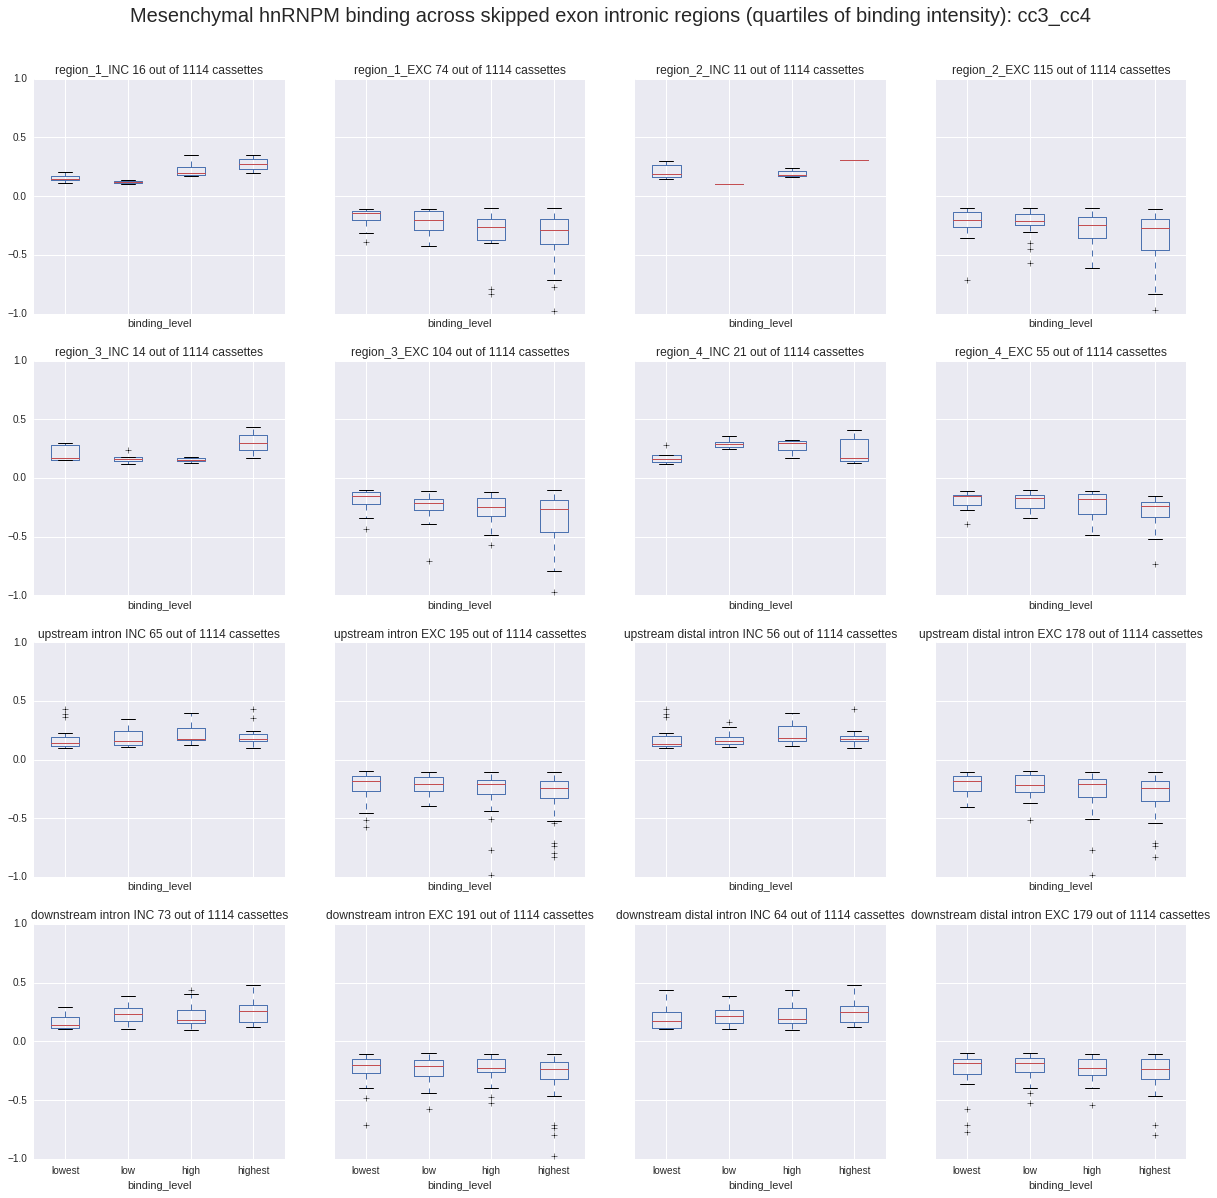

[[  3.11374495e-01   7.38852083e-03   3.91701660e-02   7.10961750e-03]
 [  1.00000000e+00   2.25074219e-02   3.48971653e-01   2.46405144e-05]
 [  1.89883465e-01   6.47549359e-02   1.33209509e-01   7.49457448e-01]
 [  6.28924779e-01   5.11457262e-02   9.11266015e-01   5.79937820e-01]]


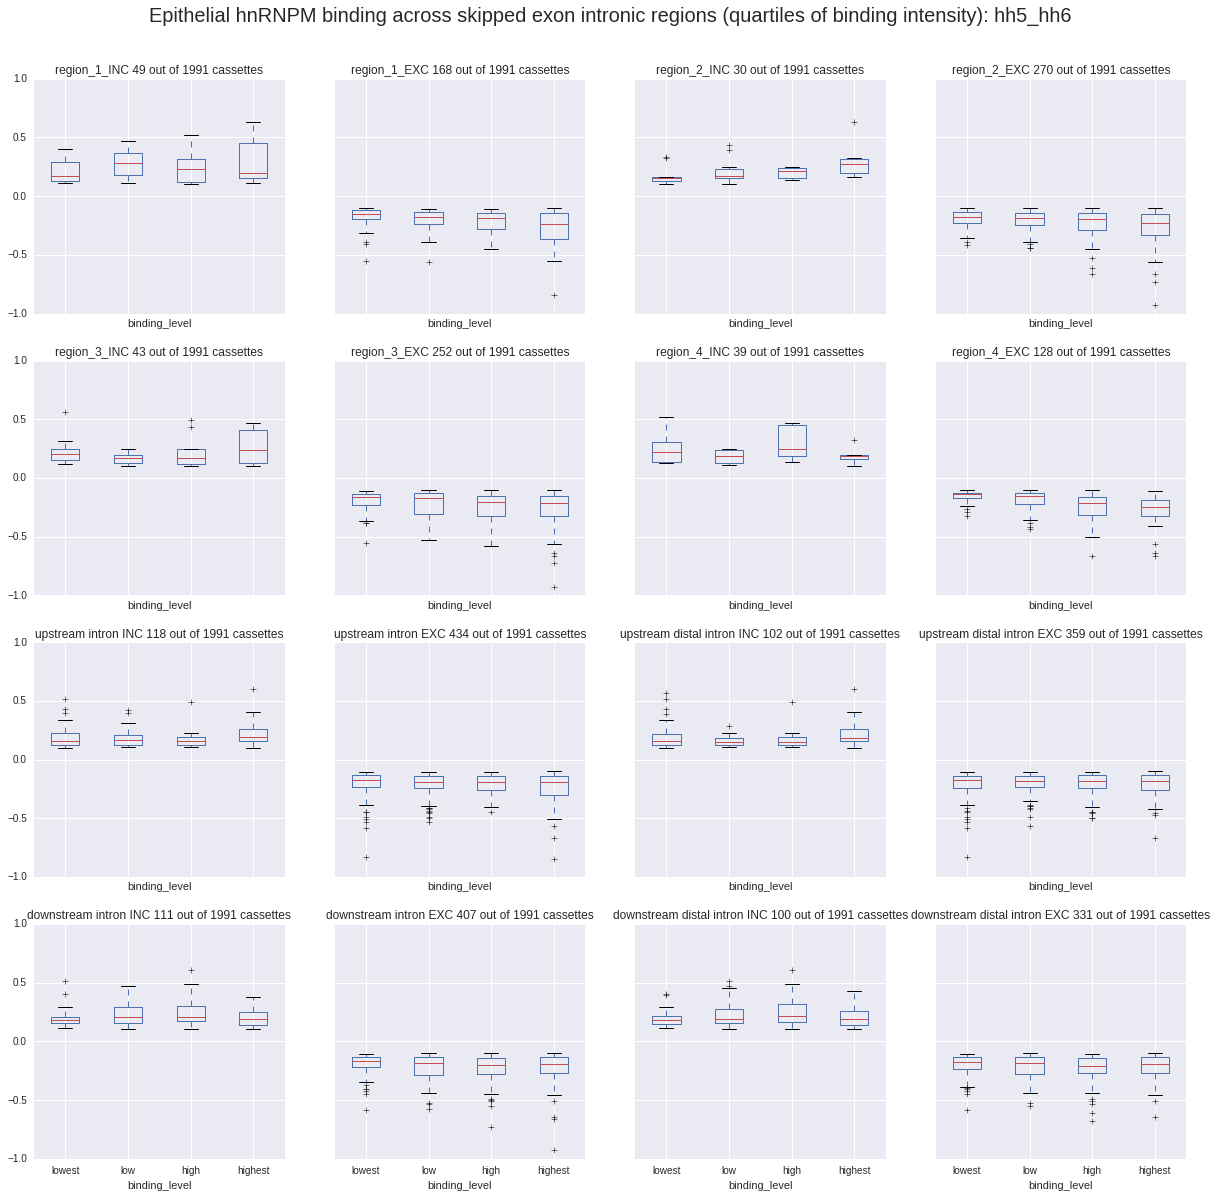

In [758]:
#Plot all of them - these are the quartile box plots
log_ratio_cutoff = 0

quartile_binding_boxplots(twist_region_1_intersect_df_filtered,twist_region_2_intersect_df_filtered,twist_region_3_intersect_df_filtered,twist_region_4_intersect_df_filtered,twist_upstream_int_intersect_df_filtered,twist_upstream_distal_int_intersect_df_filtered,twist_downstream_int_intersect_df_filtered,twist_downstream_distal_int_intersect_df_filtered,twist_rMATS_df_filtered,'EPI','twist',log_ratio_cutoff)

quartile_binding_boxplots(twist_region_1_intersect_df_filtered,twist_region_2_intersect_df_filtered,twist_region_3_intersect_df_filtered,twist_region_4_intersect_df_filtered,twist_upstream_int_intersect_df_filtered,twist_upstream_distal_int_intersect_df_filtered,twist_downstream_int_intersect_df_filtered,twist_downstream_distal_int_intersect_df_filtered,twist_rMATS_df_filtered,'MES','twist',log_ratio_cutoff)

quartile_binding_boxplots(cc1_cc2_region_1_intersect_df_filtered,cc1_cc2_region_2_intersect_df_filtered,cc1_cc2_region_3_intersect_df_filtered,cc1_cc2_region_4_intersect_df_filtered,cc1_cc2_upstream_int_intersect_df_filtered,cc1_cc2_upstream_distal_int_intersect_df_filtered,cc1_cc2_downstream_int_intersect_df_filtered,cc1_cc2_downstream_distal_int_intersect_df_filtered,cc1_cc2_rMATS_df_filtered,'MES','cc1_cc2',log_ratio_cutoff)

quartile_binding_boxplots(cc3_cc4_region_1_intersect_df_filtered,cc3_cc4_region_2_intersect_df_filtered,cc3_cc4_region_3_intersect_df_filtered,cc3_cc4_region_4_intersect_df_filtered,cc3_cc4_upstream_int_intersect_df_filtered,cc3_cc4_upstream_distal_int_intersect_df_filtered,cc3_cc4_downstream_int_intersect_df_filtered,cc3_cc4_downstream_distal_int_intersect_df_filtered,cc3_cc4_rMATS_df_filtered,'MES','cc3_cc4',log_ratio_cutoff)

quartile_binding_boxplots(hh5_hh6_region_1_intersect_df_filtered,hh5_hh6_region_2_intersect_df_filtered,hh5_hh6_region_3_intersect_df_filtered,hh5_hh6_region_4_intersect_df_filtered,hh5_hh6_upstream_int_intersect_df_filtered,hh5_hh6_upstream_distal_int_intersect_df_filtered,hh5_hh6_downstream_int_intersect_df_filtered,hh5_hh6_downstream_distal_int_intersect_df_filtered,hh5_hh6_rMATS_df_filtered,'EPI','hh5_hh6',log_ratio_cutoff)

In [620]:
#write a mini_function to capture the inclusion and exclusion values and separate them
#If you make a two by two table you can do a fisher's exact test or chi square
#scipy.stats.fisher_exact
#scipy.stats.chi2_contingency
# >>> obs = np.array([[10, 10, 20], [20, 20, 20]])
# >>> chi2_contingency(obs)
# (2.7777777777777777,
#  0.24935220877729619,
#  2,
#  array([[ 12.,  12.,  16.],
#         [ 18.,  18.,  24.]]))
import scipy.stats as stats

def inc_exc(dataframe,rMATS_df):
    bound_inc = dataframe[dataframe.IncLevelDifference > 0]
    bound_exc = dataframe[dataframe.IncLevelDifference < 0]
    bound_inc_ratio = float(len(bound_inc))/(float(len(bound_inc))+float(len(bound_exc)))
    total_inc = rMATS_df[rMATS_df.IncLevelDifference > 0]
    total_exc = rMATS_df[rMATS_df.IncLevelDifference < 0]
    total_inc_ratio = float(len(total_inc))/(float(len(total_inc))+float(len(total_exc)))
    #now make a 2x2 table with inclusion and skipping in each condition of bound and unbound
    bound_inc_value = len(bound_inc)
    bound_exc_value = len(bound_exc)
    unbound_inc_value = len(total_inc)-bound_inc_value
    unbound_exc_value = len(total_exc)-bound_exc_value
    unbound_inc_ratio = float(unbound_inc_value)/(float(unbound_inc_value)+float(unbound_exc_value))
    con_table = np.array([[bound_inc_value,bound_exc_value],[unbound_inc_value,unbound_exc_value]])
    (odds,p) = stats.fisher_exact(con_table)
    df = pd.DataFrame(con_table,index=['Bound','Unbound'],columns=['Included','Skipped'])
    df['Inc_Ratio'] = [bound_inc_ratio,unbound_inc_ratio]
    df['P'] = [p,'']
    df_round = df.round(2)
    return (df)

In [710]:
def inc_exc(dataframe,rMATS_df):
    bound_inc = dataframe[dataframe.IncLevelDifference > 0]
    bound_exc = dataframe[dataframe.IncLevelDifference < 0]
    bound_inc_ratio = float(len(bound_inc))/(float(len(bound_inc))+float(len(bound_exc)))
    total_inc = rMATS_df[rMATS_df.IncLevelDifference > 0]
    total_exc = rMATS_df[rMATS_df.IncLevelDifference < 0]
    total_inc_ratio = float(len(total_inc))/(float(len(total_inc))+float(len(total_exc)))
    #now make a 2x2 table with inclusion and skipping in each condition of bound and unbound
    bound_inc_value = len(bound_inc)
    bound_exc_value = len(bound_exc)
    unbound_inc_value = len(total_inc)-bound_inc_value
    unbound_exc_value = len(total_exc)-bound_exc_value
    unbound_inc_ratio = float(unbound_inc_value)/(float(unbound_inc_value)+float(unbound_exc_value))
    con_table = np.array([[bound_inc_value,bound_exc_value],[unbound_inc_value,unbound_exc_value]])
    (odds,p) = stats.fisher_exact(con_table)
    df = pd.DataFrame(con_table,index=['Bound','Unbound'],columns=['Included','Skipped'])
    df['Inc_Ratio'] = [bound_inc_ratio,unbound_inc_ratio]
    df['P'] = [p,'']
    df_round = df.round(2)
    return (df)

def all_binding_regions_by_psi(region_1_df,region_2_df,region_3_df,region_4_df,upstream_int_df,upstream_distal_int_df,downstream_int_df,downstream_distal_int_df,rMATS_df,sample_type,sample_name,log_ratio_cutoff,logy):
    
    from pandas.tools.plotting import table
    
    #This function will plot the region_1-4 based on filtered intersect dataframes
    #also add introns (4 categories)
    
    #record total number of rMATS_df_events considered
    n = rMATS_df.chr.count()
    
    if sample_type == 'EPI':
        
        #get entries that are enriched by log ratio (remember it is TAM/DMSO), so + = mes and - = epi
        region_1_df = region_1_df[region_1_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        region_2_df = region_2_df[region_2_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        region_3_df = region_3_df[region_3_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        region_4_df = region_4_df[region_4_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        
        upstream_int_df = upstream_int_df[upstream_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        upstream_distal_int_df = upstream_distal_int_df[upstream_distal_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        downstream_int_df = downstream_int_df[downstream_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        downstream_distal_int_df = downstream_distal_int_df[downstream_distal_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio <= -log_ratio_cutoff]
        
        #get entries that are non_zero for the sample type
        region_1_df = region_1_df[region_1_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        region_2_df = region_2_df[region_2_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        region_3_df = region_3_df[region_3_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        region_4_df = region_4_df[region_4_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        
        upstream_int_df = upstream_int_df[upstream_int_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        upstream_distal_int_df = upstream_distal_int_df[upstream_distal_int_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        downstream_int_df = downstream_int_df[downstream_int_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        downstream_distal_int_df = downstream_distal_int_df[downstream_distal_int_df.hnM_DMSO_clip_fpkm_length_norm > 0]
        
        #plot scatter plots
        fig, ax = plt.subplots(4,2,figsize=(20,30),sharey=True,sharex=True)
        plt.suptitle('Epithelial hnRNPM binding across skipped exon intronic regions: '+sample_name,fontsize=20,y=0.95)
                
        region_1_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_DMSO_clip_fpkm_length_norm',ax=ax[0][0],logy=logy,title='region_1 '+str(region_1_df.chr.count())+' out of '+str(n)+' cassettes')
        
        region_2_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_DMSO_clip_fpkm_length_norm',ax=ax[0][1],logy=logy,title='region_2 '+str(region_2_df.chr.count())+' out of '+str(n)+' cassettes')
        
        region_3_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_DMSO_clip_fpkm_length_norm',ax=ax[1][0],logy=logy,title='region_3 '+str(region_3_df.chr.count())+' out of '+str(n)+' cassetes')
        
        region_4_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_DMSO_clip_fpkm_length_norm',ax=ax[1][1],logy=logy,title='region_4 '+str(region_4_df.chr.count())+' out of '+str(n)+' cassettes')
        
        upstream_int_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_DMSO_clip_fpkm_length_norm',ax=ax[2][0],logy=logy,title='upstream_intron '+str(upstream_int_df.chr.count())+' out of '+str(n)+' cassettes')
        upstream_distal_int_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_DMSO_clip_fpkm_length_norm',ax=ax[2][1],logy=logy,title='upstream_distal_intron '+str(upstream_distal_int_df.chr.count())+' out of '+str(n)+' cassettes')
        downstream_int_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_DMSO_clip_fpkm_length_norm',ax=ax[3][0],logy=logy,title='downstream_intron '+str(downstream_int_df.chr.count())+' out of '+str(n)+' cassettes')
        downstream_distal_int_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_DMSO_clip_fpkm_length_norm',ax=ax[3][1],logy=logy,title='downstream_distal_intron '+str(downstream_distal_int_df.chr.count())+' out of '+str(n)+' cassettes')
            
                
            
        #add tables
        region_1_tab = inc_exc(region_1_df,rMATS_df)
        region_2_tab = inc_exc(region_2_df,rMATS_df)
        region_3_tab = inc_exc(region_3_df,rMATS_df)
        region_4_tab = inc_exc(region_4_df,rMATS_df)
        
        upstream_int_tab = inc_exc(upstream_int_df,rMATS_df)
        upstream_distal_int_tab = inc_exc(upstream_distal_int_df,rMATS_df)
        downstream_int_tab = inc_exc(downstream_int_df,rMATS_df)
        downstream_distal_int_tab = inc_exc(downstream_distal_int_df,rMATS_df)
        
        #plot tables
        table(ax[0][0],region_1_tab)
        table(ax[0][1],region_2_tab)
        table(ax[1][0],region_3_tab)
        table(ax[1][1],region_4_tab)
        table(ax[2][0],upstream_int_tab)
        table(ax[2][1],upstream_distal_int_tab)
        table(ax[3][0],downstream_int_tab,loc='upper center')
        table(ax[3][1],downstream_distal_int_tab,loc='upper center')
        
        
        return plt.show()

    elif sample_type == 'MES':
        
        #get entries that are enriched by log ratio (remember it is TAM/DMSO), so + = mes and - = epi
        region_1_df = region_1_df[region_1_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        region_2_df = region_2_df[region_2_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        region_3_df = region_3_df[region_3_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        region_4_df = region_4_df[region_4_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        
        upstream_int_df = upstream_int_df[upstream_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        upstream_distal_int_df = upstream_distal_int_df[upstream_distal_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        downstream_int_df = downstream_int_df[downstream_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        downstream_distal_int_df = downstream_distal_int_df[downstream_distal_int_df.hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio >= log_ratio_cutoff]
        
        #get entries that are non_zero for the sample type
        region_1_df = region_1_df[region_1_df.hnM_TAM_clip_fpkm_length_norm > 0]
        region_2_df = region_2_df[region_2_df.hnM_TAM_clip_fpkm_length_norm > 0]
        region_3_df = region_3_df[region_3_df.hnM_TAM_clip_fpkm_length_norm > 0]
        region_4_df = region_4_df[region_4_df.hnM_TAM_clip_fpkm_length_norm > 0]
        
        upstream_int_df = upstream_int_df[upstream_int_df.hnM_TAM_clip_fpkm_length_norm > 0]
        upstream_distal_int_df = upstream_distal_int_df[upstream_distal_int_df.hnM_TAM_clip_fpkm_length_norm > 0]
        downstream_int_df = downstream_int_df[downstream_int_df.hnM_TAM_clip_fpkm_length_norm > 0]
        downstream_distal_int_df = downstream_distal_int_df[downstream_distal_int_df.hnM_TAM_clip_fpkm_length_norm > 0]
        
        #plot scatter plots
        fig, ax = plt.subplots(4,2,figsize=(20,30),sharey=True,sharex=True)
        plt.suptitle('Mesenchymal hnRNPM binding across skipped exon intronic regions: '+sample_name,fontsize=20,y=0.95)
        
        region_1_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[0][0],logy=logy,title='region_1 '+str(region_1_df.chr.count())+' out of '+str(n)+' cassettes')
        
        region_2_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[0][1],logy=logy,title='region_2 '+str(region_2_df.chr.count())+' out of '+str(n)+' cassettes')
        
        region_3_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[1][0],logy=logy,title='region_3 '+str(region_3_df.chr.count())+' out of '+str(n)+' cassetes')
        
        region_4_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[1][1],logy=logy,title='region_4 '+str(region_4_df.chr.count())+' out of '+str(n)+' cassettes')
        
        
        upstream_int_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[2][0],logy=logy,title='upstream_intron '+str(upstream_int_df.chr.count())+' out of '+str(n)+' cassettes')
        upstream_distal_int_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[2][1],logy=logy,title='upstream_distal_intron '+str(upstream_distal_int_df.chr.count())+' out of '+str(n)+' cassettes')
        downstream_int_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[3][0],logy=logy,title='downstream_intron '+str(downstream_int_df.chr.count())+' out of '+str(n)+' cassettes')
        downstream_distal_int_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[3][1],logy=logy,title='downstream_distal_intron '+str(downstream_distal_int_df.chr.count())+' out of '+str(n)+' cassettes')
        
        #add tables
        region_1_tab = inc_exc(region_1_df,rMATS_df)
        region_2_tab = inc_exc(region_2_df,rMATS_df)
        region_3_tab = inc_exc(region_3_df,rMATS_df)
        region_4_tab = inc_exc(region_4_df,rMATS_df)
        
        upstream_int_tab = inc_exc(upstream_int_df,rMATS_df)
        upstream_distal_int_tab = inc_exc(upstream_distal_int_df,rMATS_df)
        downstream_int_tab = inc_exc(downstream_int_df,rMATS_df)
        downstream_distal_int_tab = inc_exc(downstream_distal_int_df,rMATS_df)
        
        #plot tables
        table(ax[0][0],region_1_tab)
        table(ax[0][1],region_2_tab)
        table(ax[1][0],region_3_tab)
        table(ax[1][1],region_4_tab)
        table(ax[2][0],upstream_int_tab)
        table(ax[2][1],upstream_distal_int_tab)
        table(ax[3][0],downstream_int_tab,loc='upper center')
        table(ax[3][1],downstream_distal_int_tab,loc='upper center')
                
        return plt.show()   
        
    

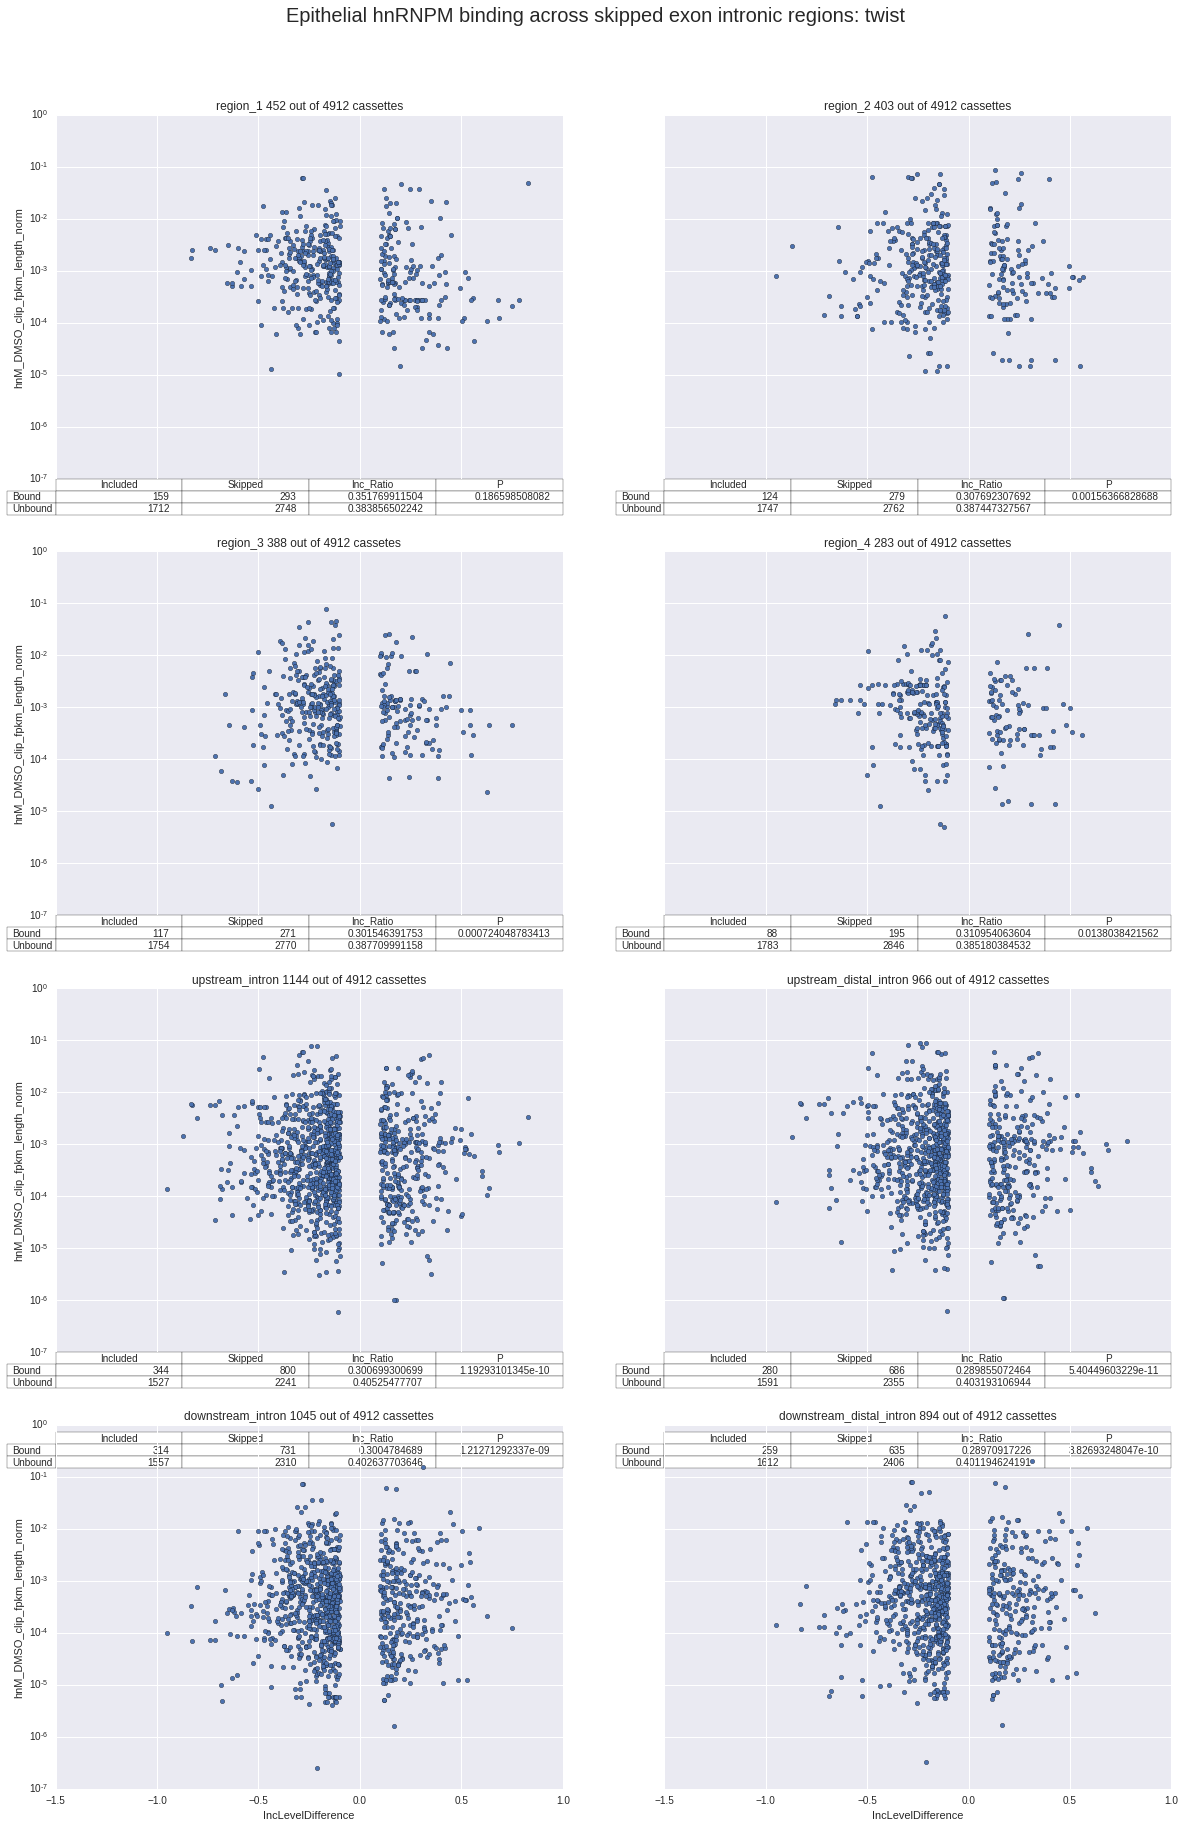

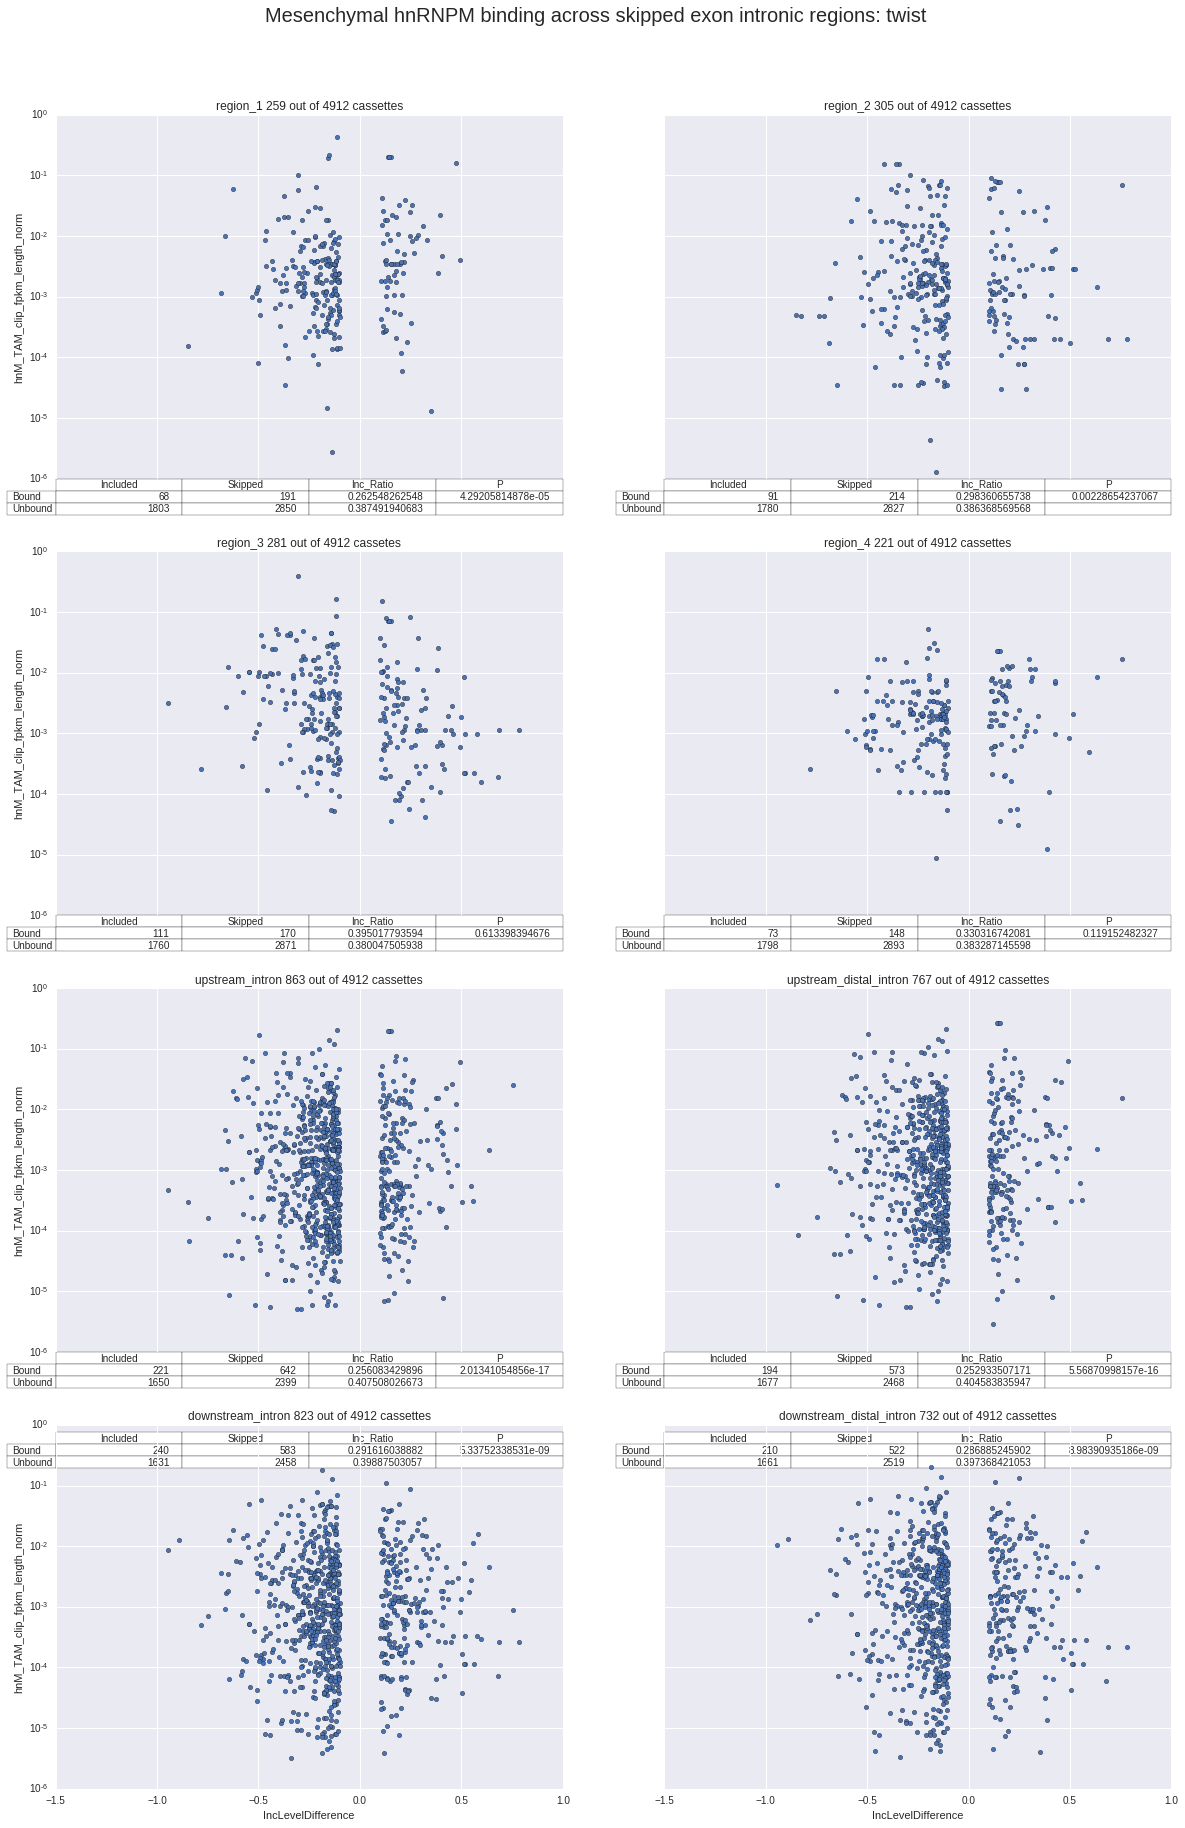

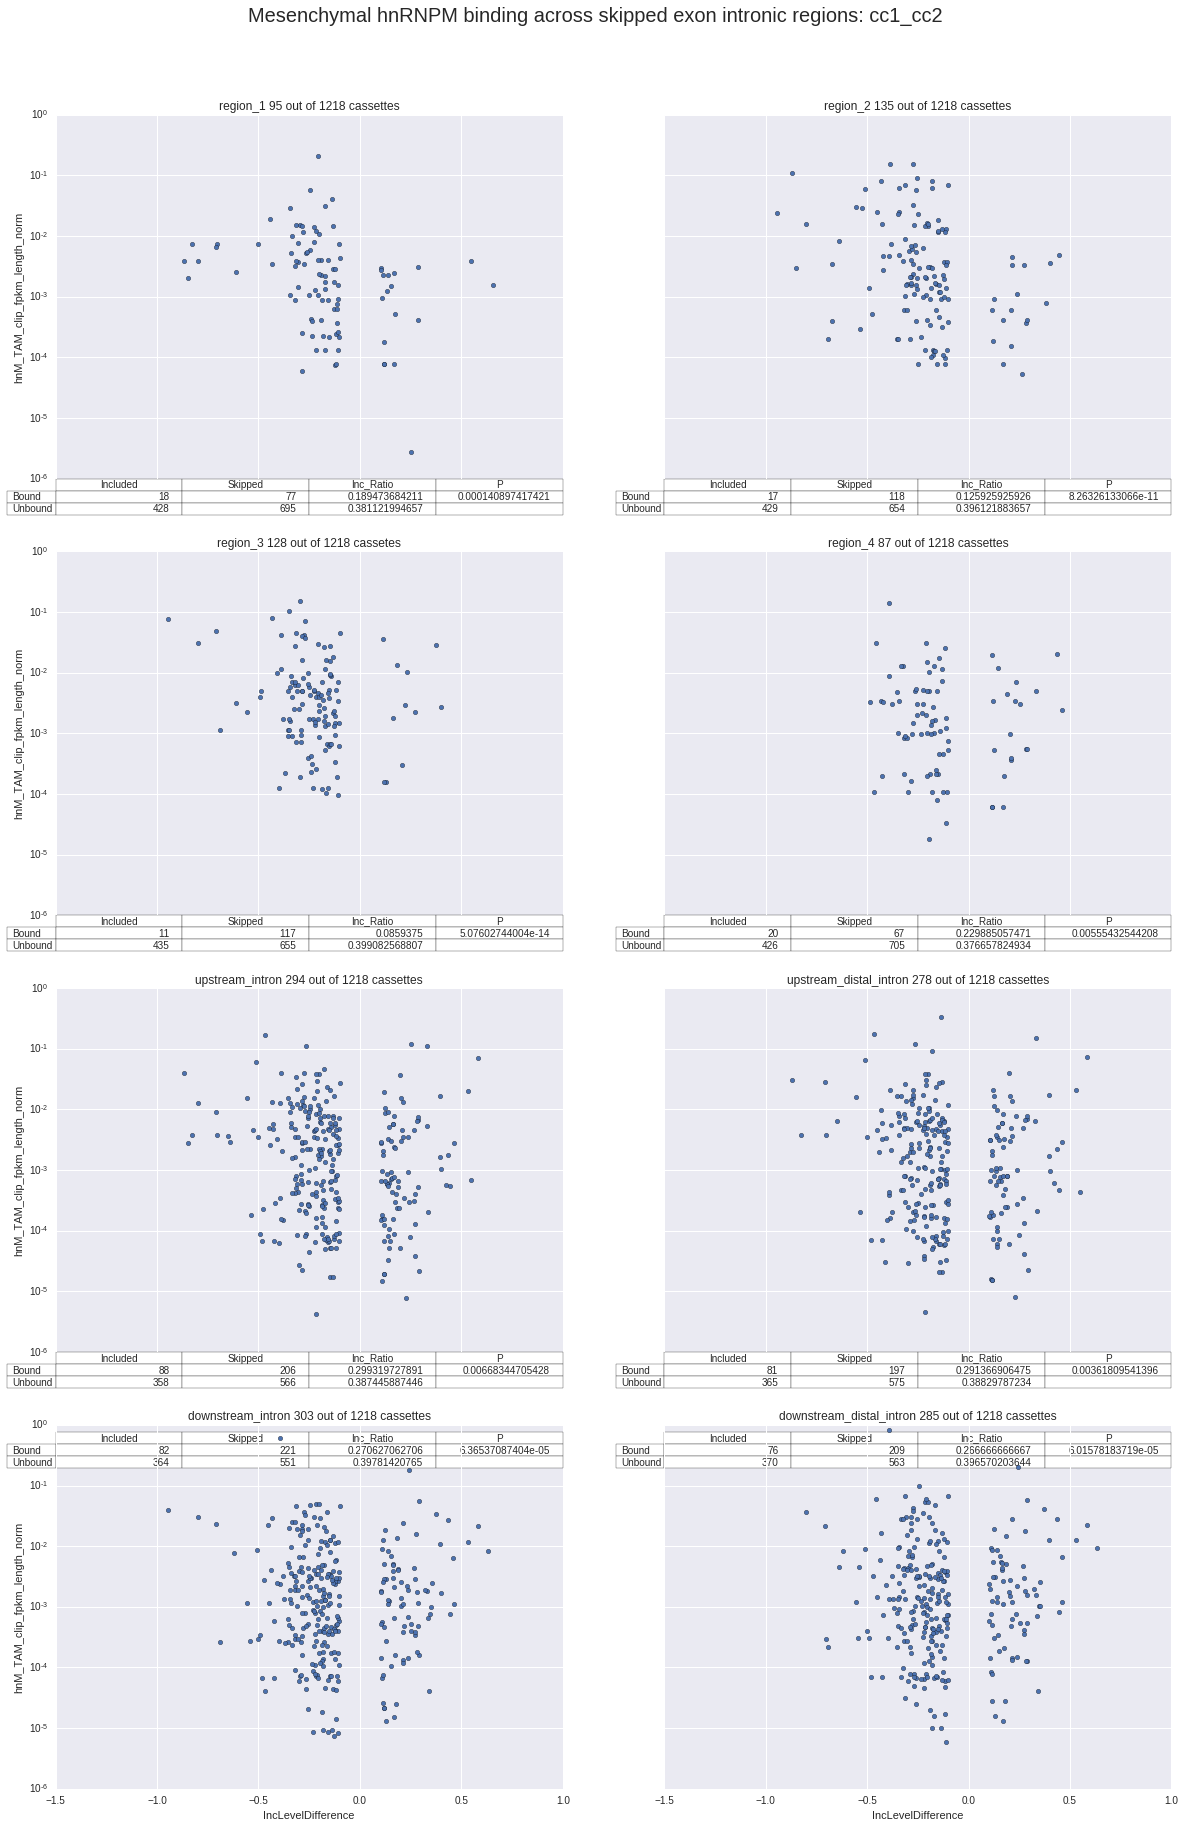

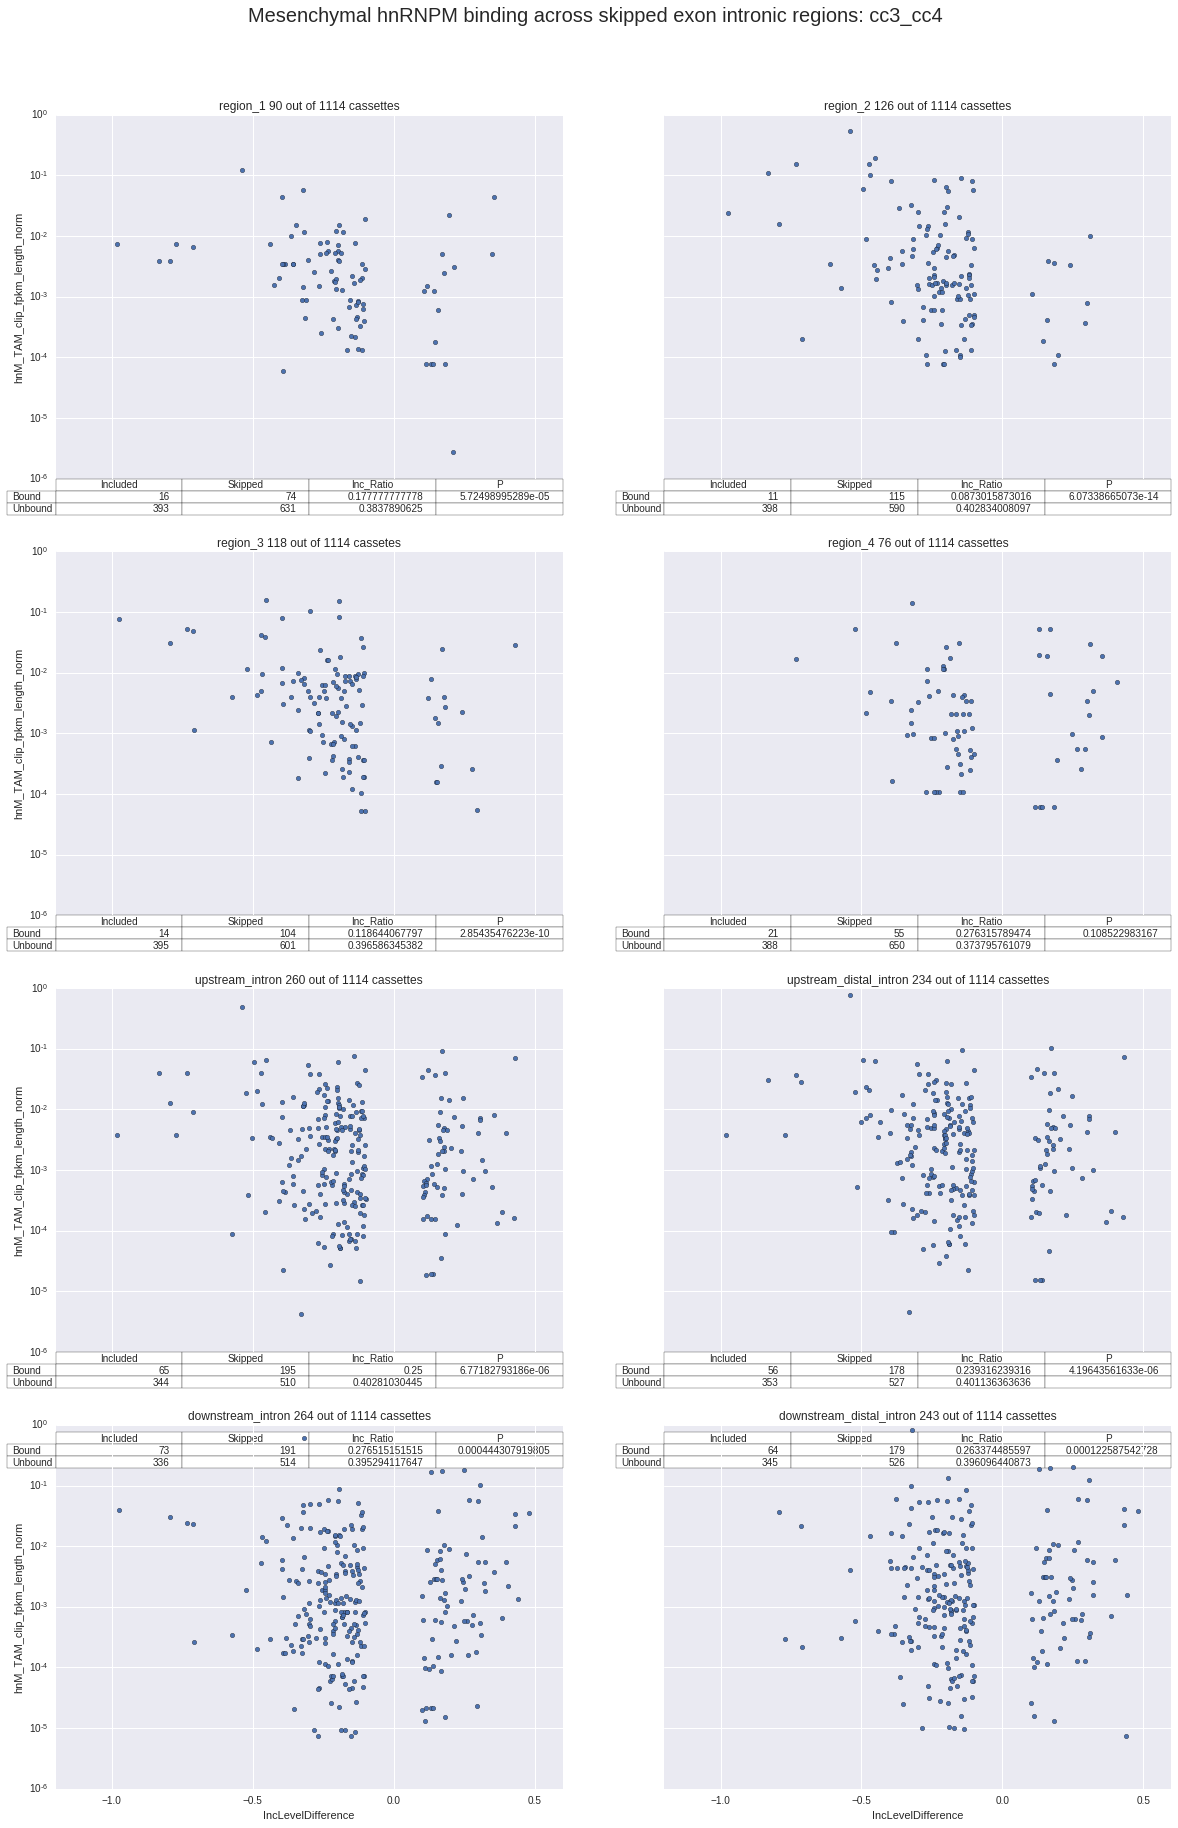

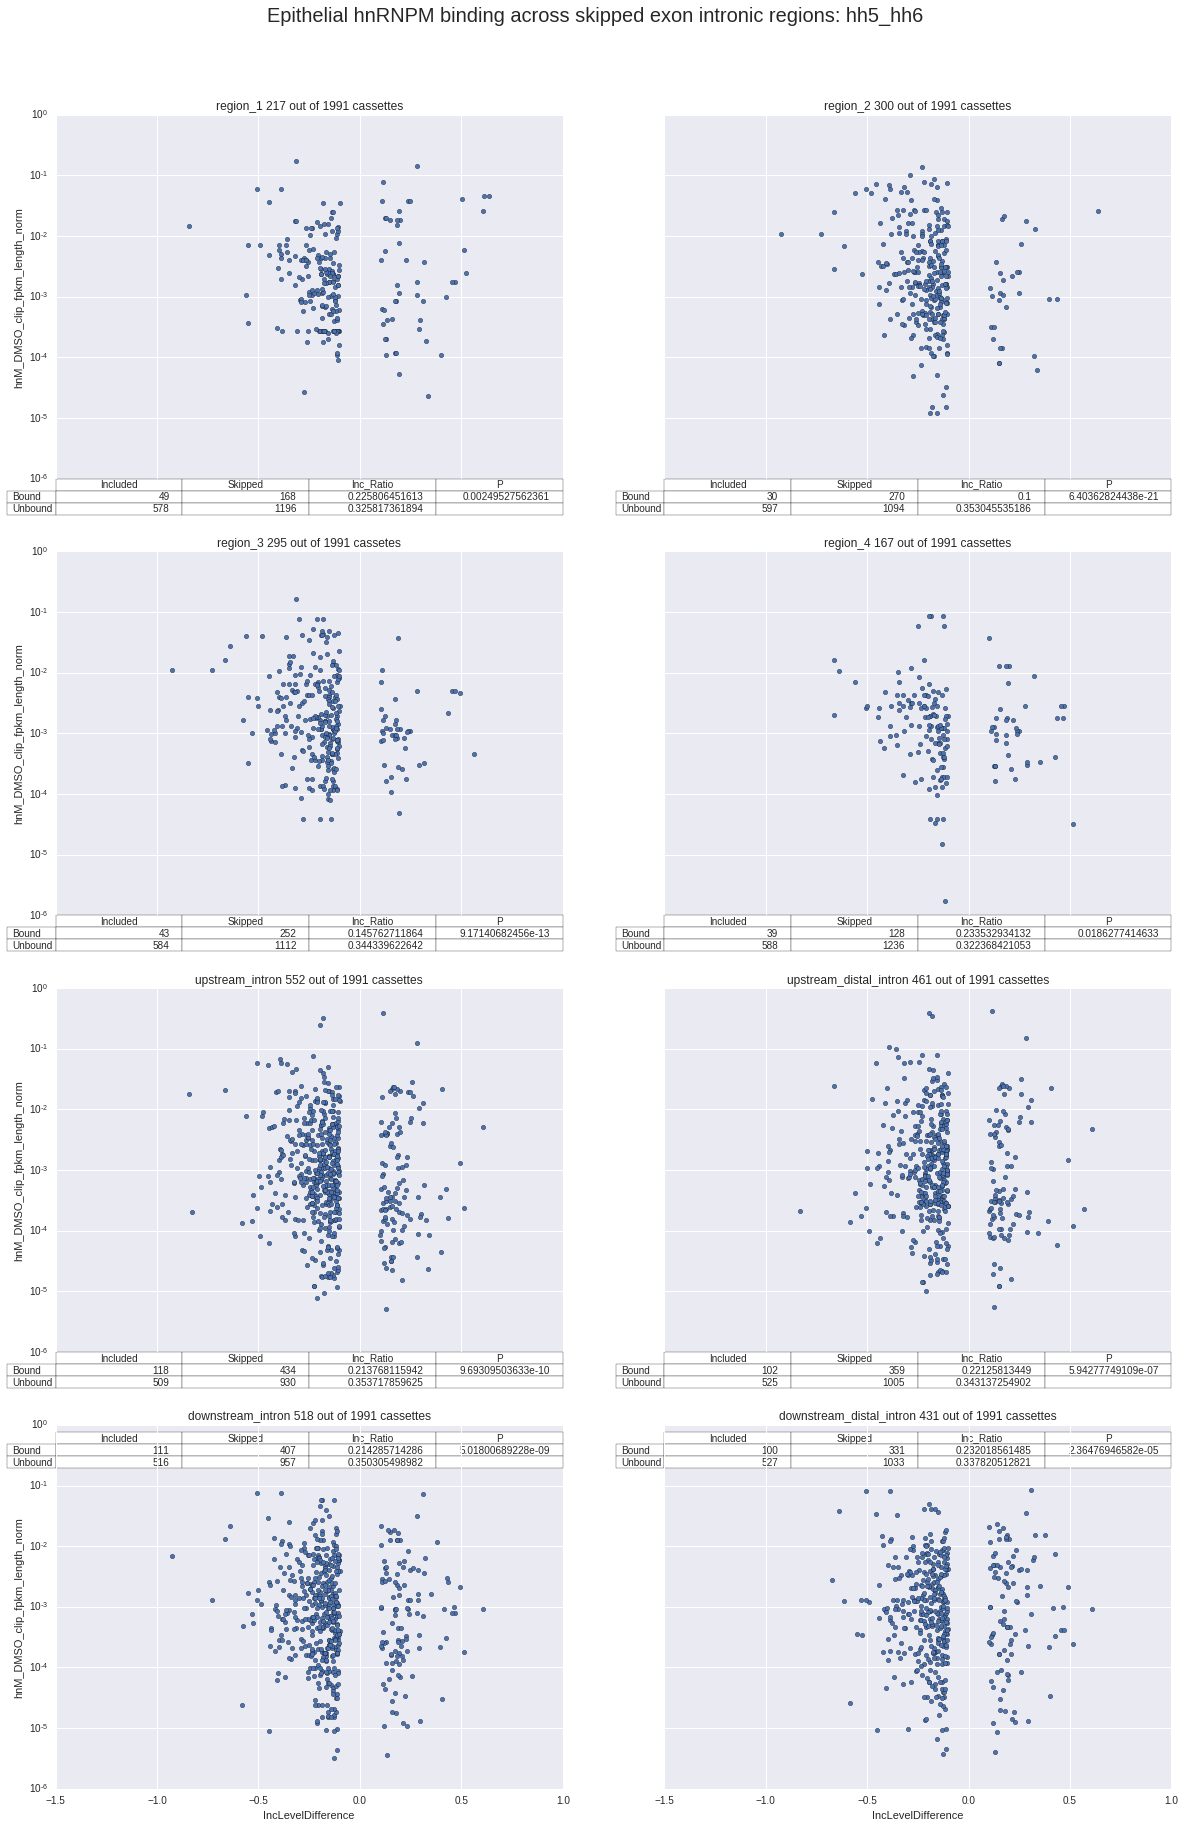

In [712]:
#Plot all of them - these are the actual distribution plots
log_ratio_cutoff = 0
logy = True

all_binding_regions_by_psi(twist_region_1_intersect_df_filtered,twist_region_2_intersect_df_filtered,twist_region_3_intersect_df_filtered,twist_region_4_intersect_df_filtered,twist_upstream_int_intersect_df_filtered,twist_upstream_distal_int_intersect_df_filtered,twist_downstream_int_intersect_df_filtered,twist_downstream_distal_int_intersect_df_filtered,twist_rMATS_df_filtered,'EPI','twist',log_ratio_cutoff,logy)

all_binding_regions_by_psi(twist_region_1_intersect_df_filtered,twist_region_2_intersect_df_filtered,twist_region_3_intersect_df_filtered,twist_region_4_intersect_df_filtered,twist_upstream_int_intersect_df_filtered,twist_upstream_distal_int_intersect_df_filtered,twist_downstream_int_intersect_df_filtered,twist_downstream_distal_int_intersect_df_filtered,twist_rMATS_df_filtered,'MES','twist',log_ratio_cutoff,logy)

all_binding_regions_by_psi(cc1_cc2_region_1_intersect_df_filtered,cc1_cc2_region_2_intersect_df_filtered,cc1_cc2_region_3_intersect_df_filtered,cc1_cc2_region_4_intersect_df_filtered,cc1_cc2_upstream_int_intersect_df_filtered,cc1_cc2_upstream_distal_int_intersect_df_filtered,cc1_cc2_downstream_int_intersect_df_filtered,cc1_cc2_downstream_distal_int_intersect_df_filtered,cc1_cc2_rMATS_df_filtered,'MES','cc1_cc2',log_ratio_cutoff,logy)

all_binding_regions_by_psi(cc3_cc4_region_1_intersect_df_filtered,cc3_cc4_region_2_intersect_df_filtered,cc3_cc4_region_3_intersect_df_filtered,cc3_cc4_region_4_intersect_df_filtered,cc3_cc4_upstream_int_intersect_df_filtered,cc3_cc4_upstream_distal_int_intersect_df_filtered,cc3_cc4_downstream_int_intersect_df_filtered,cc3_cc4_downstream_distal_int_intersect_df_filtered,cc3_cc4_rMATS_df_filtered,'MES','cc3_cc4',log_ratio_cutoff,logy)

all_binding_regions_by_psi(hh5_hh6_region_1_intersect_df_filtered,hh5_hh6_region_2_intersect_df_filtered,hh5_hh6_region_3_intersect_df_filtered,hh5_hh6_region_4_intersect_df_filtered,hh5_hh6_upstream_int_intersect_df_filtered,hh5_hh6_upstream_distal_int_intersect_df_filtered,hh5_hh6_downstream_int_intersect_df_filtered,hh5_hh6_downstream_distal_int_intersect_df_filtered,hh5_hh6_rMATS_df_filtered,'EPI','hh5_hh6',log_ratio_cutoff,logy)

In [515]:
#plot the twist-er dPSI against the log_ratio binding for meaningful categories
def twist_dPSI_versus_log2ratio_binding(region_1_df,region_2_df,region_3_df,region_4_df,upstream_int_df,upstream_distal_int_df,downstream_int_df,downstream_distal_int_df,rMATS_df,sample_name,logy):
    #This function will plot the region_1-4 based on filtered intersect dataframes
    #also add introns (4 categories)
    
    #record total number of rMATS_df_events considered
    n = rMATS_df.chr.count()

    #plot log2ratio by dPSI
    
    fig, ax = plt.subplots(2,4,figsize=(20,10),sharey=True,sharex=True)
    plt.suptitle('Log2(MES/EPI) hnRNPM binding across skipped exon intronic regions: '+sample_name,fontsize=20,y=1)
    region_1_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio',ax=ax[0][0],logy=logy,title='region_1 '+str(region_1_df.chr.count())+' out of '+str(n)+' cassettes')
    region_2_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio',ax=ax[0][1],logy=logy,title='region_2 '+str(region_2_df.chr.count())+' out of '+str(n)+' cassettes')
    region_3_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio',ax=ax[0][2],logy=logy,title='region_3 '+str(region_3_df.chr.count())+' out of '+str(n)+' cassetes')
    region_4_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio',ax=ax[0][3],logy=logy,title='region_4 '+str(region_4_df.chr.count())+' out of '+str(n)+' cassettes')

    upstream_int_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio',ax=ax[1][0],logy=logy,title='upstream_intron '+str(upstream_int_df.chr.count())+' out of '+str(n)+' cassettes')
    upstream_distal_int_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio',ax=ax[1][1],logy=logy,title='upstream_distal_intron '+str(upstream_distal_int_df.chr.count())+' out of '+str(n)+' cassettes')
    downstream_int_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio',ax=ax[1][2],logy=logy,title='downstream_intron '+str(downstream_int_df.chr.count())+' out of '+str(n)+' cassettes')
    downstream_distal_int_df.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio',ax=ax[1][3],logy=logy,title='downstream_distal_intron '+str(downstream_distal_int_df.chr.count())+' out of '+str(n)+' cassettes')

    return plt.show()
        
    

In [521]:
twist_region_1_intersect_df_filtered.to_csv('/home/sam/Desktop/twist_region_1_intersect_df_filtered',sep='\t',na_rep='NaN')

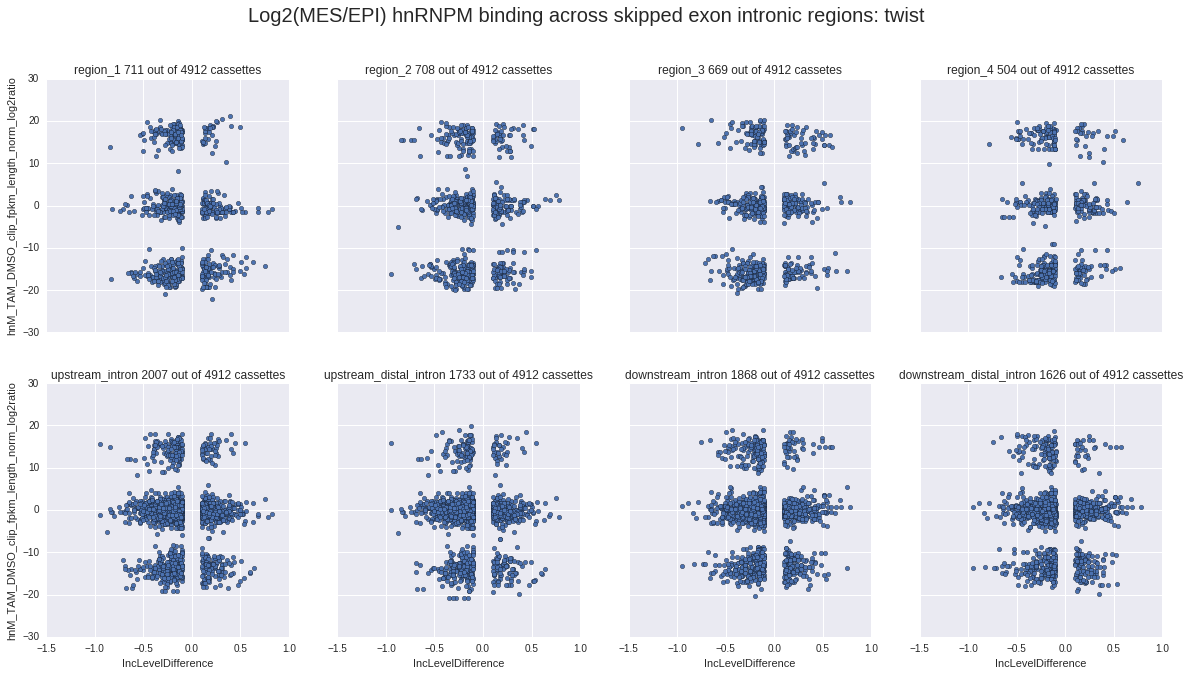

In [516]:
#PLOTTING TWIST DELTA PSI WITH LOG2 RATIO OF MES/EPI
#What are these three groups? What could separate log ratio so drastically? Presence of binding vs. just a pseudocount?
#Yes - the top group has only TAM binding, the middle group has both, and the bottom group has only DMSO binding
logy = False

twist_dPSI_versus_log2ratio_binding(twist_region_1_intersect_df_filtered,twist_region_2_intersect_df_filtered,twist_region_3_intersect_df_filtered,twist_region_4_intersect_df_filtered,twist_upstream_int_intersect_df_filtered,twist_upstream_distal_int_intersect_df_filtered,twist_downstream_int_intersect_df_filtered,twist_downstream_distal_int_intersect_df_filtered,twist_rMATS_df_filtered,'twist',logy)

In [361]:
cc3_cc4_upstream_int_intersect_df_filtered.describe()

,start,end,inc_level_1_mean,inc_level_2_mean,IncLevelDifference,FDR,SAMPLE_1_AVERAGE_READ,SAMPLE_2_AVERAGE_READ,ID,hnM_DMSO_clip_fpkm_norm,hnM_TAM_clip_fpkm_norm,interval_length,hnM_DMSO_clip_fpkm_length_norm,hnM_TAM_clip_fpkm_length_norm,hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio,sample_1_fpkm,sample_2_fpkm
count,5.810000e+02,5.810000e+02,581.000000,581.000000,581.000000,5.810000e+02,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,579.000000,579.000000
mean,8.059365e+07,8.060639e+07,0.492866,0.616542,-0.123676,6.947903e-03,578.523236,419.903614,36531.752151,40.839993,61.745165,12740.185886,0.003871,0.005633,-0.936188,62.996247,65.202974
std,5.675047e+07,5.675079e+07,0.308521,0.281089,0.241645,1.189573e-02,1194.859639,895.859753,21132.347766,144.451755,253.851523,17303.927601,0.018525,0.029677,6.748180,127.918519,128.394514
min,3.068690e+05,3.114070e+05,0.000000,0.011000,-0.982000,0.000000e+00,21.000000,20.000000,562.000000,0.000000,0.000000,142.000000,0.000000,0.000000,-19.386943,0.131183,0.000000
25%,3.523300e+07,3.523640e+07,0.203000,0.377000,-0.260000,1.055890e-07,132.000000,88.000000,18016.000000,0.438637,0.394922,3165.000000,0.000099,0.000062,-1.559930,14.606800,14.387450
50%,7.019614e+07,7.020041e+07,0.491000,0.645000,-0.165000,2.732070e-04,281.000000,201.000000,37373.000000,3.581671,3.157318,7073.000000,0.000504,0.000444,-0.198945,27.110000,30.043200
75%,1.141886e+08,1.142016e+08,0.771000,0.874000,-0.102000,7.885523e-03,548.000000,399.000000,55241.000000,19.728179,20.347594,14844.000000,0.002331,0.002531,1.024912,55.223000,61.213900
max,2.451806e+08,2.452227e+08,1.000000,1.000000,0.706000,4.988355e-02,16729.000000,11658.000000,74083.000000,1658.605361,3137.500373,143499.000000,0.407238,0.611789,19.813638,1550.590000,1678.230000


In [360]:
cc3_cc4_downstream_int_intersect_df_filtered.describe()

,start,end,inc_level_1_mean,inc_level_2_mean,IncLevelDifference,FDR,SAMPLE_1_AVERAGE_READ,SAMPLE_2_AVERAGE_READ,ID,hnM_DMSO_clip_fpkm_norm,hnM_TAM_clip_fpkm_norm,interval_length,hnM_DMSO_clip_fpkm_length_norm,hnM_TAM_clip_fpkm_length_norm,hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio,sample_1_fpkm,sample_2_fpkm
count,5.810000e+02,5.810000e+02,581.000000,581.000000,581.000000,5.810000e+02,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,579.000000,579.000000
mean,8.059365e+07,8.060639e+07,0.492866,0.616542,-0.123676,6.947903e-03,578.523236,419.903614,36531.752151,40.839993,61.745165,12740.185886,0.003871,0.005633,-0.936188,62.996247,65.202974
std,5.675047e+07,5.675079e+07,0.308521,0.281089,0.241645,1.189573e-02,1194.859639,895.859753,21132.347766,144.451755,253.851523,17303.927601,0.018525,0.029677,6.748180,127.918519,128.394514
min,3.068690e+05,3.114070e+05,0.000000,0.011000,-0.982000,0.000000e+00,21.000000,20.000000,562.000000,0.000000,0.000000,142.000000,0.000000,0.000000,-19.386943,0.131183,0.000000
25%,3.523300e+07,3.523640e+07,0.203000,0.377000,-0.260000,1.055890e-07,132.000000,88.000000,18016.000000,0.438637,0.394922,3165.000000,0.000099,0.000062,-1.559930,14.606800,14.387450
50%,7.019614e+07,7.020041e+07,0.491000,0.645000,-0.165000,2.732070e-04,281.000000,201.000000,37373.000000,3.581671,3.157318,7073.000000,0.000504,0.000444,-0.198945,27.110000,30.043200
75%,1.141886e+08,1.142016e+08,0.771000,0.874000,-0.102000,7.885523e-03,548.000000,399.000000,55241.000000,19.728179,20.347594,14844.000000,0.002331,0.002531,1.024912,55.223000,61.213900
max,2.451806e+08,2.452227e+08,1.000000,1.000000,0.706000,4.988355e-02,16729.000000,11658.000000,74083.000000,1658.605361,3137.500373,143499.000000,0.407238,0.611789,19.813638,1550.590000,1678.230000


In [354]:
cc1_cc2_upstream_distal_int_intersect_df.describe()

,start,end,inc_level_1_mean,inc_level_2_mean,IncLevelDifference,FDR,SAMPLE_1_AVERAGE_READ,SAMPLE_2_AVERAGE_READ,ID,hnM_DMSO_clip_fpkm_norm,hnM_TAM_clip_fpkm_norm,interval_length,hnM_DMSO_clip_fpkm_length_norm,hnM_TAM_clip_fpkm_length_norm,hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio
count,1.316300e+04,1.316300e+04,13163.000000,13163.000000,13163.000000,13163.000000,13163.000000,13163.000000,13163.000000,13163.000000,13163.000000,13163.000000,13163.000000,13163.000000,13163.000000
mean,7.698009e+07,7.699549e+07,0.788185,0.798843,-0.010657,0.725619,893.656613,651.417382,35367.967181,36.331916,55.369671,15400.937172,0.002560,0.003289,-0.798941
std,5.509219e+07,5.509268e+07,0.343888,0.339960,0.084058,0.333479,2941.402849,1758.481100,20495.560770,137.253930,239.464571,20247.602802,0.013165,0.017198,6.842163
min,7.943900e+04,8.676800e+04,0.000000,0.000000,-0.869000,0.000000,20.000000,20.000000,6.000000,0.000000,0.000000,2.000000,0.000000,0.000000,-21.894151
25%,3.453884e+07,3.454598e+07,0.798000,0.825000,-0.026000,0.519813,116.000000,97.000000,17352.000000,0.377265,0.265709,3829.000000,0.000069,0.000043,-1.706305
50%,6.616246e+07,6.618799e+07,0.970000,0.978000,-0.003000,0.879048,281.000000,232.000000,35517.000000,2.824837,2.554909,8495.000000,0.000357,0.000332,-0.158145
75%,1.112896e+08,1.112911e+08,0.995000,1.000000,0.013000,1.000000,714.000000,559.000000,53323.000000,18.702000,20.089422,19253.000000,0.001639,0.001774,1.124173
max,2.491456e+08,2.491476e+08,1.000000,1.000000,0.660000,1.000000,103832.000000,60018.000000,70944.000000,4260.293153,8599.849664,324658.000000,0.540682,0.824235,24.395545


In [334]:
hh5_hh6_region_3_intersect_df_filtered.head()

,chr,start,end,ens_gene,splice_id,strand,inc_level_1_mean,inc_level_2_mean,IncLevelDifference,FDR,...,external_gene_name,biotype,interval_length,hnM_DMSO_clip_fpkm_length_norm,hnM_TAM_clip_fpkm_length_norm,hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio,gene,gene_coords,sample_1_fpkm,sample_2_fpkm
19,chr1,1323371,1323871,ENSG00000221978,chr1:1323333-1323445:1323871-1323890:1324005-1...,-,0.842,0.553,0.289,1.366379e-09,...,CCNL2,protein_coding,500.0,0.000297,0.000000,-14.856349,CCNL2,chr1:1321090-1334708,69.38230,99.66200
25,chr1,1327669,1328169,ENSG00000221978,chr1:1326145-1326245:1328169-1328183:1328775-1...,-,0.472,0.714,-0.242,9.292347e-06,...,CCNL2,protein_coding,500.0,0.000371,0.000000,-15.178267,CCNL2,chr1:1321090-1334708,69.38230,99.66200
30,chr1,2123783,2124283,ENSG00000162585,chr1:2115916-2116952:2124283-2124414:2125077-2...,-,0.463,0.831,-0.368,1.037870e-08,...,FAAP20,protein_coding,500.0,0.000143,0.000000,-13.801061,C1orf86,chr1:1981908-2152177,16.16330,15.00970
41,chr1,6604604,6605104,ENSG00000162408,chr1:6593339-6593501:6605104-6605240:6609630-6...,-,0.690,0.864,-0.174,2.375585e-04,...,NOL9,protein_coding,500.0,0.001602,0.000000,-17.289545,NOL9,chr1:6581406-6614595,5.11337,8.13453
48,chr1,8851962,8852462,ENSG00000142599,chr1:8716031-8716500:8852462-8852647:8877218-8...,-,0.163,0.448,-0.285,1.169569e-05,...,RERE,protein_coding,500.0,0.042276,0.004421,-3.257509,RERE,chr1:8412456-8877702,16.33600,13.66300


In [335]:
hh5_hh6_region_4_intersect_df_filtered.head()

,chr,start,end,ens_gene,splice_id,strand,inc_level_1_mean,inc_level_2_mean,IncLevelDifference,FDR,...,external_gene_name,biotype,interval_length,hnM_DMSO_clip_fpkm_length_norm,hnM_TAM_clip_fpkm_length_norm,hnM_TAM_DMSO_clip_fpkm_length_norm_log2ratio,gene,gene_coords,sample_1_fpkm,sample_2_fpkm
19,chr1,1323445,1323945,ENSG00000221978,chr1:1323333-1323445:1323871-1323890:1324005-1...,-,0.842,0.553,0.289,1.366379e-09,...,CCNL2,protein_coding,500.0,0.000297,0.000000,-14.856349,CCNL2,chr1:1321090-1334708,69.3823,99.6620
23,chr1,1326245,1326745,ENSG00000221978,chr1:1326145-1326245:1328169-1328183:1328775-1...,-,0.472,0.714,-0.242,9.292347e-06,...,CCNL2,protein_coding,500.0,0.001335,0.000851,-0.648904,CCNL2,chr1:1321090-1334708,69.3823,99.6620
26,chr1,2116952,2117452,ENSG00000162585,chr1:2115916-2116952:2124283-2124414:2125077-2...,-,0.463,0.831,-0.368,1.037870e-08,...,FAAP20,protein_coding,500.0,0.000000,0.000107,13.379076,C1orf86,chr1:1981908-2152177,16.1633,15.0097
40,chr1,6523030,6523530,ENSG00000215788,chr1:6522922-6523030:6523124-6523207:6524434-6...,-,0.322,0.143,0.179,4.900299e-02,...,TNFRSF25,protein_coding,500.0,0.000000,0.002835,18.113094,TNFRSF25,chr1:6484847-6580121,37.4688,22.0905
102,chr1,23665101,23665601,ENSG00000125944,chr1:23664982-23665101:23667344-23667510:23670...,-,0.399,0.693,-0.294,0.000000e+00,...,HNRNPR,protein_coding,500.0,0.000263,0.000843,1.678421,HNRNPR,chr1:23630263-23670829,90.0612,65.3024


In [ ]:
all_binding_regions_by_psi(twist_region_1_intersect_df_filtered,twist_region_2_intersect_df_filtered,twist_region_2_intersect_df_filtered,twist_region_2_intersect_df_filtered,twist_rMATS_df_filtered,'MES','twist',0)

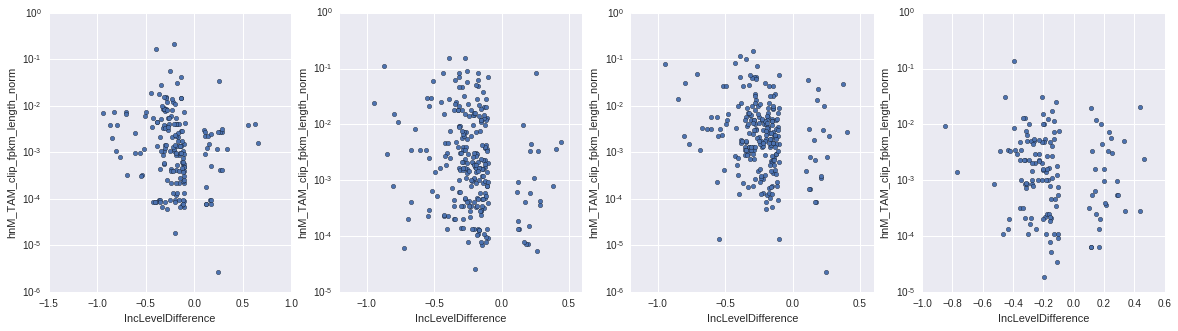

In [193]:
#now try for the Region 1 - 4

def all_binding_regions_by_psi(dataframe,sample_type):
    

#isolate sample bound
region_1 = cc1_cc2_region_1_intersect_df_filtered[cc1_cc2_region_1_intersect_df_filtered.hnM_TAM_clip_fpkm_length_norm > 0]

region_2 = cc1_cc2_region_2_intersect_df_filtered[cc1_cc2_region_2_intersect_df_filtered.hnM_TAM_clip_fpkm_length_norm > 0]

region_3 = cc1_cc2_region_3_intersect_df_filtered[cc1_cc2_region_3_intersect_df_filtered.hnM_TAM_clip_fpkm_length_norm > 0]

region_4 = cc1_cc2_region_4_intersect_df_filtered[cc1_cc2_region_4_intersect_df_filtered.hnM_TAM_clip_fpkm_length_norm > 0]

#plot each area in order
fix, ax = plt.subplots(1,4,figsize=(20,5))
region_1.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[0],logy=True)
region_2.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[1],logy=True)
region_3.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[2],logy=True)
region_4.plot(kind='scatter',x='IncLevelDifference',y='hnM_TAM_clip_fpkm_length_norm',ax=ax[3],logy=True)




In [21]:
#Try vennt - not working... see if I can get it to work later
#This will be a great venn diagram tool for comparisons
!/home/sam/bin/vennt/vennt.py --csvfile spliced_exon_analysis/twist_v_intersect_df_background spliced_exon_analysis/cc1_cc2_v_intersect_df_background spliced_exon_analysis/cc3_cc4_v_intersect_df_background spliced_exon_analysis/hh5_hh6_v_intersect_df_background -o spliced_exon_analysis/intersect_df_background_venn --id splice_id --info splice_id

Using a separate CSV files
  Reading : spliced_exon_analysis/twist_v_intersect_df_background
  Reading : spliced_exon_analysis/cc1_cc2_v_intersect_df_background
  Reading : spliced_exon_analysis/cc3_cc4_v_intersect_df_background
  Reading : spliced_exon_analysis/hh5_hh6_v_intersect_df_background


In [209]:
#NOTE - I HAVE JUST USED THE RMATS OUTPUT, I HAVEN'T REALLY DONE ANYTHING WITH THE OTHER SPLICING LIBRARIES
#NOTE - I DID USE THE SE EVENTS FOR EACH SAMPLE

#bring in the list of all known cassette exons
#Let's use hg19_known_alt (could also do hg38_to_hg19_known_alt)
hg19_exons_splice_labeled_df = pd.read_csv('spliced_exon_analysis/hg19_v19_exons_labeled_as_alternatively_spliced',sep='\t')

#Now bring in the hnM clip intersected data from the exon_centric analysis
intersect_df = pd.read_csv('spliced_exon_analysis/hg19_v19_exons_labeled_hnRNPM_clip_intersect',sep='\t')
#collect by splicing type
intersect_df = intersect_df[intersect_df.splicing_type == 'cassette']
#collect by sample (require that value b > 0)
dmso = intersect_df[intersect_df.hnM_DMSO_clip_fpkm_length_norm > 0]
tam = intersect_df[intersect_df.hnM_TAM_clip_fpkm_length_norm > 0]

#print number of exons
print(len(dmso))
print(len(tam))

1125
915


In [ ]:
#NOTE - At this point we have collect hnRNPM bound cassette exons that don't change during the analysis as part of two sources.
#1. From the rMATS data itself, by intersecting only after filtering by read_count to show that it is a true splicing event for which there is evidence in the data and then using the Yang 2016 filtering
#2. from hg19_knownAlt, which presents a list of cassette exons with which I intersected perfectly with hg19_v19_exons from clipper and the binding data
#1 may be biased against non-sense mediated decay events because they would deplete the mRNA and maybe wouldn't show up in rMATS detected splicing events.
#Figure this out... Note - the rMATS splicing events searched are not fully present in 

<matplotlib_venn._common.VennDiagram instance at 0x7f08c8210560>

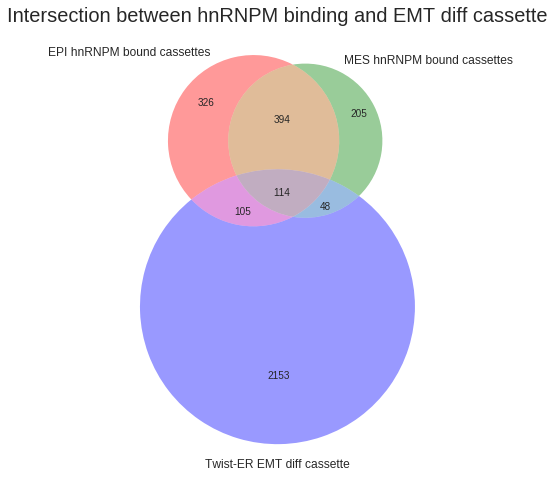

In [246]:
#Do venn diagrams between condition dependent splicing and hnRNPM binding of cassette exons...
#To do this I need the list of cassette exons regulated by EMT or hnRNPM knockdown as well as the full list of cassette exons bound by hnRNPM in each condition

#I have the list of cassette exons spliced during EMT. I need to have a v exon ID for collapsing or do an intersect.

#Now I need a list of all alternative exons in my samples but that don't depend on the phenotype

#remember that mplv 2 venn takes a list of 3 things Ab, aB, AB. or the actual sets of values

#------------------------

#TWIST Venn Diagram - do a 3 way
#Intersecting based on splice_id, which should contain gene of interest

dmso = twist_v_intersect_df_background[twist_v_intersect_df_background.hnM_DMSO_clip_fpkm_length_norm > 0]
tam = twist_v_intersect_df_background[twist_v_intersect_df_background.hnM_TAM_clip_fpkm_length_norm > 0]

plt.figure(figsize=(8,8))
plt.title('Intersection between hnRNPM binding and EMT diff cassette',fontsize=20)
mplv.venn3([set(dmso.splice_id.tolist()),set(tam.splice_id.tolist()),set(twist_rMATS_df_filtered.splice_id.tolist())],set_labels=('EPI hnRNPM bound cassettes','MES hnRNPM bound cassettes','Twist-ER EMT diff cassette'))

#collect the intersections:

<matplotlib_venn._common.VennDiagram instance at 0x7f665216e4d0>

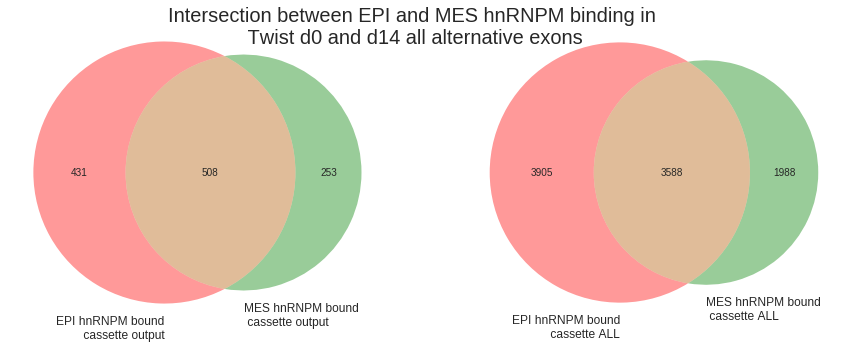

In [90]:
#Just do a 2 venn with alternative exons from twist er cells (my current method just shows that they are alternative in one or both cases) based on the Yang 2016 criteria as well as just the whole background of all considered exons

#NOTE - THERE IS A MASSIVE DIFFERENCE IN THE NUMBER OF INTERSECTED EVENTS BUT THE RATIOS ARE THE SAME

#Remember, this is just, is there there binding or not, no inclusion of differential binding, although that could be calculated here.

dmso = twist_v_intersect_df_background[twist_v_intersect_df_background.hnM_DMSO_clip_fpkm_length_norm > 0]
dmso_all_se = twist_v_intersect_ALL_SE_df[twist_v_intersect_ALL_SE_df.hnM_DMSO_clip_fpkm_length_norm > 0]
tam = twist_v_intersect_df_background[twist_v_intersect_df_background.hnM_TAM_clip_fpkm_length_norm > 0]
tam_all_se = twist_v_intersect_ALL_SE_df[twist_v_intersect_ALL_SE_df.hnM_TAM_clip_fpkm_length_norm > 0]

fig, ax = plt.subplots(1,2,figsize=(15,8))
plt.suptitle('Intersection between EPI and MES hnRNPM binding in\n Twist d0 and d14 all alternative exons',fontsize=20,y=0.8)

mplv.venn2([set(dmso.splice_id.tolist()),set(tam.splice_id.tolist())],set_labels=('EPI hnRNPM bound\n cassette output','MES hnRNPM bound\n cassette output'),ax=ax[0])
mplv.venn2([set(dmso_all_se.splice_id.tolist()),set(tam_all_se.splice_id.tolist())],set_labels=('EPI hnRNPM bound\n cassette ALL','MES hnRNPM bound\n cassette ALL'),ax=ax[1])


<matplotlib_venn._common.VennDiagram instance at 0x7f666756f128>

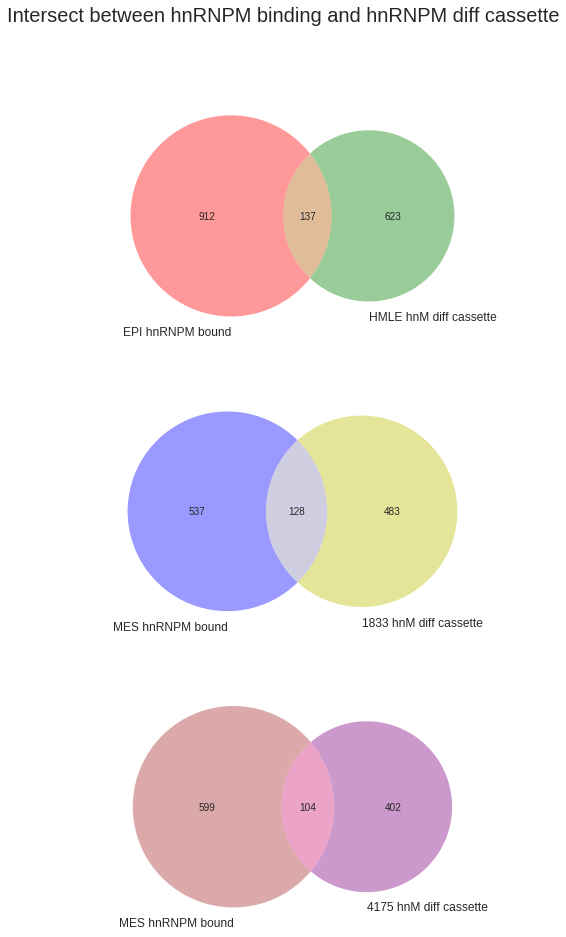

In [91]:
#venn diagram of CC1 and CC2 with bound vs. regulated. Include CC3_CC4 and HH5_HH6
#Remember these are surrogates for function, not perfect function.

#Remember I don't really have any cutoffs for inclusion of binding here. It is just clipper windows and is there an RT stop that fits in the clipper windows

fig, ax = plt.subplots(3,1,figsize=(10,15))
fig.suptitle('Intersect between hnRNPM binding and hnRNPM diff cassette',fontsize=20)

cc1_cc2_dmso = cc1_cc2_v_intersect_df_background[cc1_cc2_v_intersect_df_background.hnM_DMSO_clip_fpkm_length_norm > 0]
cc3_cc4_dmso = cc3_cc4_v_intersect_df_background[cc3_cc4_v_intersect_df_background.hnM_DMSO_clip_fpkm_length_norm > 0]
hh5_hh6_dmso = hh5_hh6_v_intersect_df_background[hh5_hh6_v_intersect_df_background.hnM_DMSO_clip_fpkm_length_norm > 0]

cc1_cc2_tam = cc1_cc2_v_intersect_df_background[cc1_cc2_v_intersect_df_background.hnM_TAM_clip_fpkm_length_norm > 0]
cc3_cc4_tam = cc3_cc4_v_intersect_df_background[cc3_cc4_v_intersect_df_background.hnM_TAM_clip_fpkm_length_norm > 0]
hh5_hh6_tam = hh5_hh6_v_intersect_df_background[hh5_hh6_v_intersect_df_background.hnM_TAM_clip_fpkm_length_norm > 0]

mplv.venn2([set(hh5_hh6_dmso.splice_id.tolist()),set(hh5_hh6_rMATS_df_filtered.splice_id.tolist())],set_labels=('EPI hnRNPM bound','HMLE hnM diff cassette'),ax=ax[0])

mplv.venn2([set(cc1_cc2_tam.splice_id.tolist()),set(cc1_cc2_rMATS_df_filtered.splice_id.tolist())],set_labels=('MES hnRNPM bound','1833 hnM diff cassette'),ax=ax[1],set_colors=('b','y'))

mplv.venn2([set(cc3_cc4_tam.splice_id.tolist()),set(cc3_cc4_rMATS_df_filtered.splice_id.tolist())],set_labels=('MES hnRNPM bound','4175 hnM diff cassette'),ax=ax[2],set_colors=('brown','purple'))




'Done'

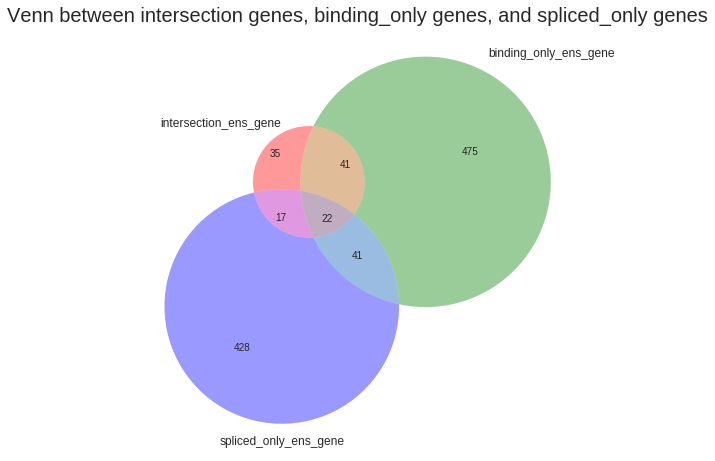

In [129]:
collect_and_process_intersection_ids(set(hh5_hh6_dmso.splice_id.tolist()),set(hh5_hh6_rMATS_df_filtered.splice_id.tolist()),'spliced_exon_analysis/hh5-6')

'Done'

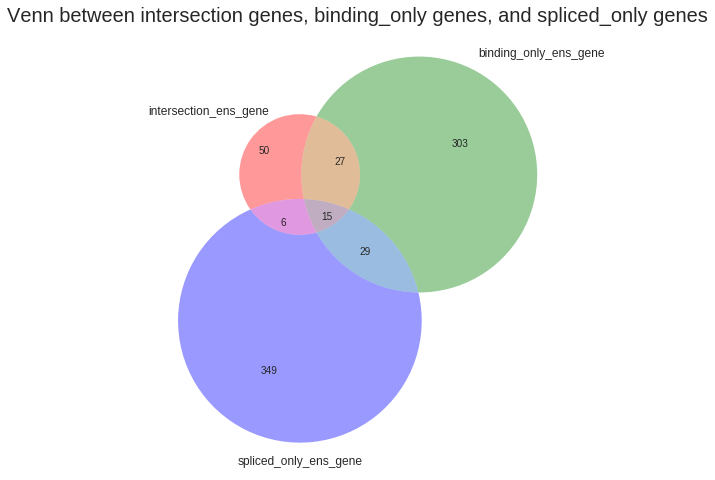

In [130]:
collect_and_process_intersection_ids(set(cc1_cc2_tam.splice_id.tolist()),set(cc1_cc2_rMATS_df_filtered.splice_id.tolist()),'spliced_exon_analysis/cc1-2/')

'Done'

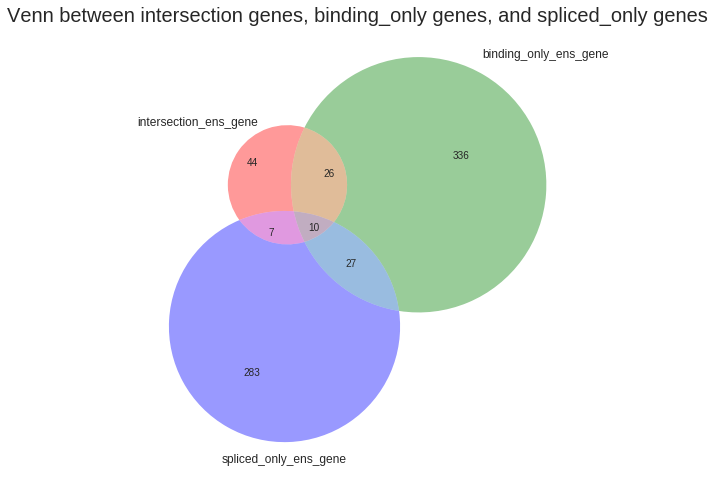

In [131]:
collect_and_process_intersection_ids(set(cc3_cc4_tam.splice_id.tolist()),set(cc3_cc4_rMATS_df_filtered.splice_id.tolist()),'spliced_exon_analysis/cc3-4/')

In [ ]:
#Now that I have the average binding for each exon - what do I do.
#This is differential binding during EMT paired with PSI values. I want to figure out how binding associates with PSI values by plotting PSI by normalized binding intensity

#Another key thing to do is in each condition create a venn diagram of regulated vs. bound cassette exons and do GO on the list

#Another thing I want to do is easily bring in the metagene analysis using the metagene-maker from Brian Do for immediate plotting.

In [31]:
v_intersect_df.describe()

,start,end,ID,inc_level_1_mean,inc_level_2_mean,IncLevelDifference,FDR,SAMPLE_1_AVERAGE_READ,SAMPLE_2_AVERAGE_READ,ID.1,hnM_DMSO_clip_fpkm_norm,hnM_TAM_clip_fpkm_norm,interval_length,hnM_DMSO_clip_fpkm_length_norm,hnM_TAM_clip_fpkm_length_norm
count,8.711000e+03,8.711000e+03,8711.000000,8711.000000,8711.00000,8711.000000,8711.000000,8.711000e+03,8.711000e+03,8711.000000,8711.000000,8711.000000,8711.000000,8711.000000,8711.000000
mean,7.628192e+07,7.628268e+07,43398.503387,0.720097,0.74003,-0.019933,0.623675,9.607033e+03,1.283529e+04,43398.503387,1.358558,1.606646,756.578579,0.001865,0.002254
std,5.831928e+07,5.831928e+07,25103.851263,0.387083,0.38388,0.144561,0.428181,4.938237e+04,8.003967e+04,25103.851263,5.704064,15.262642,270.078161,0.008240,0.023775
min,1.732050e+05,1.738440e+05,62.000000,0.000000,0.00000,-1.000000,0.000000,1.000000e+00,1.000000e+00,62.000000,0.000000,0.000000,603.000000,0.000000,0.000000
25%,3.312750e+07,3.312831e+07,21547.500000,0.404500,0.48300,-0.026000,0.103909,2.230000e+02,1.585000e+02,21547.500000,0.016273,0.000000,679.000000,0.000022,0.000000
50%,6.191027e+07,6.191096e+07,43733.000000,0.968000,0.98500,-0.002000,0.931026,8.760000e+02,7.300000e+02,43733.000000,0.196867,0.062578,713.000000,0.000268,0.000087
75%,1.118930e+08,1.118938e+08,64678.500000,0.997000,1.00000,0.005000,1.000000,3.198500e+03,2.851000e+03,64678.500000,0.787492,0.726106,758.000000,0.001071,0.000956
max,2.491143e+08,2.491154e+08,86797.000000,1.000000,1.00000,1.000000,1.000000,1.787813e+06,1.598027e+06,86797.000000,264.003801,1285.060065,6189.000000,0.418390,2.036545


In [36]:
twist_d0_v_bt_sorted_slop_intersect.head()

chr1	889083	890203	chr1:889161-889272:889383-889903:891302-891393:-:NOC2L	11013	-	0.993	0.998	-0.005	chr1	890050	890051	ENSG00000188976	0	-	0.0596684263745	0.0
 chr1	889083	890203	chr1:889161-889272:889383-889903:891302-891393:-:NOC2L	11013	-	0.993	0.998	-0.005	chr1	890202	890203	ENSG00000188976	0	-	0.143204223299	0.0743137758574
 chr1	978617	979412	chr1:978618-978837:978917-979112:979202-979403:+:AGRN	41783	+	0.996	1.0	-0.004	chr1	978997	978998	ENSG00000188157	0	+	0.0272170228173	0.0
 chr1	978902	979703	chr1:978917-979112:979202-979403:979488-979637:+:AGRN	41786	+	1.0	0.999	0.001	chr1	978997	978998	ENSG00000188157	0	+	0.0272170228173	0.0
 chr1	980240	980957	chr1:979713-979819:980540-980657:980738-980903:+:AGRN	41778	+	1.0	0.999	0.001	chr1	980814	980815	ENSG00000188157	0	+	0.0340212785217	0.0
 chr1	987072	987696	chr1:987107-987195:987372-987396:989132-989330:+:AGRN	41791	+	0.008	0.005	0.003	chr1	987523	987524	ENSG00000188157	0	+	0.0476297899303	0.0
 chr1	987072	987696	chr1:987107-98719

In [26]:
len(twist_d0_v_bt_slop)

69193

In [9]:
twist_rMATS_df.columns.tolist()

['splice_id',
 'ID',
 'GeneID',
 'geneSymbol',
 'chr',
 'strand',
 'exonStart_0base',
 'exonEnd',
 'upstreamES',
 'upstreamEE',
 'downstreamES',
 'downstreamEE',
 'ID.1',
 'IC_SAMPLE_1',
 'SC_SAMPLE_1',
 'SAMPLE_1_AVERAGE_READ',
 'IC_SAMPLE_2',
 'SC_SAMPLE_2',
 'SAMPLE_2_AVERAGE_READ',
 'IncFormLen',
 'SkipFormLen',
 'PValue',
 'FDR',
 'IncLevel1',
 'inc_level_1_mean',
 'IncLevel2',
 'inc_level_2_mean',
 'IncLevelDifference',
 'splicing_factor_effect']